# Movie Night Movie Data Analysis

Last Movie Added:  3/12/2021

### Import Libraries & Load Files

In [551]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup

import requests
import csv
import re
import time
from tqdm import tqdm

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px

plt.style.use('ggplot')

import imdb

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

In [2]:
# import foreign currency exchange rates - downloaded 3/4/2021
# https://www.bis.org/statistics/xrusd.htm
exchange_rates = pd.read_csv('data/foreign_exchange_rates.csv', low_memory=False)

# import inflation factors - 2016 was the most recent I could find easily.
# conversions will go from movie year to 2016, then 2016 to 2021. 
inflation_factors = pd.read_csv('data/inflation_factors_2016.csv')

In [3]:
movie_night_list = [
    'Cats (2019)',
    'Emo the Musical',
    'Sunday School Musical',
    'Paul Blart Mall Cop 2',
    'Waterworld',
    'Battlefield Earth',
    'Striking Distance',
    'Twilight',
    'Twilight: New Moon',
    'The Lizzie McGuire Movie',
    'Gigli',
    'Anon',
    'Step Sisters',
    'Rip Tide',
    'Starship Troopers',
    'The Clique',
    'The Last Airbender',
    'Sleepover',
    'The Adventures of Sharkboy and Lavagirl 3-D (2005)',
    'The Roommate',
    'Mortal Kombat (1995)',
    'Ghost Rider',
    'Sex and The City 2',
    'The Adventures of Pluto Nash',
    'Scooby-Doo',
    'Silent Hill',
    'Resident Evil (2002)',
    'Yinz',
    'The Anomaly',
    'Birdemic: Shock and Terror',
    'Super Mario Bros.',
    'Trolls World Tour',
    'Rocky Horror',
    'Street Fighter',
    'A Very Country Christmas',
    'Santa Girl',
    'We Can Be Heroes',
    'Spice World',
    'Star Trek IV',
    'I Know Who Killed Me',
    'Jungle 2 Jungle',
    'Howard the Duck',
    'She’s All That',
    'Hackers',
    'Batman and Robin',
    'My Brother the Pig',
    'Catwoman (2004)'
]

test_movie_list = ['Emo the Musical']

### Scrape IMDB

#### Scrape Data for Movie Night Movies

In [4]:
movie_attributes = [ 
  'plot',
  'original title',
  'cast',
  'genres',
  'runtimes',
  'countries',
  'country codes',
  'language codes',
  'color info',
  'aspect ratio',
  'sound mix',
  'certificates',
  'original air date',
  'rating',
  'votes',
  'cover url',
  'imdbID',
  'languages',
  'title',
  'year',
  'kind',
  'directors',
  'writers',
  'producers',
  'composers',
  'cinematographers',
  'editors',
  'editorial department',
  'casting directors',
  'production designers',
  'art directors',
  'set decorators',
  'costume designers',
  'make up department',
  'production managers',
  'assistant directors',
  'art department',
  'sound department',
  'special effects',
  'visual effects',
  'stunts',
  'camera department',
  'animation department',
  'casting department',
  'costume departmen',
  'location management',
  'music department',
  'script department',
  'transportation department',
  'miscellaneous',
  'akas',
  'writer',
  'director',
  'bottom 100 rank',
  'production companies',
  'distributors',
  'special effects companies',
  'other companies'
]

# attributes characterized by a list of one or more names 
name_flags = [
  'cast',
  'directors',
  'writers',
  'producers',
  'composers',
  'cinematographers',
  'editors',
  'editorial department',
  'casting directors',
  'production designers',
  'art directors',
  'set decorators',
  'costume designers',
  'make up department',
  'production managers',
  'assistant directors',
  'art department',
  'sound department',
  'special effects',
  'visual effects',
  'stunts',
  'camera department',
  'animation department',
  'casting department',
  'costume departmen',
  'location management',
  'music department',
  'script department',
  'transportation department',
  'miscellaneous',
  'writer',
  'director',
  'production companies',
  'distributors',
  'special effects companies',
  'other companies'
]

In [5]:
# scraping functions

def movie_search(movie_title, base_url):
    search_query = base_url + movie_title
    response = requests.get(search_query)
    return response

def scrape_movie_data(movie_list):

    movie_attribute_list = []
    money_attribute_list = []

    imdb_base_url = 'https://www.imdb.com/title/tt'
    money_search_terms = ['Budget:', 'Opening Weekend USA:', 'Gross USA:', 'Cumulative Worldwide Gross:']

    ia = imdb.IMDb()
    for movie_title in tqdm(movie_list):
        movie_row = []
        attempt_counter = 0
        while attempt_counter < 3:
            try: 
                movie_search_results = ia.search_movie(movie_title)
                attempt_counter = 3
            except:
                print('Internal Server Error; Attempt:', attempt_counter+1)
                print('Retrying...')
                attempt_counter += 1
        
        if len(movie_search_results) > 0:
            movie_id = movie_search_results[0].movieID
            movie = ia.get_movie(movie_id)

            for att in movie_attributes:
                try:
                    if att in name_flags:
                        movie_row.append([x['name'] for x in movie[att]])
                    else:
                        movie_row.append(movie[att])
                except:
                    movie_row.append('') 

            movie_attribute_list.append(movie_row)


            response = movie_search(movie_id, imdb_base_url)
            soup = BeautifulSoup(response.content, 'html.parser')

            h4_elements = soup.find_all('h4', {'class':'inline'})


            money_attributes = []

            for term in money_search_terms: 
                not_scraped = True
                for elem in h4_elements:    
                    if elem.text == term:
                        money_attributes.append(elem.find_parent('div').text)
                        not_scraped = False
                if not_scraped:
                    money_attributes.append('')

            money_attribute_list.append(money_attributes)
            
        else:
            print('FURK. Movie not found:', movie_title)
           
            for att in movie_attributes:
                movie_row.append('Not Found')
            movie_attribute_list.append(movie_row)
                
            money_attributes = []
            for term in money_search_terms: 
                money_attributes.append('Not Found')
            money_attribute_list.append(money_attributes)
            
        
    # Clean each set of data

    clean_movie_attribute_list = []

    for movie_row in movie_attribute_list:
        new_row = []
        for movie_att in movie_row:
            if isinstance(movie_att, list):
                new_row.append('; '.join(movie_att))
            else: 
                new_row.append(movie_att)

        clean_movie_attribute_list.append(new_row)   

    clean_money_attribute_list = []

    for movie_row in money_attribute_list:
        new_row = []
        country_code = 'USD'
        for money_attribute in movie_row:
            if money_attribute == '' or money_attribute == 'Not Found':
                new_row.append('')
                
            else:
                split_money_attribute = money_attribute.split('\n')[1]
                budget_val = int(re.sub('[^0-9]', '', split_money_attribute))
               
                # convert foreign currency values to US dollars
                pattern_search = re.findall('[A-Z][A-Z][A-Z][0-9]+', money_attribute)
                if len(pattern_search) > 0:
                    exchange_rate = 1.0
                    country_code = re.findall('[A-Z][A-Z][A-Z][0-9]+', money_attribute)[0][:-1]
                    country_code = re.sub('[0-9]', '', country_code)
                    rate_df = exchange_rates.loc[exchange_rates['CURRENCY'] == country_code]
                    
                    if rate_df.shape[0] > 0:
                        last_ten_rates = [rate_df[col].values[0] if ~np.isnan(rate_df[col].values[0]) else 0 for col in rate_df.columns[-10:]]
                        last_ten_rates = list(filter((0).__ne__, last_ten_rates))

                        if len(last_ten_rates) > 0:
                            exchange_rate = float(last_ten_rates[-1])
                        else: 
                            'no rates in last ten measurement dates. expand range.'
                        budget_val /= exchange_rate
                    else: 
                        print('currency code not found.')
                        print(country_code)
                    
                new_row.append(budget_val)
        new_row.append(country_code)        
                
        clean_money_attribute_list.append(new_row)   

    # Create dataframe

    movie_df = pd.DataFrame(movie_list, columns=['movie_title'])

    money_attribute_cols = [re.sub(':', '', x).lower() for x in money_search_terms]
    money_attribute_cols = [re.sub(' ', '_', x) + '_imdb' for x in money_attribute_cols]
    money_attribute_cols.append('original_currency_code')
    money_attribute_df = pd.DataFrame(clean_money_attribute_list, columns=money_attribute_cols)

    imdb_attribute_df = pd.DataFrame(clean_movie_attribute_list, columns=[re.sub(' ', '_', x) for x in movie_attributes]) 

    movie_df = pd.concat([movie_df, imdb_attribute_df, money_attribute_df], axis=1)

    return movie_df

In [6]:
movie_df = scrape_movie_data(movie_night_list)

100%|██████████| 47/47 [01:57<00:00,  2.50s/it]


In [7]:
movie_df.tail()

movie_title                                               plot  \
42      She’s All That  A high school jock makes a bet that he can tur...   
43             Hackers  Hackers are blamed for making a virus that wil...   
44    Batman and Robin  Batman and Robin try to keep their relationshi...   
45  My Brother the Pig  Being a teen is tough enough for Kathy Cauldwe...   
46     Catwoman (2004)  A shy woman, endowed with the speed, reflexes,...   

               original_title  \
42      She's All That (1999)   
43             Hackers (1995)   
44      Batman & Robin (1997)   
45  My Brother the Pig (1999)   
46            Gatúbela (2004)   

                                                 cast  \
42  Freddie Prinze Jr.; Rachael Leigh Cook; Matthe...   
43  Jonny Lee Miller; Angelina Jolie; Jesse Bradfo...   
44  Arnold Schwarzenegger; George Clooney; Chris O...   
45  Scarlett Johansson; Eva Mendes; Judge Reinhold...   
46  Halle Berry; Benjamin Bratt; Sharon Stone; Lam...   

                            genres runtimes                      countries  \
42                 Comedy; Romance       95                  United States   
43  Comedy; Crime; Drama; Thriller      105                  United States   
44                  Action; Sci-Fi      125  United States; United Kingdom   
45         Comedy; Family; Fantasy       92                  United States   
46          Action; Crime; Fantasy      104                  United States   

   country_codes  language_codes            color_info aspect_ratio  \
42            us              en  Color::(Technicolor)     1.85 : 1   
43            us  en; it; ja; ru                 Color     2.35 : 1   
44        us; gb              en                 Color     1.85 : 1   
45            us          es; en                 Color                
46            us          en; es                 Color     2.35 : 1   

                                sound_mix  \
42               DTS; Dolby Digital; SDDS   
43                        DTS-Stereo; DTS   
44  DTS; Dolby Digital; SDDS; Dolby Atmos   
45                                          
46               DTS; Dolby Digital; SDDS   

                                         certificates  original_air_date  \
42  Argentina:Atp; Australia:M; Belgium:KT/EA; Bra...  29 Jan 1999 (USA)   
43  Argentina:13; Australia:M; Canada:PG; Denmark:...  15 Sep 1995 (USA)   
44  Argentina:Atp; Australia:PG; Brazil:Livre; Can...  20 Jun 1997 (USA)   
45  Australia:PG; Germany:0; Iceland:L; Japan:G; S...  10 Sep 1999 (USA)   
46  Argentina:13; Australia:M; Austria:6; Brazil:1...  23 Jul 2004 (USA)   

    rating   votes                                          cover_url  \
42     5.9   85138  https://m.media-amazon.com/images/M/MV5BY2Y0N2...   
43     6.3   65619  https://m.media-amazon.com/images/M/MV5BNmExMT...   
44     3.8  235464  https://m.media-amazon.com/images/M/MV5BMGQ5YT...   
45     4.0    1352  https://m.media-amazon.com/images/M/MV5BMjE0Mz...   
46     3.4  111635  https://m.media-amazon.com/images/M/MV5BMjA4Mz...   

     imdbID                            languages               title  year  \
42  0160862                              English      She's All That  1999   
43  0113243  English; Italian; Japanese; Russian             Hackers  1995   
44  0118688                              English      Batman & Robin  1997   
45  0165396                     Spanish; English  My Brother the Pig  1999   
46  0327554                     English; Spanish            Catwoman  2004   

     kind        directors             writers  \
42  movie    Robert Iscove  R. Lee Fleming Jr.   
43  movie     Iain Softley        Rafael Moreu   
44  movie  Joel Schumacher                       
45  movie     Erik Fleming       Matthew Flynn   
46  movie            Pitof                       

                                            producers  \
42  Peter Abrams; Jennifer Gibgot; Richard N. Glad...   
43  Janet Graham; Jacob Peratrovich; Michael Peyse...   
44

In [170]:
# Correct the original title of Catwoman (it shows up as Gatúbela (2004) for some reason)
movie_df.loc[movie_df['movie_title'] == 'Catwoman (2004)', 'original_title'] = 'Catwoman (2004)'

#### Scrape Data for Top 100 and Bottom 100 Movies
(For comparison)

In [8]:
ia = imdb.IMDb()
top_100_movie_list = ia.get_top250_movies()[:100]
bottom_100_movie_list = ia.get_bottom100_movies()

In [9]:
top_100_movie_list = [movie['title'] for movie in top_100_movie_list]
bottom_100_movie_list = [movie['title'] for movie in bottom_100_movie_list]

# fix this issue where one of the worst movies (D&D 2000) is being remade in 2022 so the search query needs to include the year.
bottom_100_movie_list = [title if title != 'Dungeons & Dragons' else 'Dungeons & Dragons (2000)' for title in bottom_100_movie_list]

In [10]:
top100_df = scrape_movie_data(top_100_movie_list)
bottom100_df = scrape_movie_data(bottom_100_movie_list)

  0%|          | 0/100 [00:00<?, ?it/s]

currency code not found.
FRF
currency code not found.
DEM


100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


#  Data Analysis

In [172]:
# list of columns wiht integer values
int_cols = ['runtimes', 'votes', 'year', 'budget_imdb', 'opening_weekend_usa_imdb', 
            'gross_usa_imdb', 'cumulative_worldwide_gross_imdb']

# calculate lengths for each list of names, store as count variables
for col in [re.sub(' ', '_', x) for x in name_flags]:
    movie_df[col + '_count'] = movie_df[col].apply(lambda x: len(x.split(';')))
    top100_df[col + '_count'] = top100_df[col].apply(lambda x: len(x.split(';')))
    bottom100_df[col + '_count'] = bottom100_df[col].apply(lambda x: len(x.split(';')))
    
for col in int_cols:
    top100_df[col] = [0 if val == '' else val for val in top100_df[col].values]
    movie_df[col] = [0 if val == '' else val for val in movie_df[col].values]
    bottom100_df[col] = [0 if val == '' else val for val in bottom100_df[col].values]
    
    top100_df[col] = top100_df[col].apply(int)
    movie_df[col] = movie_df[col].apply(int)
    bottom100_df[col] = bottom100_df[col].apply(int)

In [173]:
# adjust monetary variables for inflation. 
# first, each value is adjusted to 2016 dollars
# second, values are brought from 2016 to 2021 dollars

def get_2016_inflation(year):
    return inflation_factors[inflation_factors['year'] == year]['conversion_factor'].values[0]

    
convert_2016_to_2021_factor = inflation_factors[inflation_factors['year'] == 2021]['conversion_factor'].values[0]

top100_df['inflation_factor_2016'] = top100_df['year'].apply(lambda x: get_2016_inflation(x))
movie_df['inflation_factor_2016'] = movie_df['year'].apply(lambda x: get_2016_inflation(x))
bottom100_df['inflation_factor_2016'] = bottom100_df['year'].apply(lambda x: get_2016_inflation(x))

money_cols = ['budget_imdb', 'opening_weekend_usa_imdb', 'gross_usa_imdb', 'cumulative_worldwide_gross_imdb']

for col in money_cols:
    new_col = col + '_adj_2021'
    top100_df[new_col] = top100_df[col] / top100_df['inflation_factor_2016'] * convert_2016_to_2021_factor
    movie_df[new_col] = movie_df[col] / movie_df['inflation_factor_2016'] * convert_2016_to_2021_factor
    bottom100_df[new_col] = bottom100_df[col] / bottom100_df['inflation_factor_2016'] * convert_2016_to_2021_factor

#### Helper Functions

In [174]:
def clean_col_lists(col, df):
    full_list = '; '.join(df[col].values)
    full_list = full_list.split(';')
    return [x.strip() for x in full_list]

In [175]:
def get_most_common(col, df):
    full_list = clean_col_lists(col, movie_df)
    counter = Counter(full_list)
    return counter.most_common()

In [176]:
def comparative_boxplot(feature_name, df1, df2, df3, plot_range, title=False, figure_name=False):
    fig, axes = plt.subplots(3, 1, figsize=(12,9))

    sns.boxplot(ax=axes[0], x=df1[feature_name].values)
    sns.swarmplot(ax=axes[0], x=df1[feature_name].values, color='r')
    axes[0].set_xlim(plot_range)
    axes[0].set_xlabel('')
    axes[0].set_title('IMBD Top 100 Movies')
    
    sns.boxplot(ax=axes[1], x=df2[feature_name].values)
    sns.swarmplot(ax=axes[1], x=df2[feature_name], color='r')
    axes[1].set_xlim(plot_range)
    axes[1].set_xlabel('')
    axes[1].set_title('Movie Night Movies')

    sns.boxplot(ax=axes[2], x=df3[feature_name].values)
    sns.swarmplot(ax=axes[2], x=df3[feature_name], color='r')
    axes[2].set_xlim(plot_range)
    axes[2].set_title('IMDB Bottom 100 Movies')

    if title:
        fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)

    if figure_name:
        plt.savefig(figure_name + '.png')

In [500]:
def single_boxplot(feature_name, df, plot_range, title=False, figure_name=False):
    fig, ax = plt.subplots(figsize=(16,4))

    sns.boxplot(ax=ax, x=df[feature_name].values)
    sns.swarmplot(ax=ax, x=df[feature_name].values, color='r')
    ax.set_xlim(plot_range)

    if title:
        plt.title(title, fontsize=14)
        
    plt.xlabel(feature_name)
        
    if figure_name:
        plt.savefig(figure_name + '.png')


In [178]:
def comparative_histogram(feature_name, df1, df2, df3, plot_range, title=False, figure_name=False):
    fig, axes = plt.subplots(3, 1, figsize=(12,9))

    sns.histplot(ax=axes[0], x=df1[feature_name].values)
    axes[0].set_xlim(plot_range)
    axes[0].set_xlabel('')
    axes[0].set_title('IMBD Top 100 Movies')
    
    sns.histplot(ax=axes[1], x=df2[feature_name].values)
    axes[1].set_xlim(plot_range)
    axes[1].set_xlabel('')
    axes[1].set_title('Movie Night Movies')
    
    sns.histplot(ax=axes[2], x=df3[feature_name].values)
    axes[2].set_xlim(plot_range)
    axes[2].set_title('IMBD Bottom 100 Movies')

    if title:
        fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    
    if figure_name:
        plt.savefig(figure_name + '.png')

In [179]:
def single_histogram(feature_name, df, plot_range, title=False, figure_name=False):
    fig, ax = plt.subplots(figsize=(16,4))

    sns.histplot(ax=ax, x=df[feature_name].values)
    ax.set_xlim(plot_range)

    if title:
        plt.title(title, fontsize=14)
    
    if figure_name:
        plt.savefig(figure_name + '.png')

In [180]:
def comparative_countplot(feature_name, df1, df2, df3, title=False, figure_name=False):
    df = pd.DataFrame(columns=[feature_name, 'category'])
    
    df1['category'] = 'top100'
    df2['category'] = 'movie_night'
    df3['category'] = 'bottom_100'
    
    df = pd.concat([df, df1[[feature_name, 'category']]])
    df = pd.concat([df, df2[[feature_name, 'category']]])
    df = pd.concat([df, df3[[feature_name, 'category']]])
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(data=df, x=feature_name, hue='category')
    
    if title:
        plt.title(title)
        
    if figure_name:
        plt.savefig(figure_name + '.png')

In [181]:
def aggregate_countplot(feature_name, df, num_items, plot_range=False, title=False, figure_name=False, horizontal=False):
    aggregate_df = pd.DataFrame(get_most_common(feature_name, df), columns=[feature_name, 'count'])
    aggregate_df = aggregate_df[aggregate_df[feature_name] != ''][:num_items]
    
    fig, ax = plt.subplots(figsize=(16,6))
    if horizontal:
        sns.barplot(x=aggregate_df[feature_name], y=aggregate_df['count'])
        if plot_range:
            plt.ylim(plot_range)
        plt.xticks(rotation=45, ha='right')
    else:
        sns.barplot(x=aggregate_df['count'], y=aggregate_df[feature_name])
        if plot_range:
            plt.xlim(plot_range)
        
    if title:
        plt.title(title)
        
    if figure_name:
        plt.savefig(figure_name + '.png')

In [182]:
def sorted_countplot(feature_name, df, plot_range=False, num_items=False, title=False, figure_name=False, ascending=False, horizontal=False):
    sorted_df = df.sort_values(by=feature_name, ascending=ascending).reset_index(drop=True)
    
    sorted_df = sorted_df[(sorted_df[feature_name] != 0) & (sorted_df[feature_name] != 0.0)]
    if not num_items:
        num_items = len(sorted_df)
    
    if horizontal:
        fig, ax = plt.subplots(figsize=(16,8))
        sns.barplot(x=sorted_df['movie_title'][:num_items], y=sorted_df[feature_name][:num_items])
        if plot_range:
            plt.ylim(plot_range)
        plt.xticks(rotation=45, ha='right')
    else:
        fig, ax = plt.subplots(figsize=(16,num_items/2.5))
        sns.barplot(x=sorted_df[feature_name][:num_items], y=sorted_df['movie_title'][:num_items])
        if plot_range:
            plt.xlim(plot_range)
    
    if title:
        plt.title(title)
        
    if figure_name:
        plt.savefig(figure_name + '.png')

## General Movie Info

* Rating
* Bottom 100 Ranking Movies
* Runtime
* Countries
* Genre
* Year
* AKAs - TO DO
* Plot - TO DO 


### Rating

/Users/scottduda/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


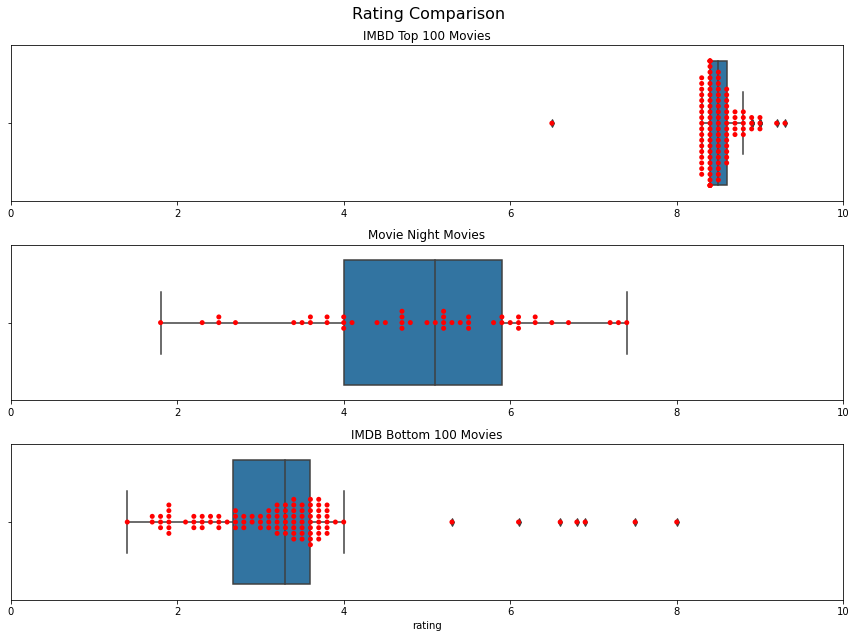

In [183]:
comparative_boxplot('rating', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[0,10], 
                    title='Rating Comparison', 
                    figure_name=False)

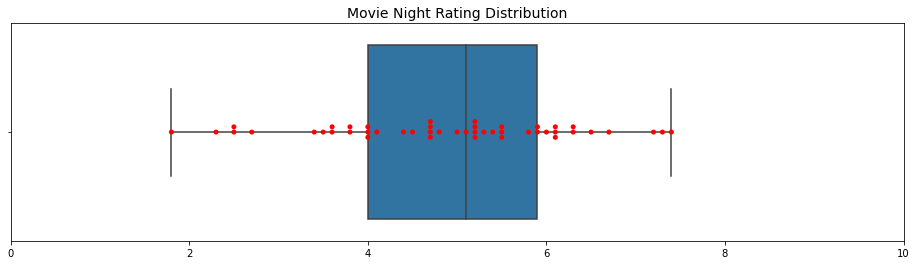

In [184]:
single_boxplot('rating', 
               movie_df, 
               plot_range=[0,10], 
               title='Movie Night Rating Distribution', 
               figure_name=False)

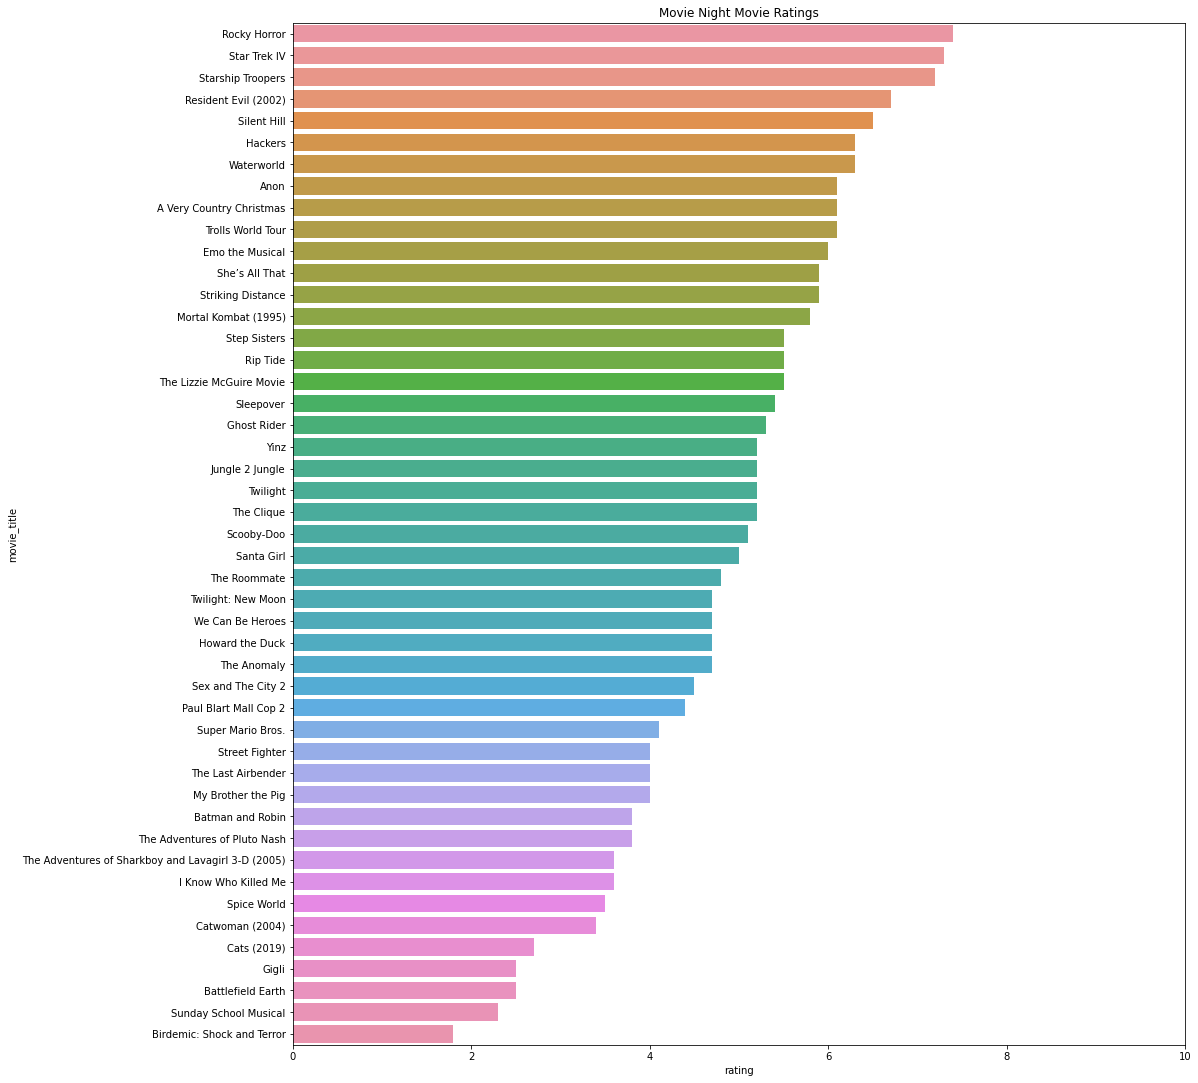

In [185]:
sorted_countplot('rating', 
                 movie_df, 
                 plot_range=[0,10], 
                 num_items=False, 
                 title='Movie Night Movie Ratings', 
                 figure_name=False, 
                 ascending=False)

In [186]:
print('Highest Rating:')
print(movie_df[movie_df['rating'] == max(movie_df['rating'])]['original_title'].values[0])
print(movie_df[movie_df['rating'] == max(movie_df['rating'])]['rating'].values[0])
print('\n')
print('Lowest Rating:')
print(movie_df[movie_df['rating'] == min(movie_df['rating'])]['original_title'].values[0])
print(movie_df[movie_df['rating'] == min(movie_df['rating'])]['rating'].values[0])
print('\n')
print('Average Rating:')
print(round(np.mean(movie_df['rating'].values), 1))

Highest Rating:
The Rocky Horror Picture Show (1975)
7.4


Lowest Rating:
Birdemic: Shock and Terror (2010)
1.8


Average Rating:
4.9


### Bottom 100 Ranking Movies

In [187]:
movie_df['bottom_100_rank'] = movie_df['bottom_100_rank'].apply(lambda x: 0 if x == '' else x)

In [188]:
print('Percentage of Movie Night Movies in the IMDB Bottom 100:')
print(str(round(len(movie_df[movie_df['bottom_100_rank'] > 0])/len(movie_df),2)*100) + '%')

Percentage of Movie Night Movies in the IMDB Bottom 100:
21.0%


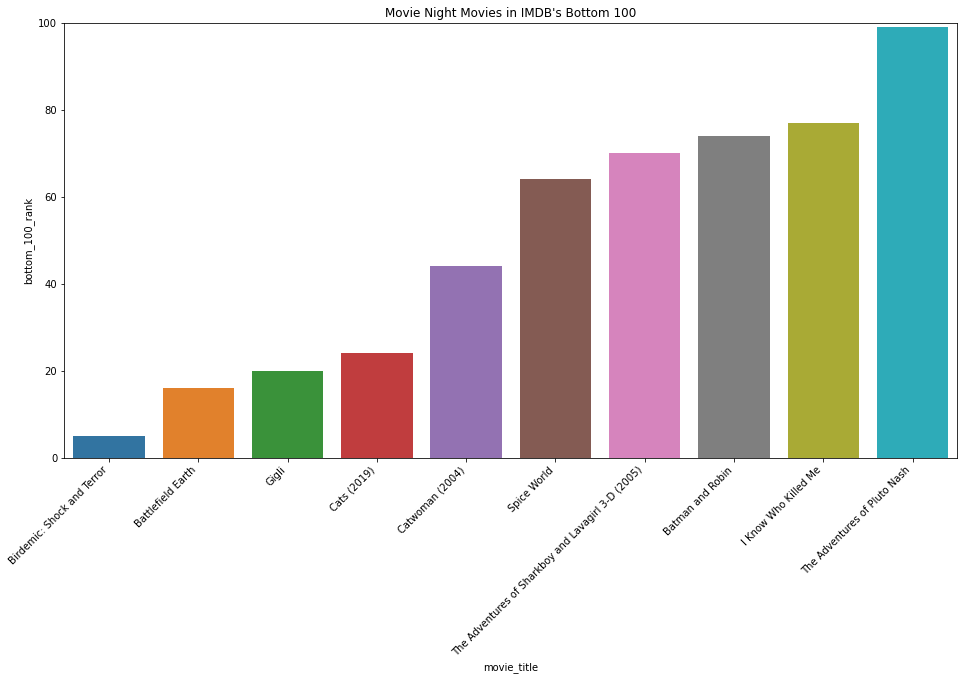

In [189]:
sorted_countplot('bottom_100_rank', 
                 movie_df[movie_df['bottom_100_rank'] > 0], 
                 plot_range=[0,100], 
                 num_items=False, 
                 title="Movie Night Movies in IMDB's Bottom 100", 
                 figure_name=False, 
                 ascending=True, 
                 horizontal=True)

### Runtime

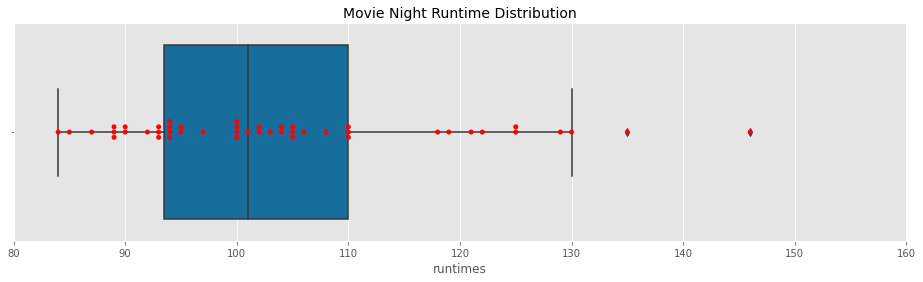

In [601]:
single_boxplot('runtimes', 
               movie_df, 
               plot_range=[80,160], 
               title='Movie Night Runtime Distribution', 
               figure_name='images/runtime_distribution.png')

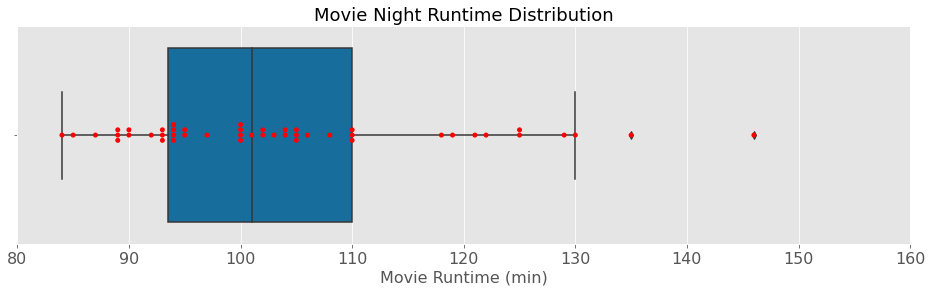

In [607]:
fig, ax = plt.subplots(figsize=(16,4))

sns.boxplot(ax=ax, x=movie_df['runtimes'].values)
sns.swarmplot(ax=ax, x=movie_df['runtimes'].values, color='r')
ax.set_xlim([80,160])

plt.title('Movie Night Runtime Distribution', fontsize=18)
plt.xlabel('Movie Runtime (min)', fontsize=16)
plt.xticks(fontsize=16)
        
plt.savefig('images/runtime_clean.png', bbox_inches='tight')
plt.show()

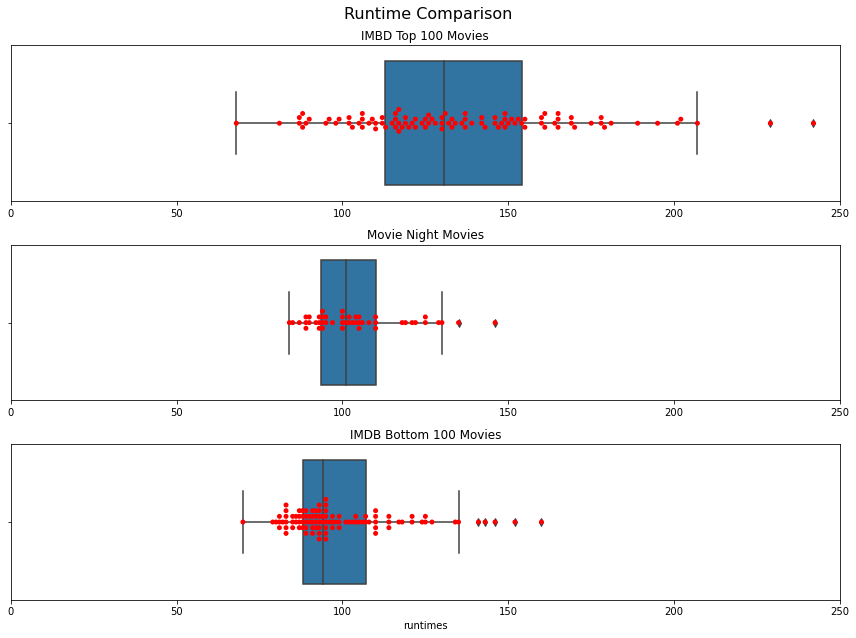

In [190]:
comparative_boxplot('runtimes', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[0,250], 
                    title='Runtime Comparison', 
                    figure_name=False)

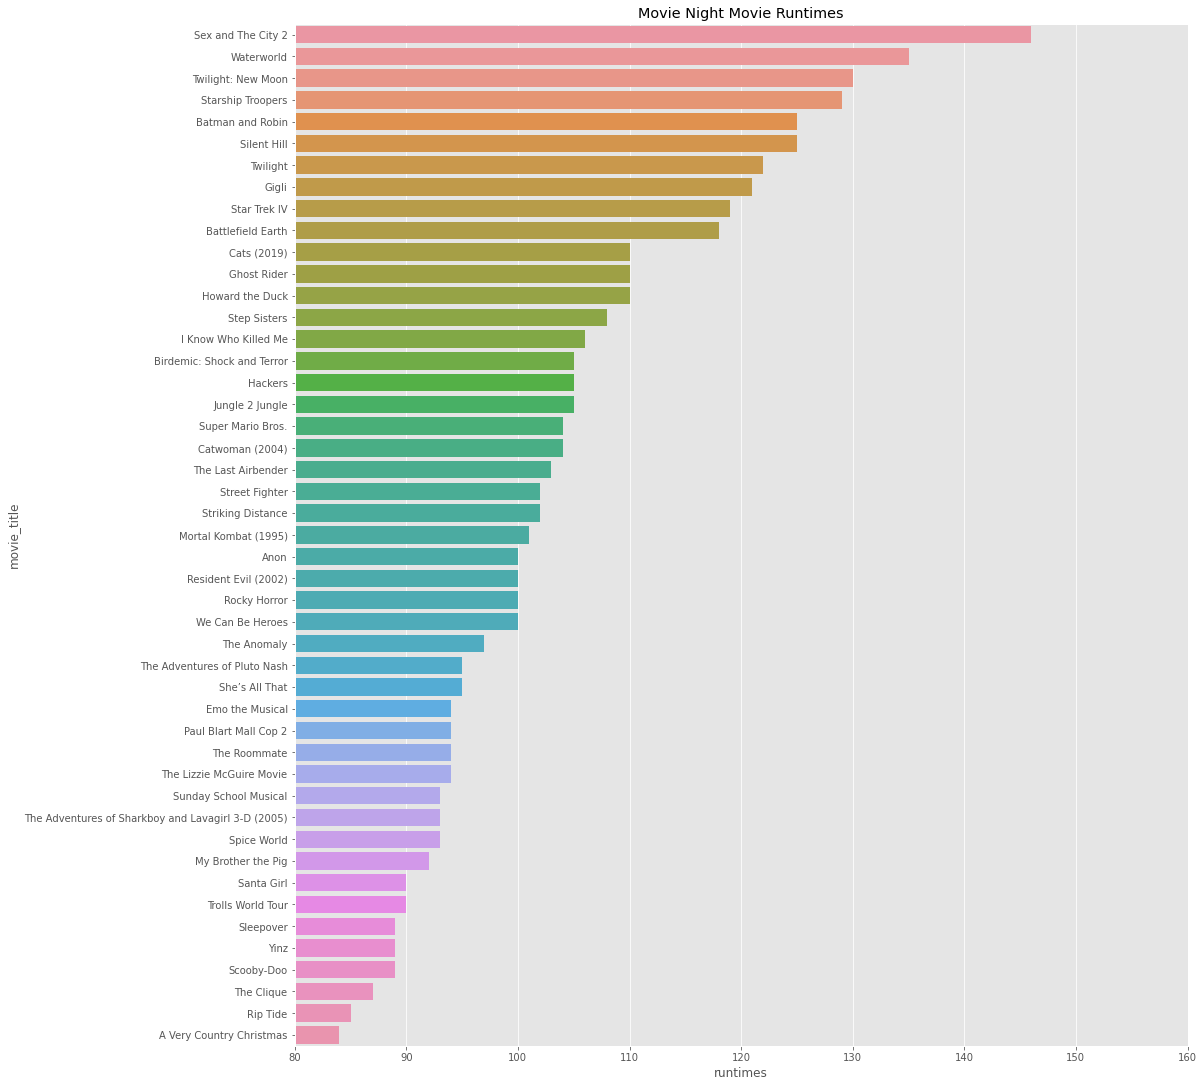

In [552]:
sorted_countplot('runtimes', 
                 movie_df, 
                 plot_range=[80,160], 
                 num_items=False, 
                 title='Movie Night Movie Runtimes', 
                 figure_name=False, 
                 ascending=False)

In [477]:
print('Longest Movie:')
print(movie_df[movie_df['runtimes'] == max(movie_df['runtimes'])]['movie_title'].values[0])
print(movie_df[movie_df['runtimes'] == max(movie_df['runtimes'])]['runtimes'].values[0], 'min')
print('\n')
print('Shortest Movie:')
print(movie_df[movie_df['runtimes'] == min(movie_df['runtimes'])]['movie_title'].values[0])
print(movie_df[movie_df['runtimes'] == min(movie_df['runtimes'])]['runtimes'].values[0], 'min')
print('\n')
print('Total Watching Time:')
print(round(sum(movie_df['runtimes'].values)/60, 2), 'hours')
print(round(sum(movie_df['runtimes'].values)/60/24, 2), 'days')

Longest Movie:
Sex and The City 2
146 min


Shortest Movie:
A Very Country Christmas
84 min


Total Watching Time:
81.37 hours
3.39 days


In [476]:
print('Average Runtime:')
print(round(np.mean(movie_df['runtimes'].values),0), 'minutes')

Average Runtime:
104.0 minutes


### Countries

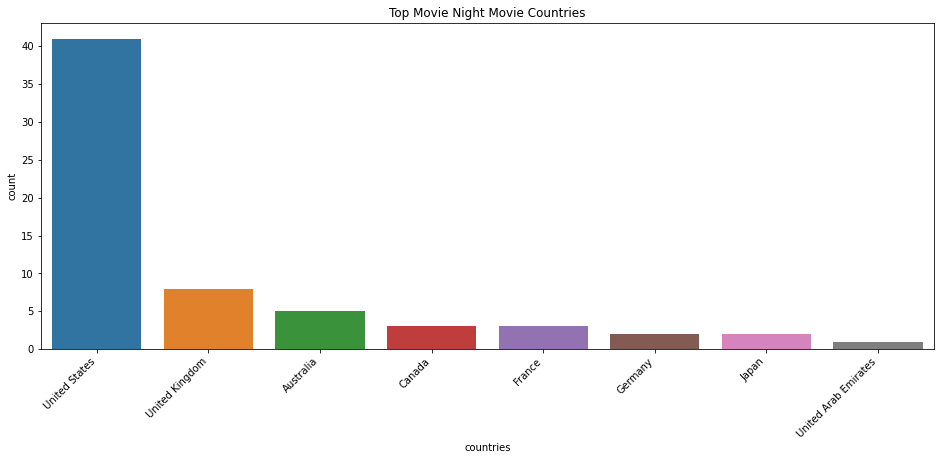

In [193]:
aggregate_countplot('countries',
                    movie_df, 
                    num_items=10, 
                    horizontal = True,
                    title='Top Movie Night Movie Countries', 
                    figure_name=False)

### Genres

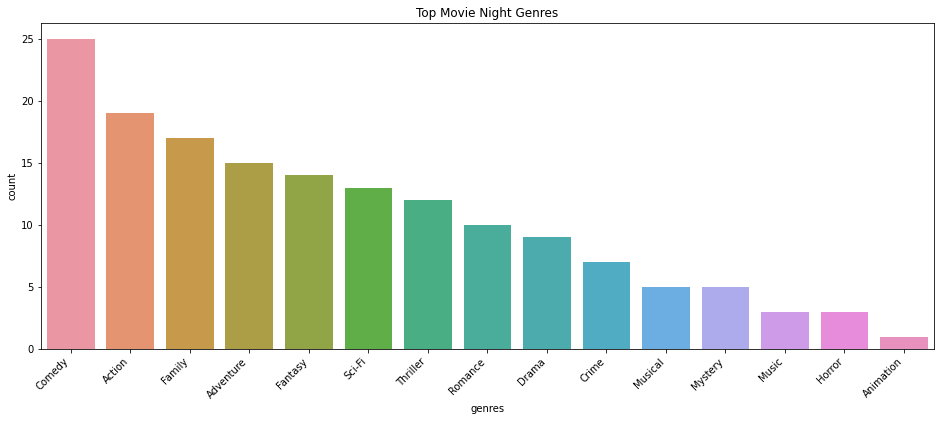

In [497]:
aggregate_countplot('genres',
                    movie_df, 
                    num_items=15, 
                    horizontal=True,
                    title='Top Movie Night Genres', 
                    figure_name='images/genre_chart.png')

In [594]:
sns.set_palette('colorblind')

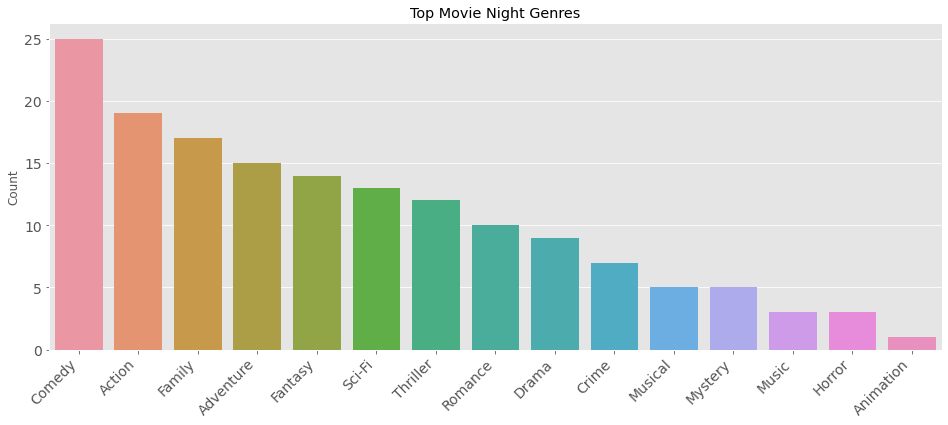

In [600]:
aggregate_df = pd.DataFrame(get_most_common('genres', movie_df), columns=['genres', 'count'])
aggregate_df = aggregate_df[aggregate_df['genres'] != '']
    
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x=aggregate_df['genres'], y=aggregate_df['count'])
sns.set_palette('colorblind')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.xlabel('')
plt.ylabel('Count')
plt.yticks(fontsize=14)
plt.title('Top Movie Night Genres')
plt.savefig('images/genre_clean.png', bbox_inches='tight')
plt.show()

In [ ]:
def aggregate_countplot(feature_name, df, num_items, plot_range=False, title=False, figure_name=False, horizontal=False):
    aggregate_df = pd.DataFrame(get_most_common(feature_name, df), columns=[feature_name, 'count'])
    aggregate_df = aggregate_df[aggregate_df[feature_name] != ''][:num_items]
    
    fig, ax = plt.subplots(figsize=(16,6))
    if horizontal:
        sns.barplot(x=aggregate_df[feature_name], y=aggregate_df['count'])
        if plot_range:
            plt.ylim(plot_range)
        plt.xticks(rotation=45, ha='right')
    else:
        sns.barplot(x=aggregate_df['count'], y=aggregate_df[feature_name])
        if plot_range:
            plt.xlim(plot_range)
        
    if title:
        plt.title(title)
        
    if figure_name:
        plt.savefig(figure_name + '.png')

### Year

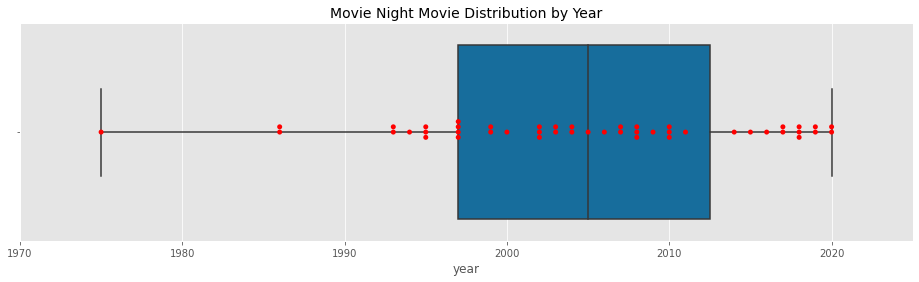

In [596]:
single_boxplot('year',
               movie_df, 
               plot_range=[1970, 2025],
               title='Movie Night Movie Distribution by Year')

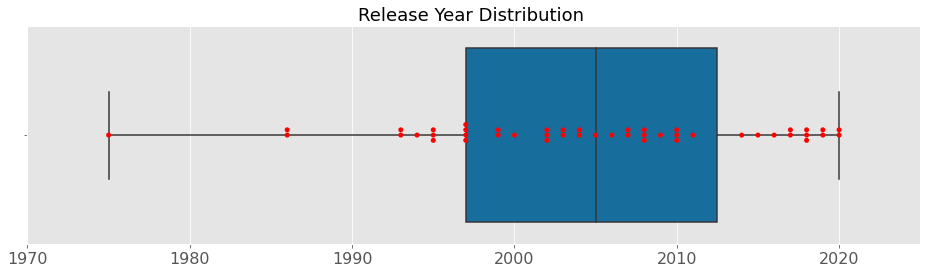

In [659]:
fig, ax = plt.subplots(figsize=(16,4))

sns.boxplot(ax=ax, x=movie_df['year'].values)
sns.swarmplot(ax=ax, x=movie_df['year'].values, color='r')
ax.set_xlim([1970,2025])

plt.title('Release Year Distribution ', fontsize=18)
plt.xlabel('')
plt.xticks(fontsize=16)
        
plt.savefig('images/year_clean.png', bbox_inches='tight')
plt.show()

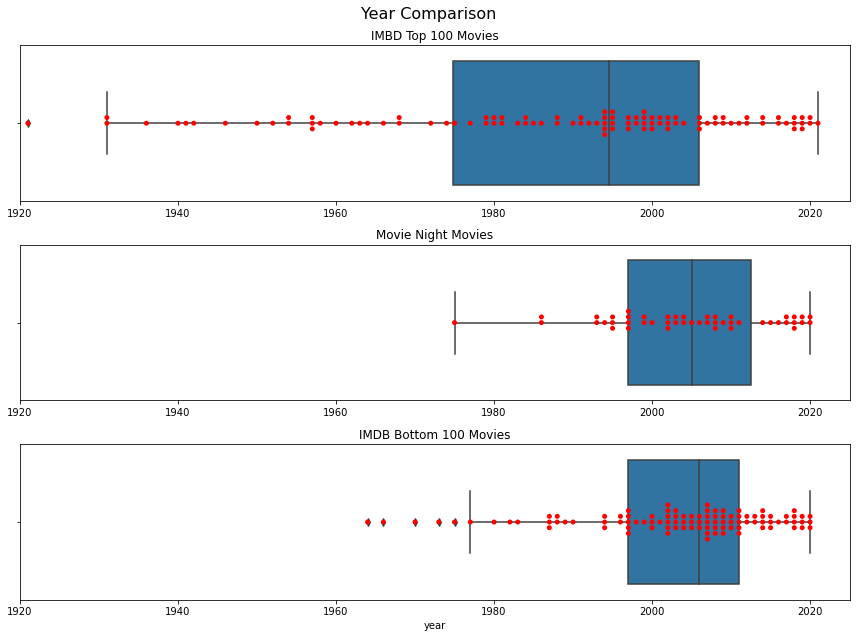

In [196]:
comparative_boxplot('year', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[1920,2025], 
                    title='Year Comparison', 
                    figure_name=False)

### AKAs

In [200]:
aka_list = [x.split(';') for x in movie_df['akas'].values]
aka_num = [len(x) for x in aka_list]
movie_title_list = movie_df['movie_title'].values.tolist()
expand_movie_title_list = []

for i in range(len(aka_num)):
    expand_movie_title_list.append(((movie_title_list[i] + '; ') * aka_num[i])[:-2])

expand_movie_title_list = [x.split(';') for x in expand_movie_title_list]

aka_list = [x for y in aka_list for x in y]
expand_movie_title_list = [x for y in expand_movie_title_list for x in y]
aka_list = [re.sub(r'\([^)]*\)', '', x) for x in aka_list]
aka_list = [x.strip() for x in aka_list]

In [201]:
import goslate
gs = goslate.Goslate()

In [203]:
aka_list_translated = [gs.translate(x, 'en') for x in aka_list]

In [204]:
translated_df = pd.DataFrame(list(zip(expand_movie_title_list, aka_list, aka_list_translated)), columns=['movie_title', 'aka', 'english_translation'])

In [205]:
translated_df

movie_title  \
0                                          Cats (2019)   
1                                          Cats (2019)   
2                                          Cats (2019)   
3                                          Cats (2019)   
4                                          Cats (2019)   
5                                      Emo the Musical   
6                                      Emo the Musical   
7                                      Emo the Musical   
8                                Sunday School Musical   
9                                Paul Blart Mall Cop 2   
10                               Paul Blart Mall Cop 2   
11                               Paul Blart Mall Cop 2   
12                               Paul Blart Mall Cop 2   
13                               Paul Blart Mall Cop 2   
14                                          Waterworld   
15                                          Waterworld   
16                                          Waterworld   
17                                          Waterworld   
18                                          Waterworld   
19                                   Battlefield Earth   
20                                   Battlefield Earth   
21                                   Battlefield Earth   
22                                   Battlefield Earth   
23                                   Battlefield Earth   
24                                   Striking Distance   
25                                   Striking Distance   
26                                   Striking Distance   
27                                   Striking Distance   
28                                   Striking Distance   
29                                            Twilight   
30                                            Twilight   
31                                            Twilight   
32                                            Twilight   
33                                            Twilight   
34                                  Twilight: New Moon   
35                                  Twilight: New Moon   
36                                  Twilight: New Moon   
37                                  Twilight: New Moon   
38                                  Twilight: New Moon   
39                            The Lizzie McGuire Movie   
40                            The Lizzie McGuire Movie   
41                            The Lizzie McGuire Movie   
42                            The Lizzie McGuire Movie   
43                            The Lizzie McGuire Movie   
44                                               Gigli   
45                                               Gigli   
46                                               Gigli   
47                                               Gigli   
48                                               Gigli   
49                                                Anon   
50                                                Anon   
51                                                Anon   
52                                                Anon   
53                                                Anon   
54                                        Step Sisters   
55                                        Step Sisters   
56                                        Step Sisters   
57                                        Step Sisters   
58                                            Rip Tide   
59                                            Rip Tide   
60                                            Rip Tide   
61                                            Rip Tide   
62                                            Rip Tide   
63                                   Starship Troopers   
64                                   Starship Troopers   
65                                   Starship Troopers   
66                                   Starship Troopers   
67                                   Starship Troopers   
68                                       

### Plot

# Movie People

* Cast
* Directors
* Writers
* Producers
* Composers
* Cinematographers
* Editors
* Editorial Department
* Casting Drectors
* Production Designers
* Art Drectors
* Set Decorators
* Costume Designers
* Make up Department
* Production Managers
* Assistant Directors
* Art Department
* Sound Department
* Special Efects
* Visual Efects
* Stunts
* Camera Department
* Animation Department
* Casting Department
* Costume Department
* Location Management
* Music Department
* Script Department
* Transportation Department
* Miscellaneous

### Cast

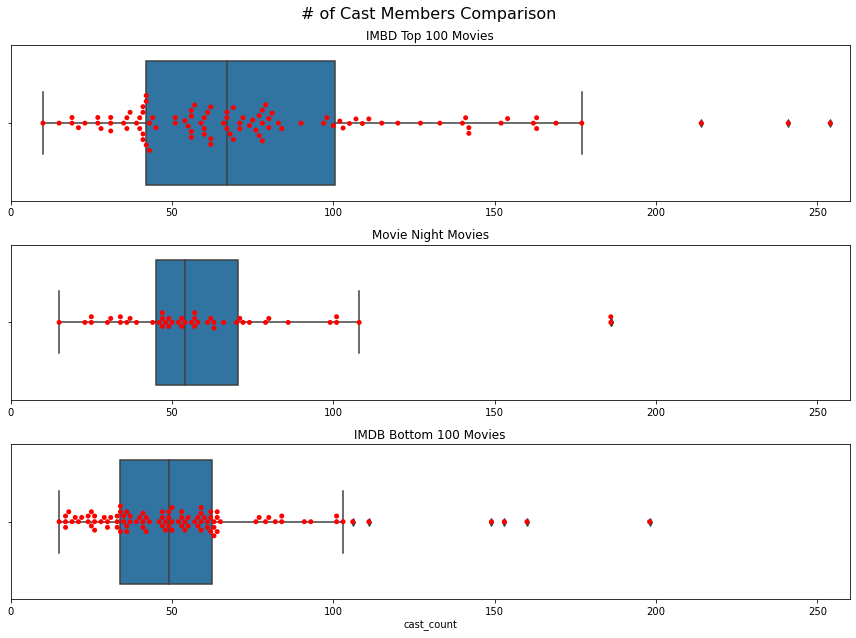

In [206]:
comparative_boxplot('cast_count', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[0,260], 
                    title='# of Cast Members Comparison', 
                    figure_name=False)

In [207]:
print('Largest Cast Size:')
print(movie_df[movie_df['cast_count'] == max(movie_df['cast_count'])]['movie_title'].values)
print(movie_df[movie_df['cast_count'] == max(movie_df['cast_count'])]['cast_count'].values)
print('\n')
print('Smallest Cast Size:')
print(movie_df[movie_df['cast_count'] == min(movie_df['cast_count'])]['movie_title'].values[0])
print(movie_df[movie_df['cast_count'] == min(movie_df['cast_count'])]['cast_count'].values[0])
print('\n')
print('Average Cast Size:')
print(int(np.mean(movie_df['cast_count'].values)))

Largest Cast Size:
['Paul Blart Mall Cop 2' 'Sex and The City 2']
[186 186]


Smallest Cast Size:
Yinz
15


Average Cast Size:
61


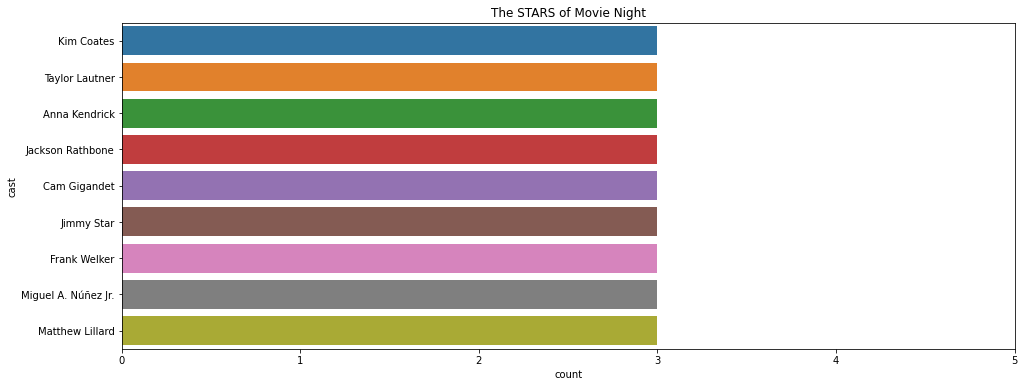

In [512]:
aggregate_countplot('cast', 
                    movie_df, 
                    num_items=9, 
                    plot_range=[0,5], 
                    title='The STARS of Movie Night', 
                    figure_name=False,
                    horizontal=False)

In [510]:
top_stars = ['Kim Coates', 'Taylor Lautner', 'Anna Kendrick', 'Jackson Rathbone', 'Cam Gigandet', 'Jimmy Star',
             'Frank Welker', 'Miguel A. Núñez Jr.', 'Matthew Lillard']

In [511]:
for star in top_stars:
    print(star)
    print(movie_df[movie_df['cast'].str.contains(star)]['original_title'].values)
    print('\n')

Kim Coates
['Waterworld (1995)' 'Battlefield Earth (2000)' 'Silent Hill (2006)']


Taylor Lautner
['Twilight (2008)' 'The Twilight Saga: New Moon (2009)'
 'The Adventures of Sharkboy and Lavagirl 3-D (2005)']


Anna Kendrick
['Twilight (2008)' 'The Twilight Saga: New Moon (2009)'
 'Trolls World Tour (2020)']


Jackson Rathbone
['Twilight (2008)' 'The Twilight Saga: New Moon (2009)'
 'The Last Airbender (2010)']


Cam Gigandet
['Twilight (2008)' 'The Twilight Saga: New Moon (2009)'
 'The Roommate (2011)']


Jimmy Star
['Twilight (2008)' 'The Twilight Saga: New Moon (2009)'
 'Starship Troopers (1997)']


Frank Welker
['Mortal Kombat (1995)' 'Scooby-Doo (2002)' 'Super Mario Bros. (1993)']


Miguel A. Núñez Jr.
['The Adventures of Pluto Nash (2002)' 'Scooby-Doo (2002)'
 'Street Fighter (1994)']


Matthew Lillard
['Scooby-Doo (2002)' "She's All That (1999)" 'Hackers (1995)']




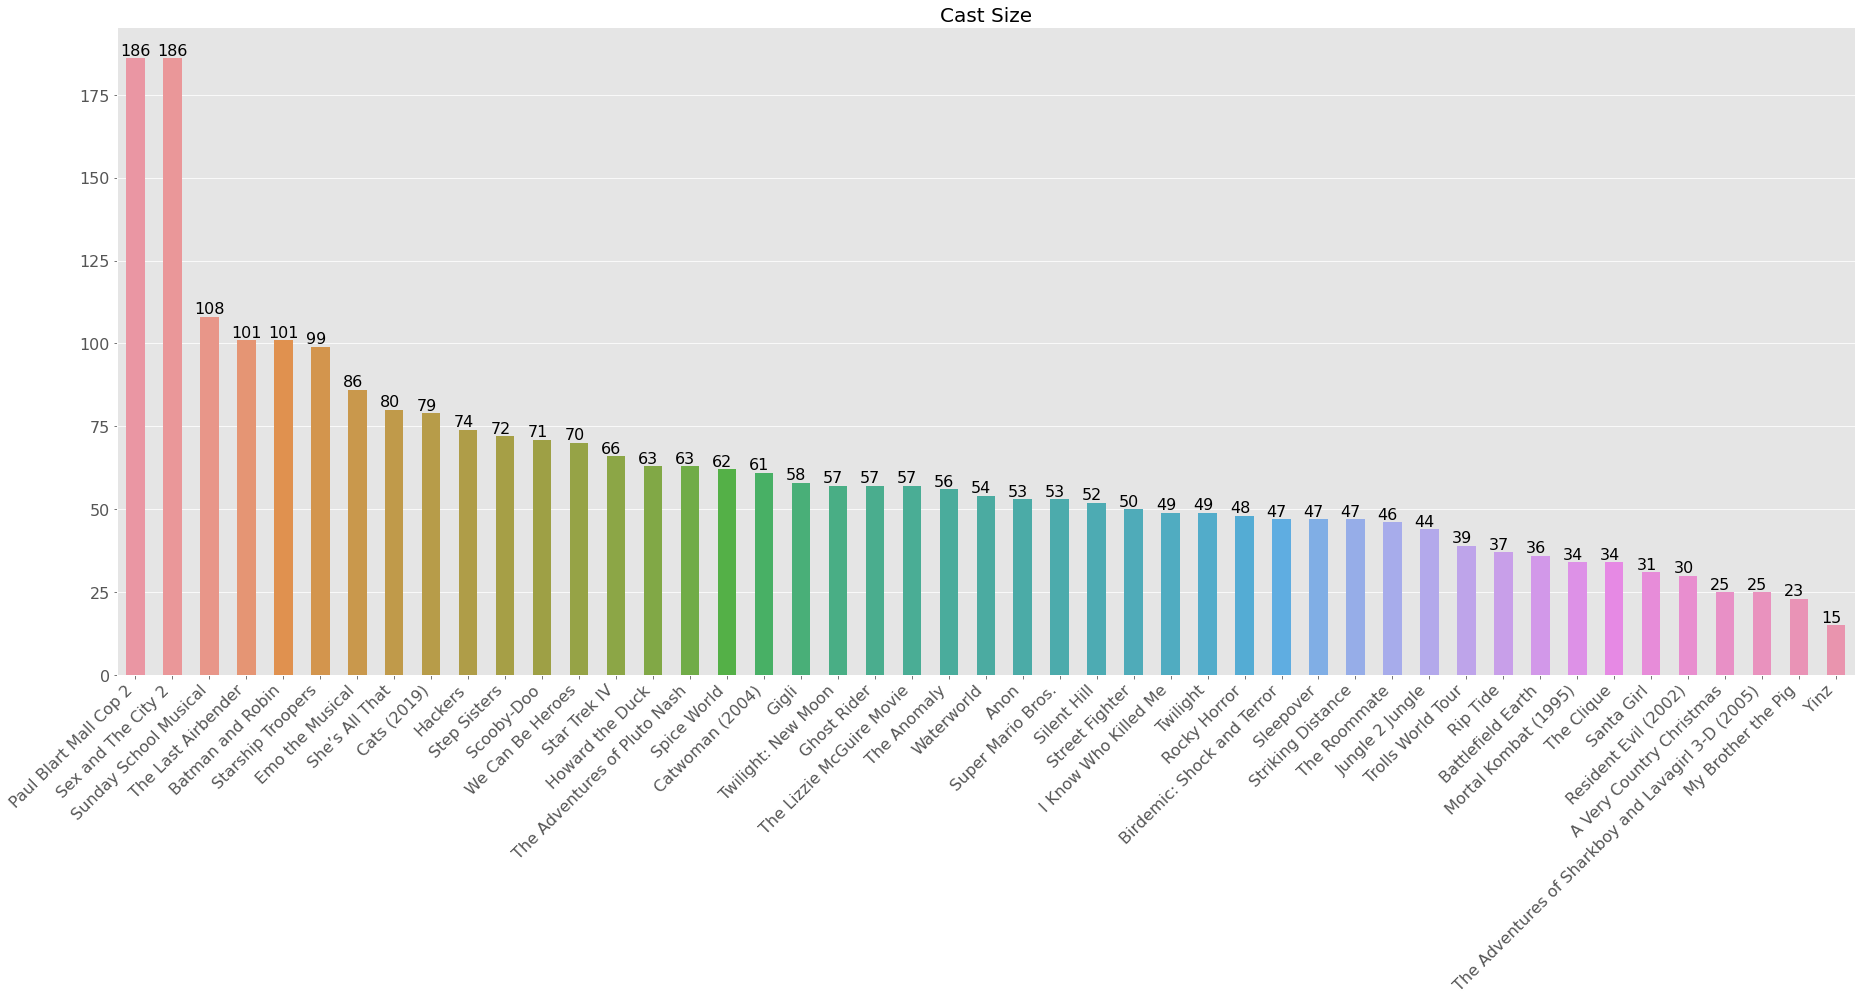

In [658]:
cast_sorted = movie_df.sort_values(by='cast_count', ascending=False).reset_index(drop=True)
cast_sorted = cast_sorted[(cast_sorted['cast_count'] != 0) & (cast_sorted['cast_count'] != 0.0)]


fig, ax = plt.subplots(figsize=(26,14))
sns.barplot(x=cast_sorted['movie_title'], y=cast_sorted['cast_count'])
plt.title('Cast Size', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
# fmt = '${x:,.0f}'
# ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')

i=0
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height() + 1
    ax.annotate(cast_sorted['cast_count'].values[i], (x, y), size = 16)
    i += 1


def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .5)

plt.tight_layout()
plt.savefig('images/cast_clean.png', bbox_inches='tight')

In [ ]:
budget_sorted = movie_df.sort_values(by='budget_imdb_adj_2021', ascending=False).reset_index(drop=True)
budget_sorted = budget_sorted[(budget_sorted['budget_imdb_adj_2021'] != 0) & (budget_sorted['budget_imdb_adj_2021'] != 0.0)]

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=budget_sorted['budget_imdb_adj_2021'], y=budget_sorted['movie_title'])
plt.title('Movie Night Movie Cast Size)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 1),
                xytext=(5, 10), textcoords='offset points')
plt.savefig('images/budget_clean.png', bbox_inches='tight')
plt.show()

### Writers

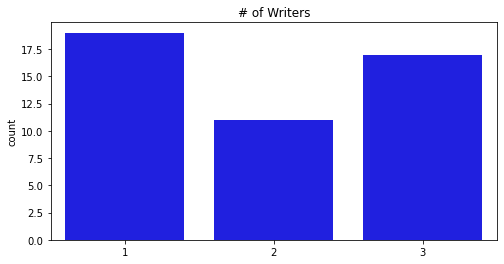

In [209]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['writer_count'].values, color='blue')
plt.title('# of Writers')
plt.show()

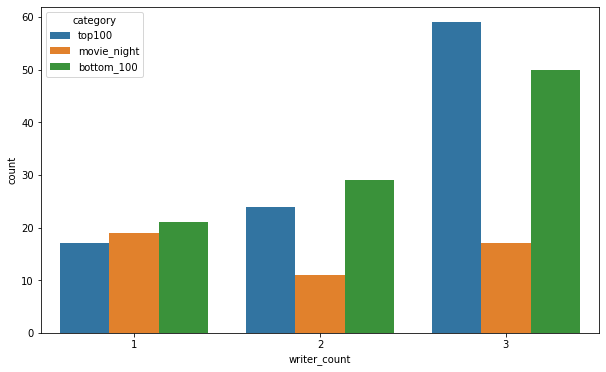

In [210]:
comparative_countplot('writer_count', top100_df, movie_df, bottom100_df)

### Directors

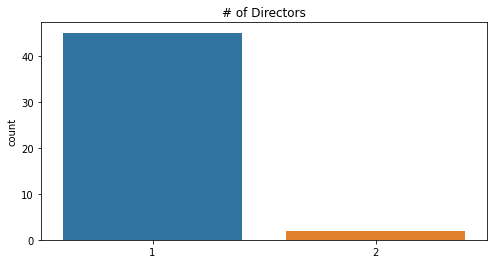

In [211]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['director_count'].values)
plt.title('# of Directors')
plt.show()

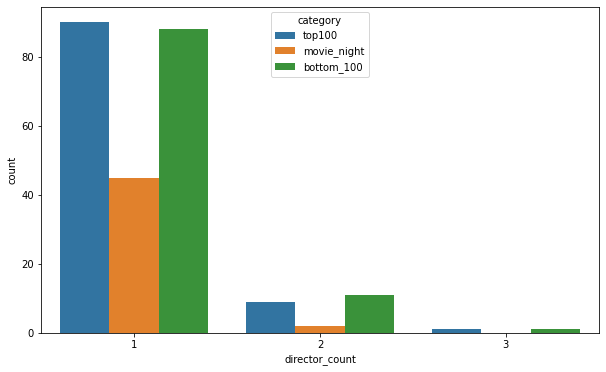

In [212]:
comparative_countplot('director_count', top100_df, movie_df, bottom100_df)

In [213]:
print('Movies With Multiple Directors:')
print(movie_df[movie_df['director_count'] > 1]['movie_title'].values)

Movies With Multiple Directors:
['Super Mario Bros.' 'Trolls World Tour']


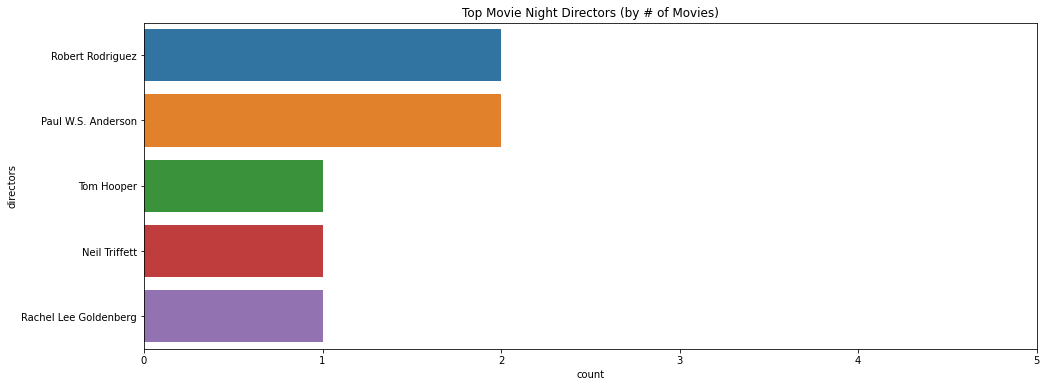

In [214]:
aggregate_countplot('directors', 
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5], 
                    title='Top Movie Night Directors (by # of Movies)', 
                    figure_name=False,
                    horizontal=False)

### Producers

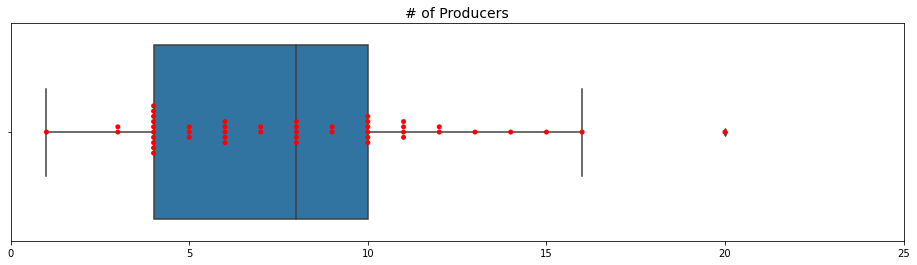

In [215]:
single_boxplot('producers_count',
               movie_df,
               plot_range=[0,25],
               title='# of Producers')

# fig, ax = plt.subplots(figsize=(8,4))
# ax = sns.boxplot(x=movie_df['producers_count'].values)
# ax = sns.swarmplot(x=movie_df['producers_count'].values, color='r')
# plt.title('# of Producers')
# plt.show()

In [216]:
print('Most Producers:')
print(movie_df[movie_df['producers_count'] == max(movie_df['producers_count'])]['movie_title'].values[0])
print(movie_df[movie_df['producers_count'] == max(movie_df['producers_count'])]['producers_count'].values[0])
print('\n')
print('Fewest Producers:')
print(movie_df[movie_df['producers_count'] == min(movie_df['producers_count'])]['movie_title'].values[0])
print(movie_df[movie_df['producers_count'] == min(movie_df['producers_count'])]['producers_count'].values[0])
print('\n')
print('Average # of Producers:')
print(int(np.mean(movie_df['producers_count'].values)))

Most Producers:
The Anomaly
20


Fewest Producers:
Birdemic: Shock and Terror
1


Average # of Producers:
7


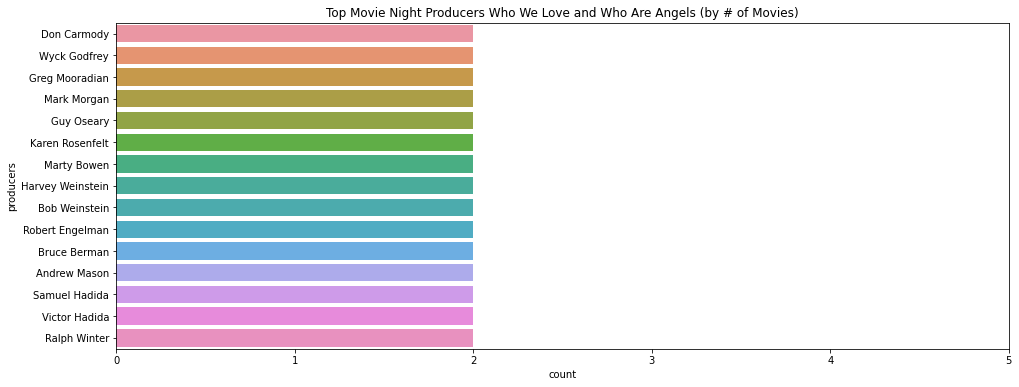

In [217]:
aggregate_countplot('producers', 
                    movie_df, 
                    num_items=15, 
                    plot_range=[0,5], 
                    title='Top Movie Night Producers Who We Love and Who Are Angels (by # of Movies)', 
                    figure_name=False,
                    horizontal=False)

### Composers

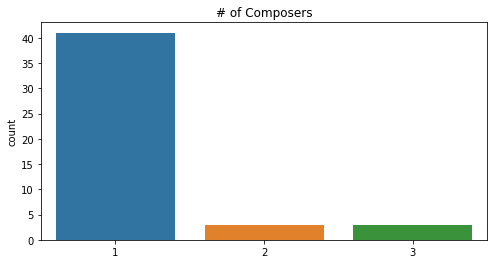

In [218]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['composers_count'].values)
plt.title('# of Composers')
plt.show()

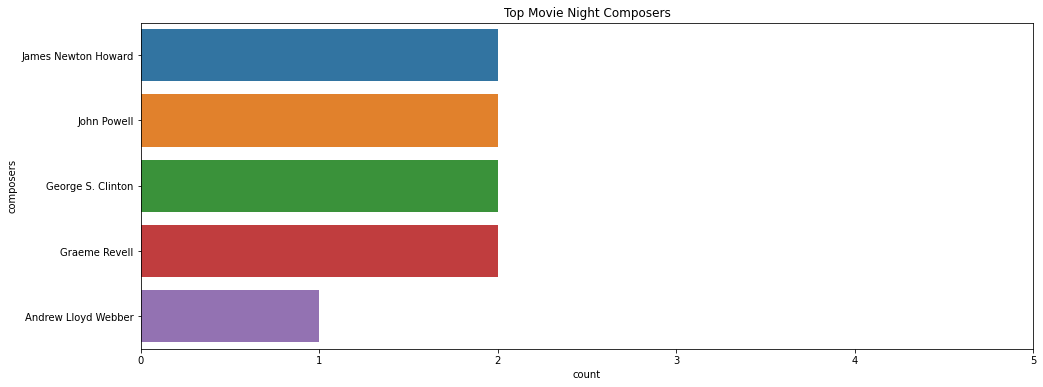

In [219]:
aggregate_countplot('composers',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Composers', 
                    figure_name=False)

### Cinematographers

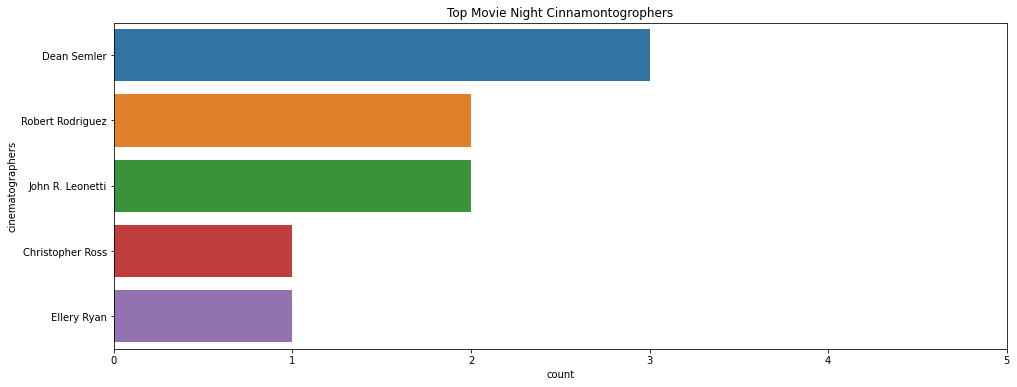

In [220]:
aggregate_countplot('cinematographers',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Cinnamontogrophers', 
                    figure_name=False)

In [526]:
print(movie_df[movie_df['cinematographers'].str.contains('Dean Semler')]['original_title'].values)

['Paul Blart: Mall Cop 2 (2015)' 'Waterworld (1995)'
 'Super Mario Bros. (1993)']


### Editors

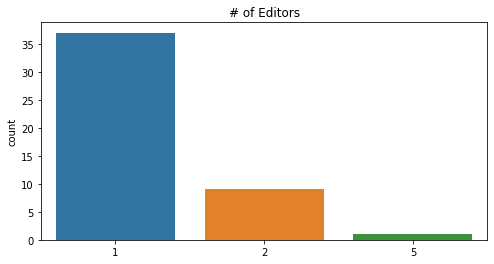

In [221]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['editors_count'].values)
plt.title('# of Editors')
plt.show()

In [222]:
# Over the past two decades, 77% of films released in the United States only had one film editor. 
# In the decade and a half between 1997 and 2011, between 81% and 75% of films credited one editor only. 
# However, by 2016, the number of single editor films had dropped to 68%!  

# https://www.quickclass.net/2017/03/21/many-editors-make-movie/#:~:text=In%202016%2C%20roughly%209%25%20of,directors%2C%20often%20also%20shifting%20narrative.

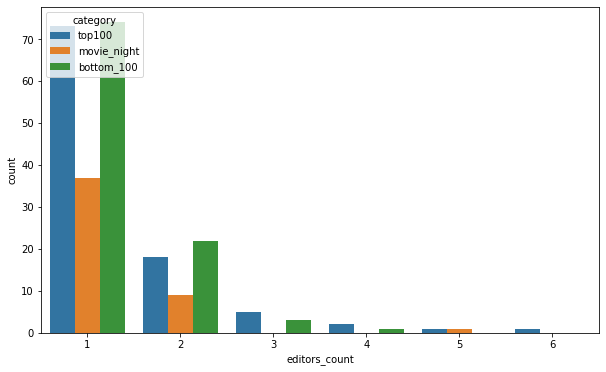

In [223]:
comparative_countplot('editors_count', top100_df, movie_df, bottom100_df)

In [224]:
print('Two-Editor Movies:')
for movie in movie_df[movie_df['editors_count'] == 2]['movie_title'].values:
    print('\t' + movie)

Two-Editor Movies:
	Sunday School Musical
	Striking Distance
	Gigli
	Starship Troopers
	The Adventures of Pluto Nash
	The Anomaly
	Howard the Duck
	Hackers
	Batman and Robin


In [225]:
print('Five-Editor Movies:')
print('\t' + movie_df[movie_df['editors_count'] == 5]['movie_title'].values[0])

Five-Editor Movies:
	Street Fighter


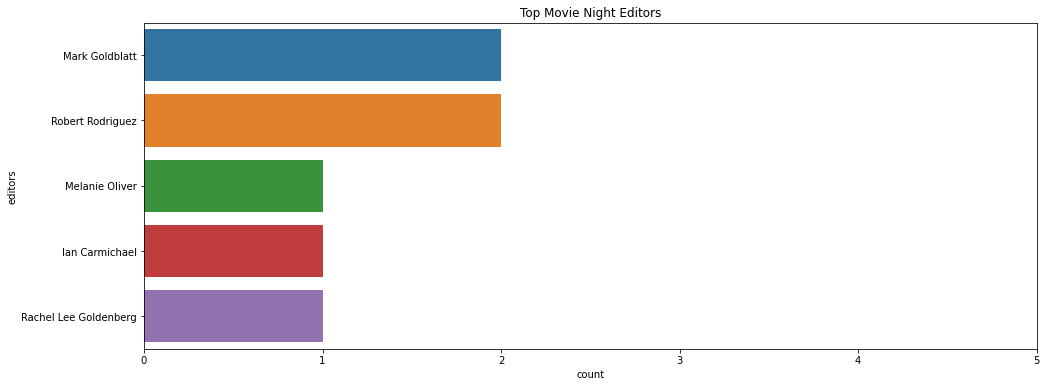

In [226]:
aggregate_countplot('editors',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Editors', 
                    figure_name=False)

### Editorial Department

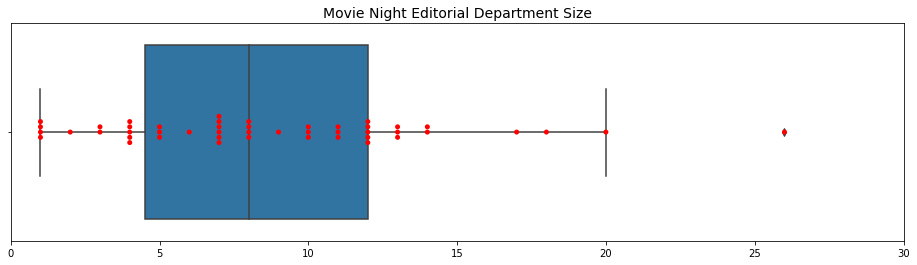

In [227]:
single_boxplot('editorial_department_count',
              movie_df,
              plot_range=[0,30], 
              title='Movie Night Editorial Department Size')


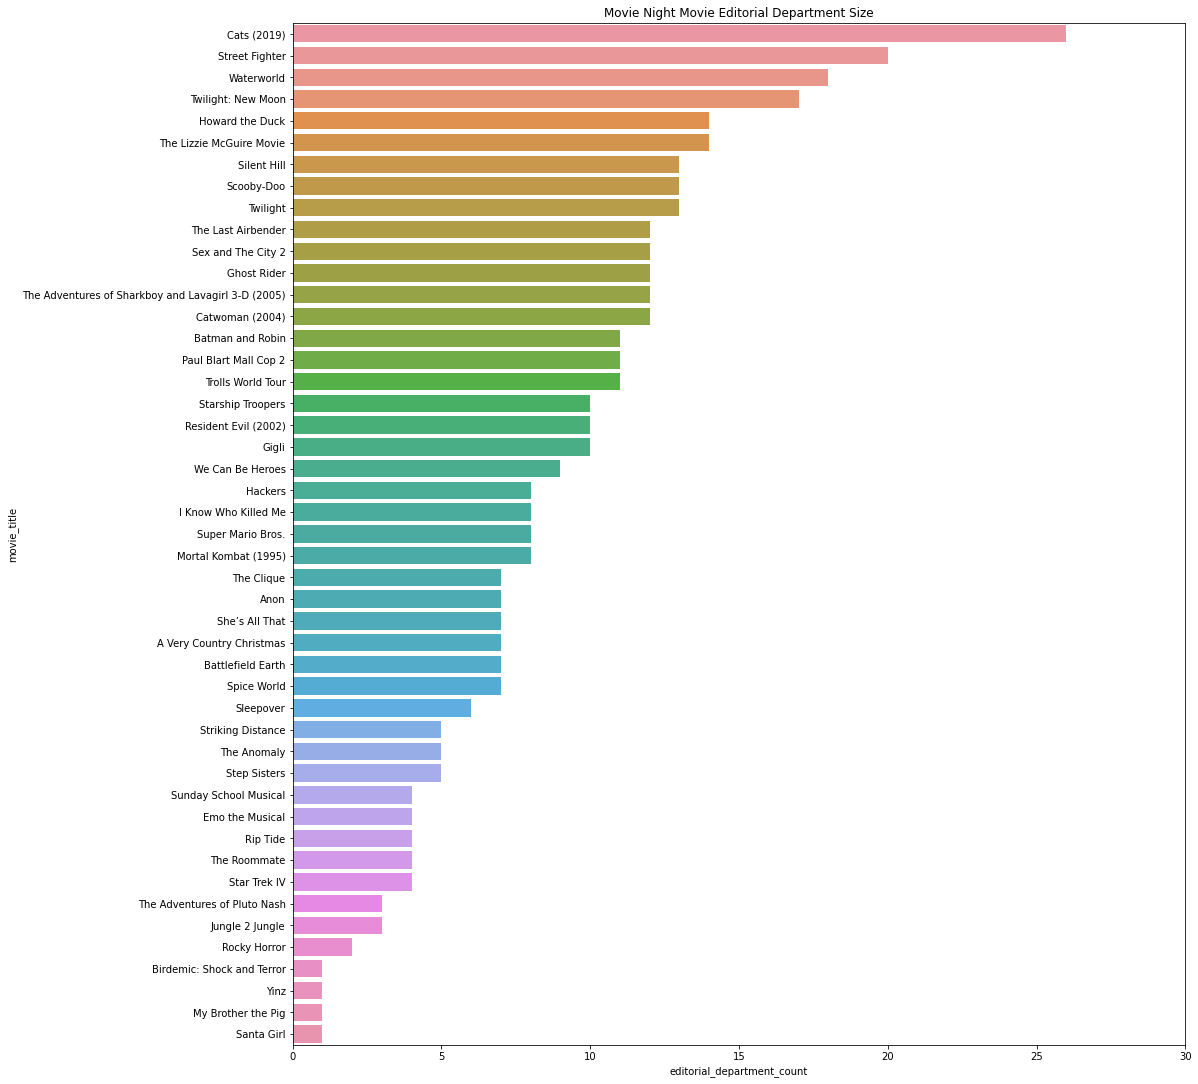

In [228]:
sorted_countplot('editorial_department_count', 
                 movie_df, 
                 plot_range=[0,30], 
                 num_items=False, 
                 title='Movie Night Movie Editorial Department Size', 
                 figure_name=False, 
                 ascending=False)

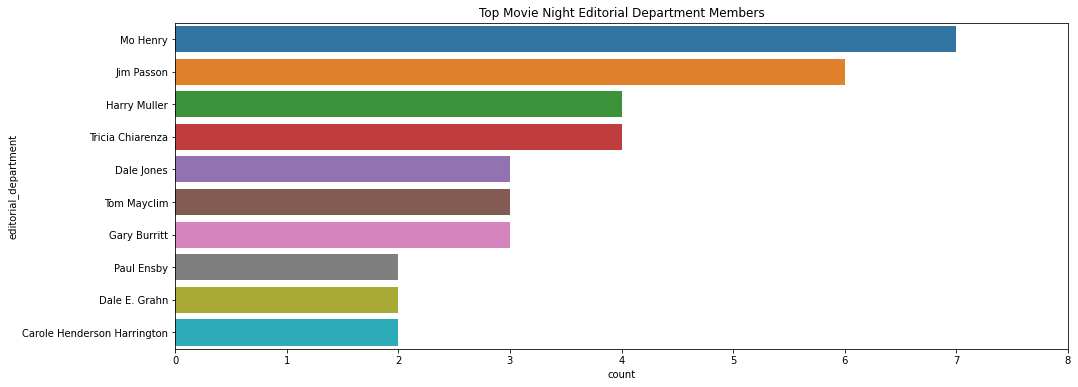

In [229]:
aggregate_countplot('editorial_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,8],
                    title='Top Movie Night Editorial Department Members', 
                    figure_name=False)

In [529]:
print(movie_df[movie_df['editorial_department'].str.contains('Mo Henry')]['original_title'].values)

['Gigli (2003)' 'Starship Troopers (1997)'
 'The Adventures of Sharkboy and Lavagirl 3-D (2005)' 'Ghost Rider (2007)'
 'Scooby-Doo (2002)' 'Batman & Robin (1997)' 'Catwoman (2004)']


In [530]:
print(movie_df[movie_df['editorial_department'].str.contains('Jim Passon')]['original_title'].values)

['Waterworld (1995)' 'Gigli (2003)' 'The Last Airbender (2010)'
 'The Adventures of Sharkboy and Lavagirl 3-D (2005)' 'Ghost Rider (2007)'
 'Sex and the City 2 (2010)']


### Casting Directors

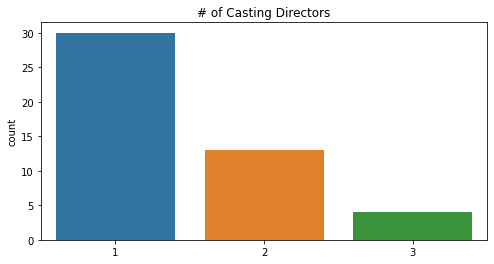

In [230]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['casting_directors_count'].values)
plt.title('# of Casting Directors')
plt.show()

In [231]:
print('Movies with Three Casting Directors:')
for item in movie_df[movie_df['casting_directors_count'] == 3]['movie_title'].values:
    print('\t' + item)

Movies with Three Casting Directors:
	Twilight: New Moon
	Anon
	Mortal Kombat (1995)
	Ghost Rider


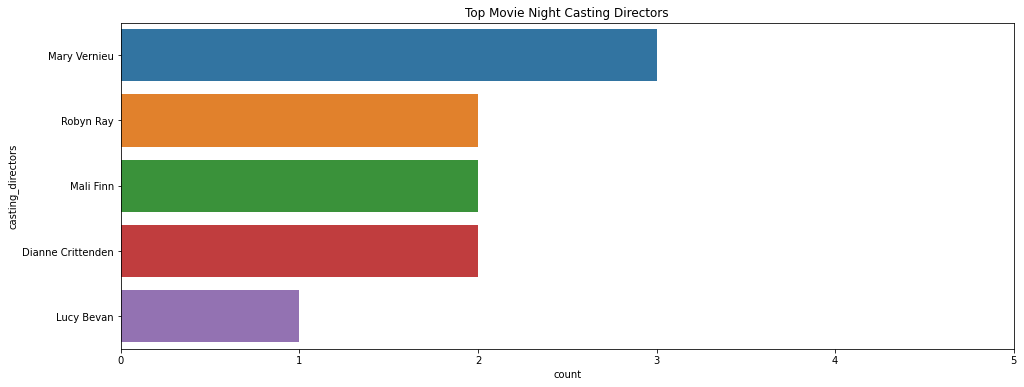

In [232]:
aggregate_countplot('casting_directors',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Casting Directors', 
                    figure_name=False)

In [532]:
print(movie_df[movie_df['casting_directors'].str.contains('Mary Vernieu')]['original_title'].values)

['The Adventures of Sharkboy and Lavagirl 3-D (2005)' 'Scooby-Doo (2002)'
 'We Can Be Heroes (2020)']


### Production Designers

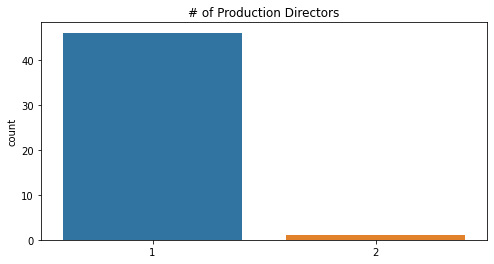

In [233]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['production_designers_count'].values)
plt.title('# of Production Directors')
plt.show()

In [234]:
print('Movies with more than one production designer:')
print('\t' + movie_df[movie_df['production_designers_count'] > 1]['movie_title'].values[0])

Movies with more than one production designer:
	Step Sisters


### Art Directors

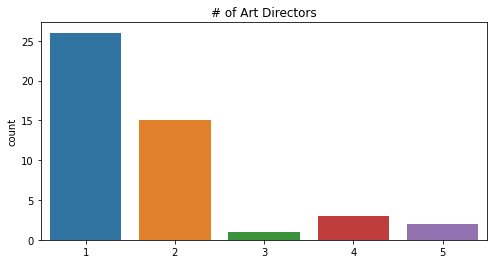

In [235]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['art_directors_count'].values)
plt.title('# of Art Directors')
plt.show()

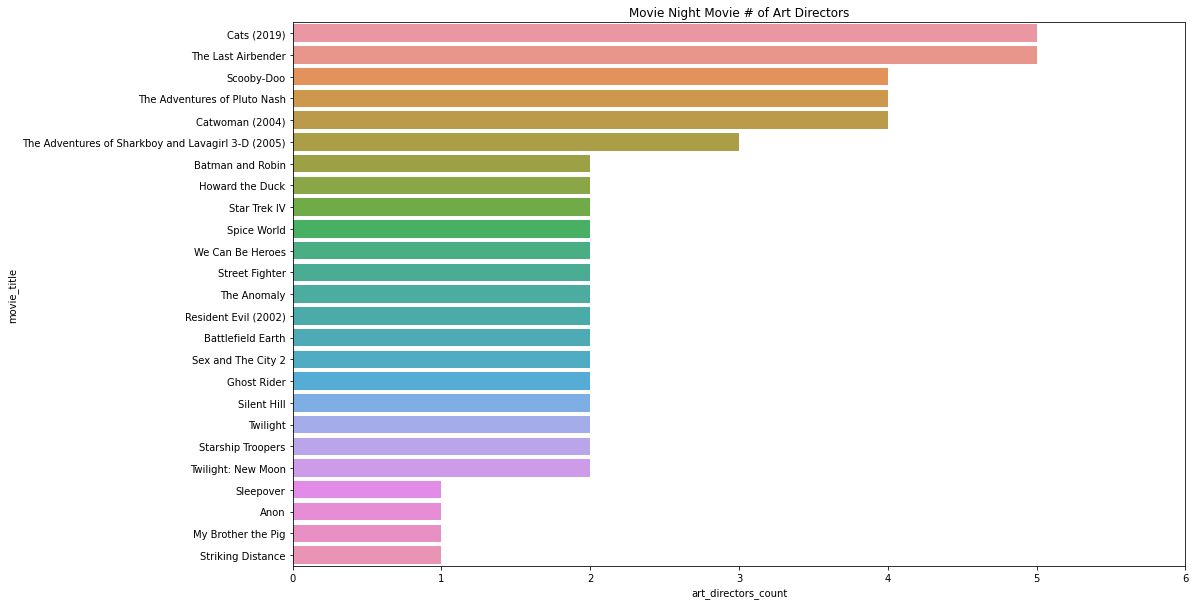

In [236]:
sorted_countplot('art_directors_count', 
                 movie_df, 
                 plot_range=[0,6], 
                 num_items=25, 
                 title='Movie Night Movie # of Art Directors', 
                 figure_name=False, 
                 ascending=False)

### Set Decorators

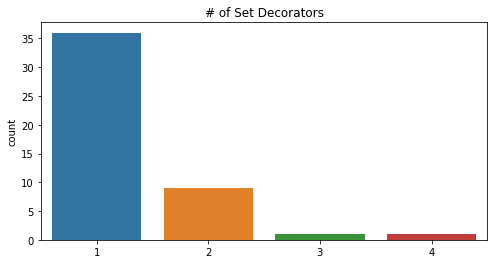

In [237]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['set_decorators_count'].values)
plt.title('# of Set Decorators')
plt.show()

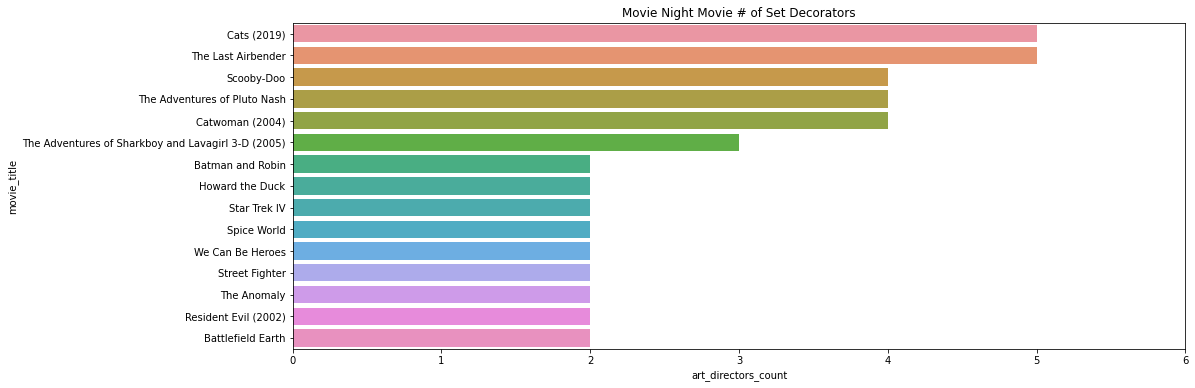

In [238]:
sorted_countplot('art_directors_count', 
                 movie_df, 
                 plot_range=[0,6], 
                 num_items=15, 
                 title='Movie Night Movie # of Set Decorators', 
                 figure_name=False, 
                 ascending=False)

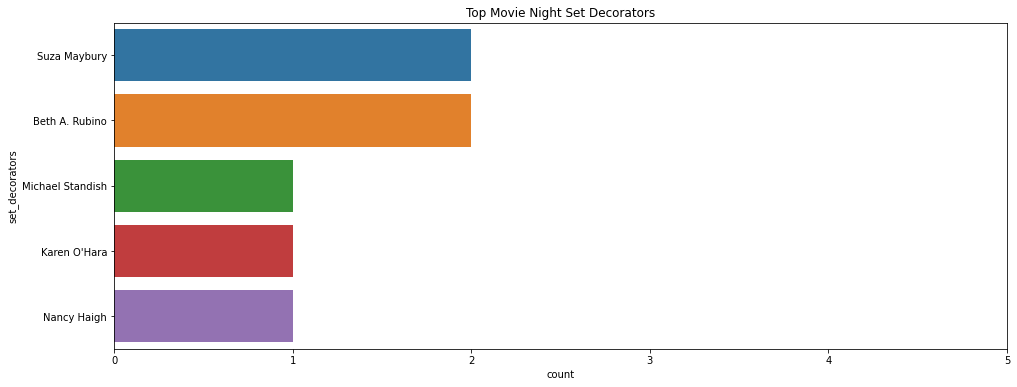

In [239]:
aggregate_countplot('set_decorators',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Set Decorators', 
                    figure_name=False)

### Costumer Designers

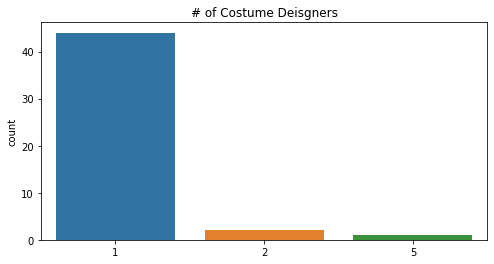

In [240]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['costume_designers_count'].values)
plt.title('# of Costume Deisgners')
plt.show()

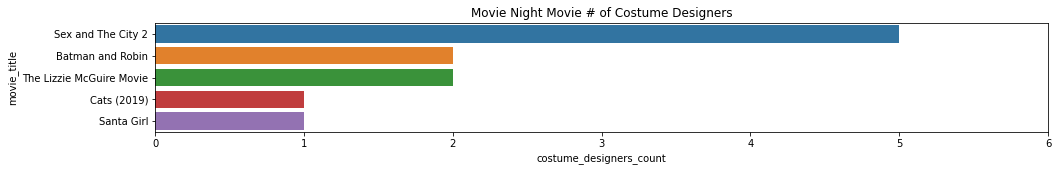

In [241]:
sorted_countplot('costume_designers_count', 
                 movie_df, 
                 plot_range=[0,6], 
                 num_items=5, 
                 title='Movie Night Movie # of Costume Designers', 
                 figure_name=False, 
                 ascending=False)

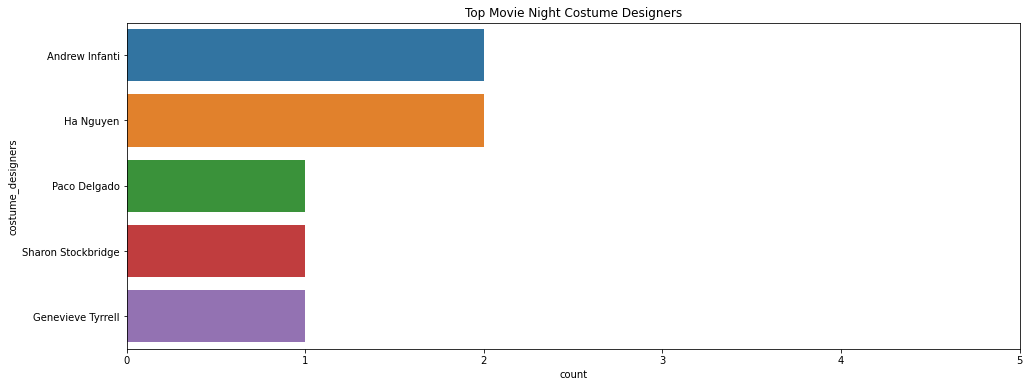

In [242]:
aggregate_countplot('costume_designers',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Costume Designers', 
                    figure_name=False)

### Make-Up Department

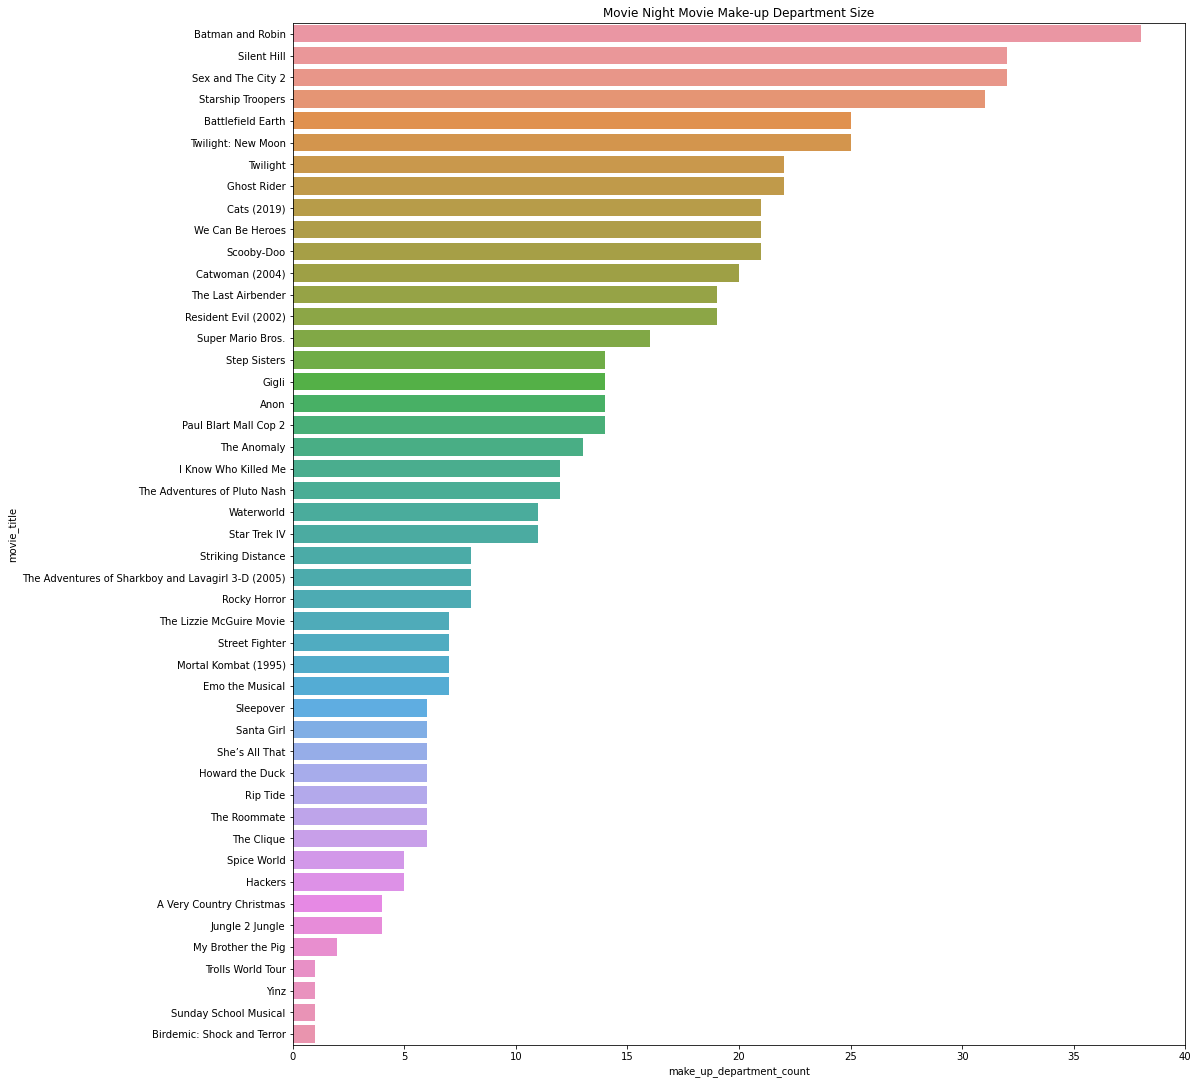

In [243]:
sorted_countplot('make_up_department_count', 
                 movie_df, 
                 plot_range=[0,40], 
                 num_items=False, 
                 title='Movie Night Movie Make-up Department Size', 
                 figure_name=False, 
                 ascending=False)

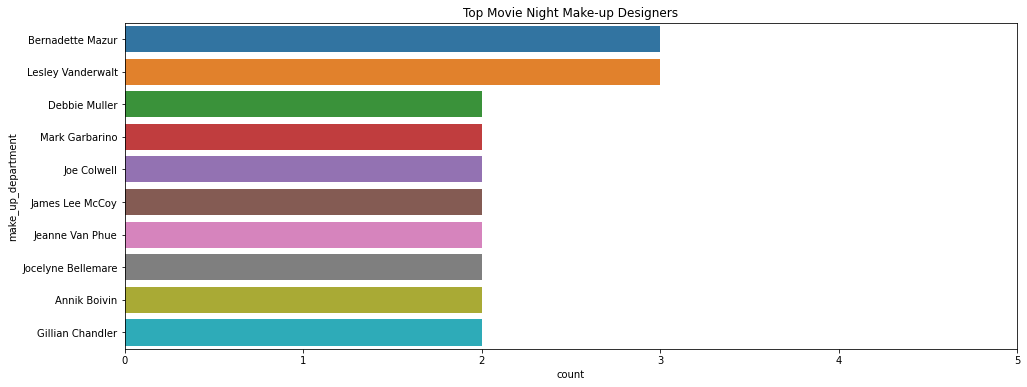

In [244]:
aggregate_countplot('make_up_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Make-up Designers', 
                    figure_name=False)

In [534]:
print(movie_df[movie_df['make_up_department'].str.contains('Bernadette Mazur')]['original_title'].values)

['Anon (2018)' 'Jungle 2 Jungle (1997)' 'Hackers (1995)']


In [533]:
print(movie_df[movie_df['make_up_department'].str.contains('Lesley Vanderwalt')]['original_title'].values)

['Ghost Rider (2007)' 'Scooby-Doo (2002)' 'Street Fighter (1994)']


### Production Managers

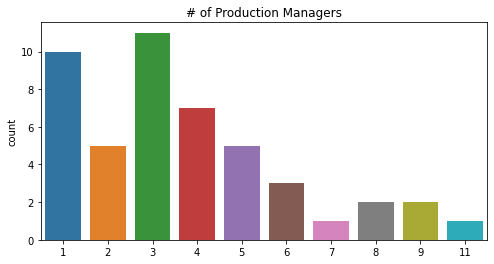

In [245]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['production_managers_count'].values)
plt.title('# of Production Managers')
plt.show()

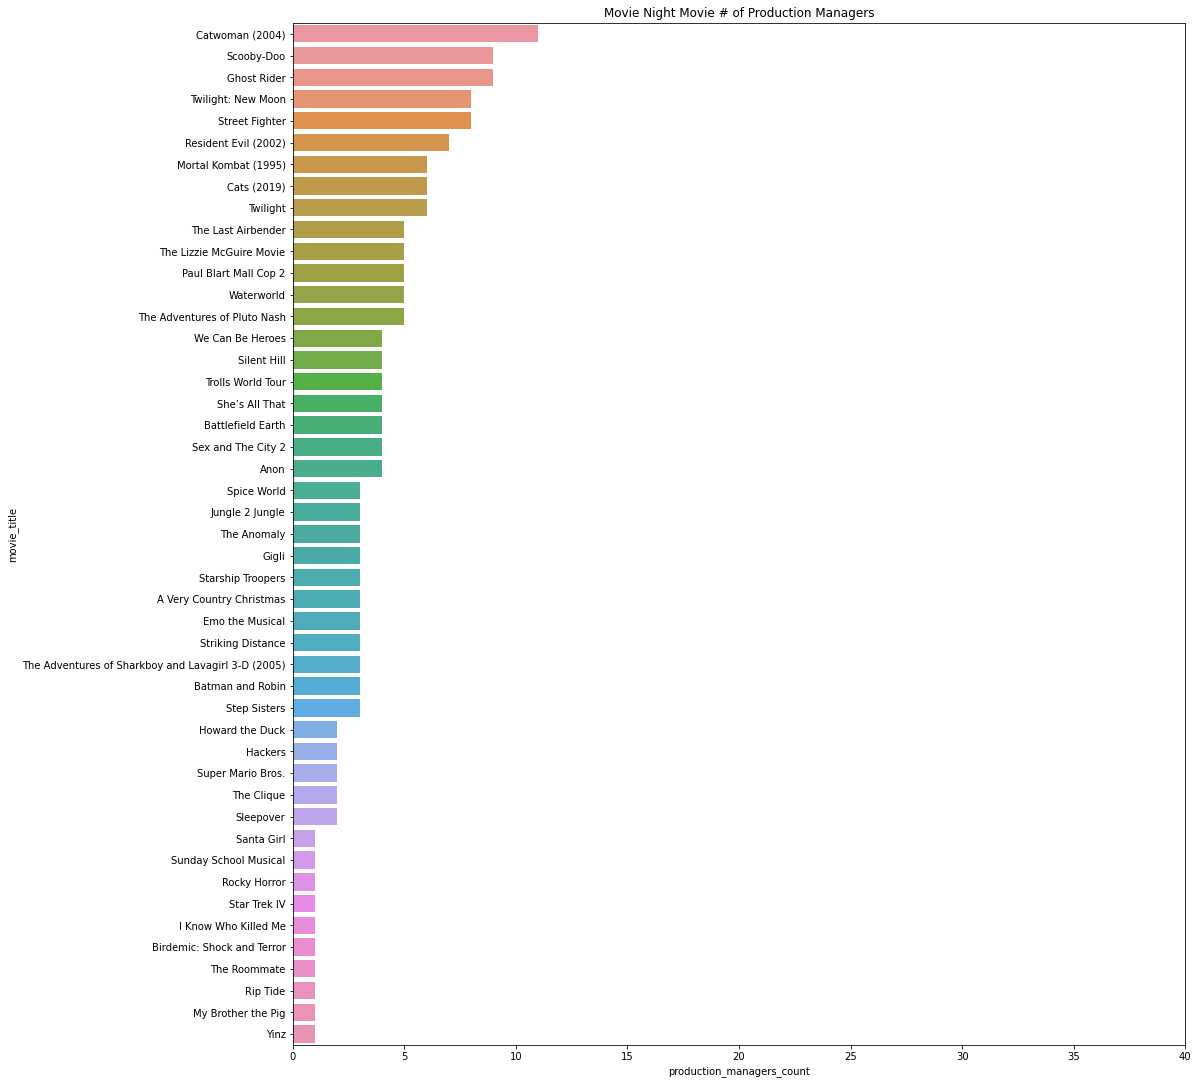

In [246]:
sorted_countplot('production_managers_count', 
                 movie_df, 
                 plot_range=[0,40], 
                 num_items=False, 
                 title='Movie Night Movie # of Production Managers', 
                 figure_name=False, 
                 ascending=False)

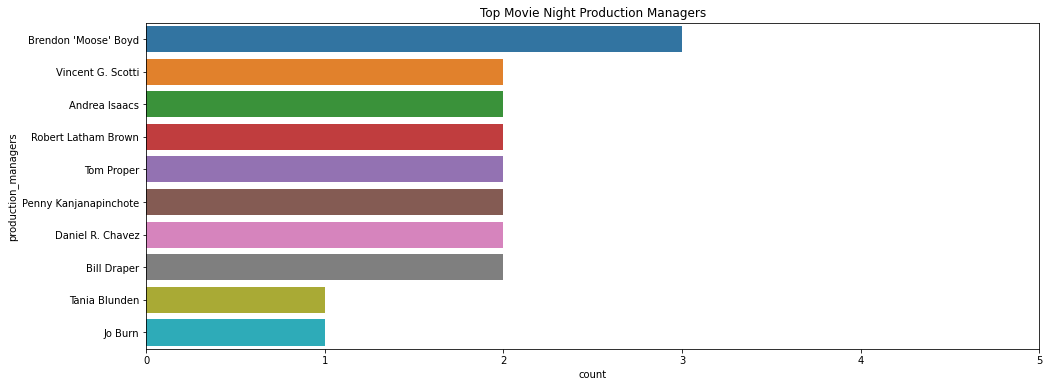

In [247]:
aggregate_countplot('production_managers',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Production Managers', 
                    figure_name=False)

In [535]:
print(movie_df[movie_df['production_managers'].str.contains("Brendon 'Moose' Boyd")]['original_title'].values)

['Ghost Rider (2007)' 'Scooby-Doo (2002)' 'Street Fighter (1994)']


### Assistant Directors

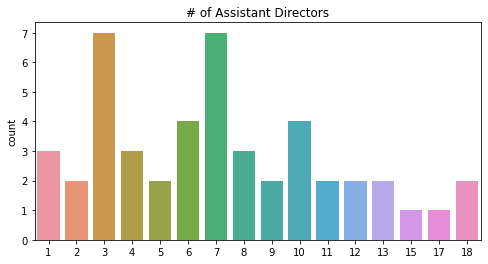

In [248]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['assistant_directors_count'].values)
plt.title('# of Assistant Directors')
plt.show()

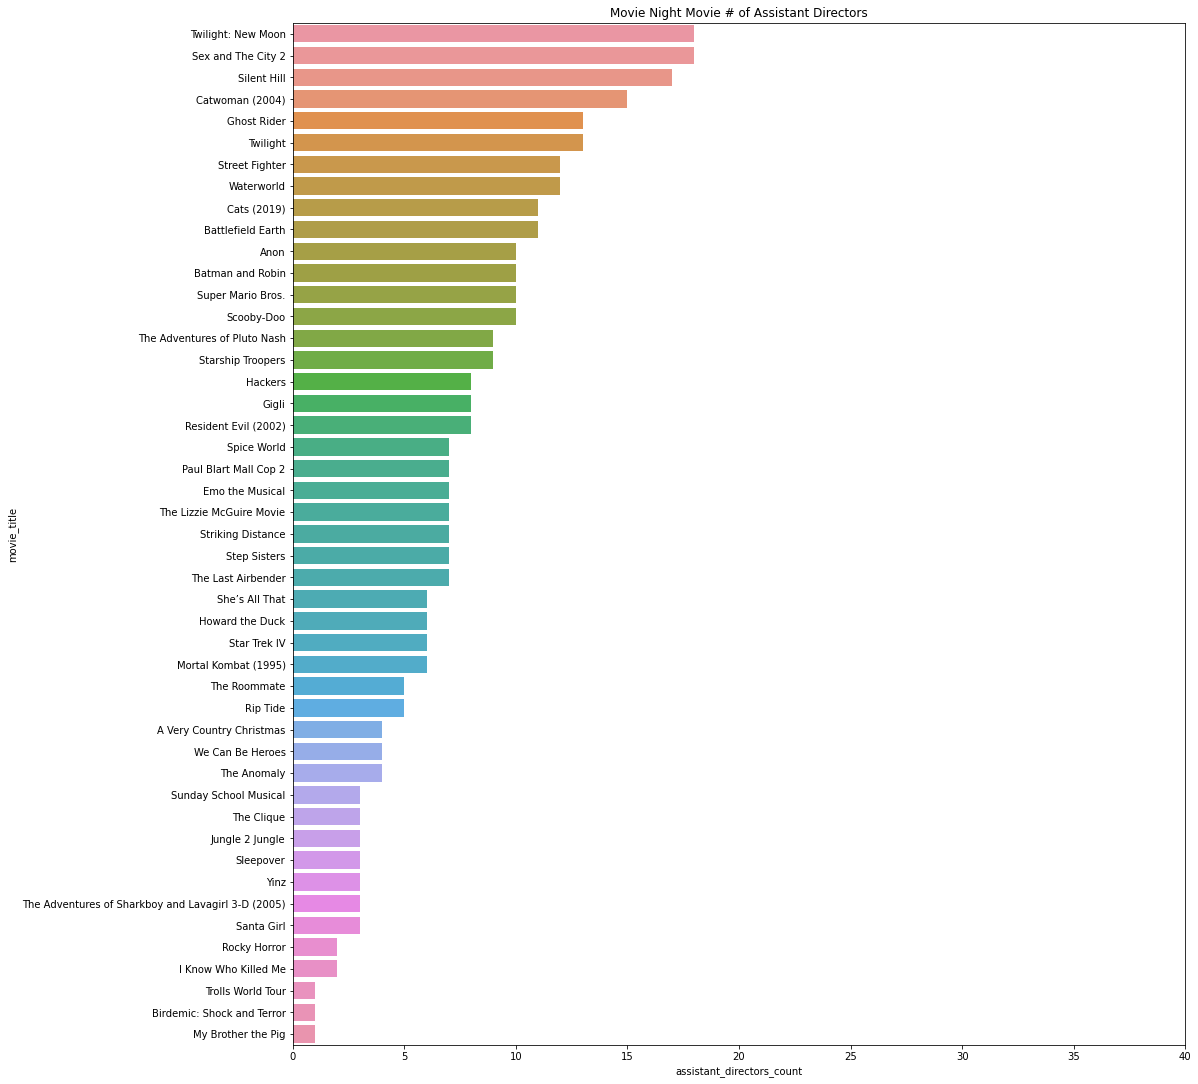

In [249]:
sorted_countplot('assistant_directors_count', 
                 movie_df, 
                 plot_range=[0,40], 
                 num_items=False, 
                 title='Movie Night Movie # of Assistant Directors', 
                 figure_name=False, 
                 ascending=False)

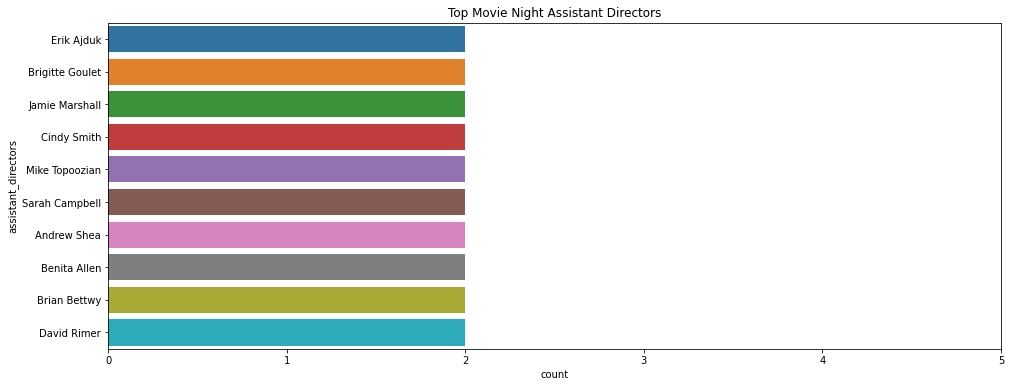

In [250]:
aggregate_countplot('assistant_directors',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Assistant Directors', 
                    figure_name=False)

### Art Department

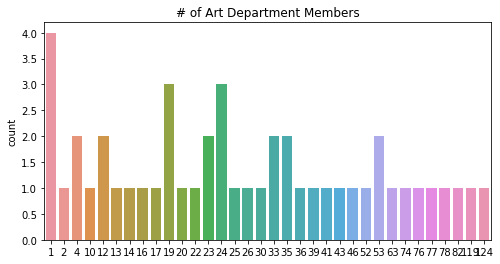

In [251]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['art_department_count'].values)
plt.title('# of Art Department Members')
plt.show()

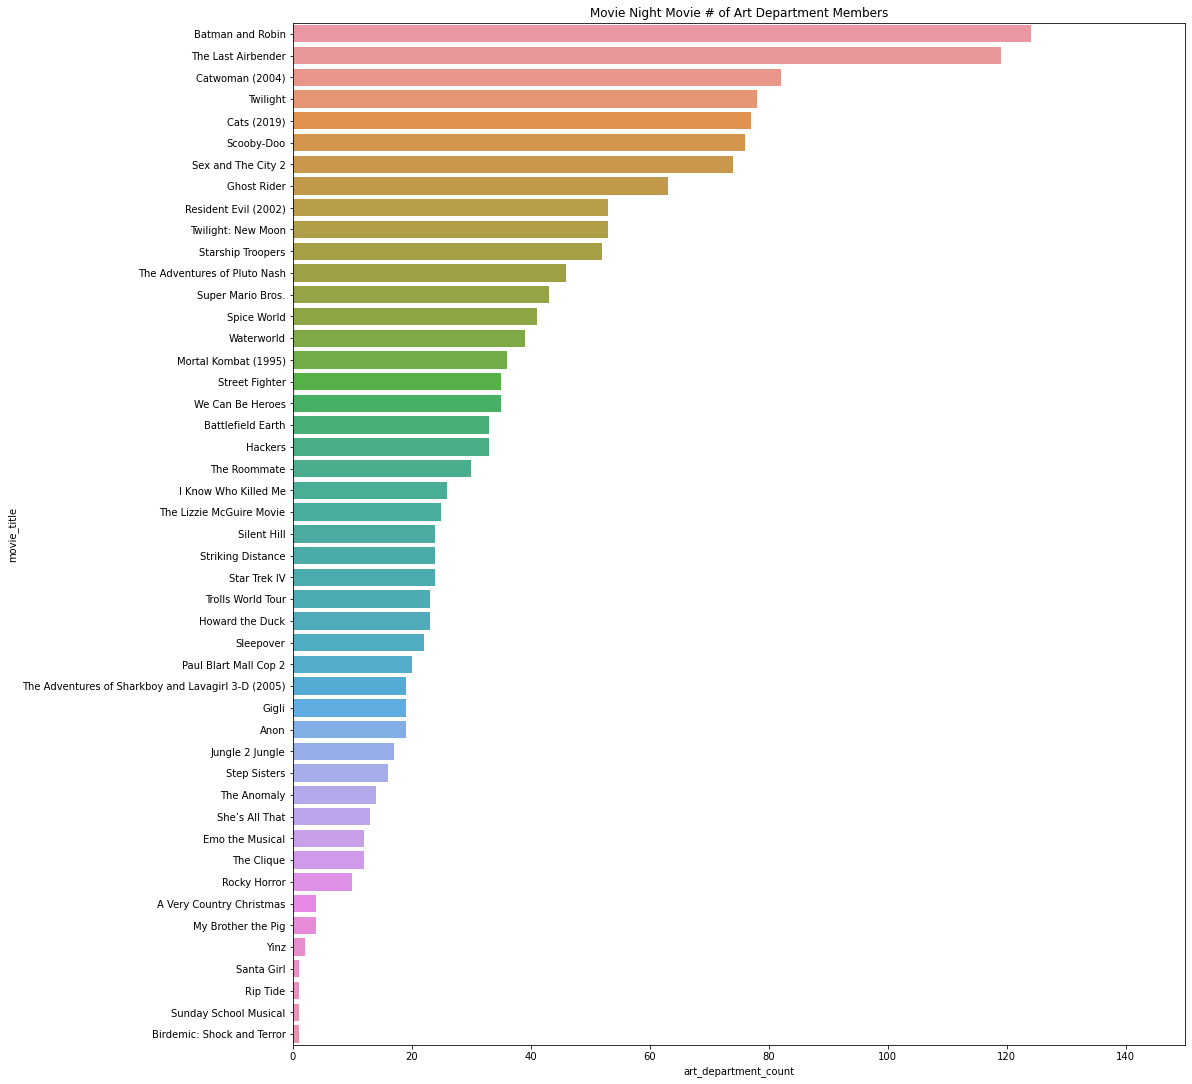

In [252]:
sorted_countplot('art_department_count', 
                 movie_df, 
                 plot_range=[0,150], 
                 num_items=False, 
                 title='Movie Night Movie # of Art Department Members', 
                 figure_name=False, 
                 ascending=False)

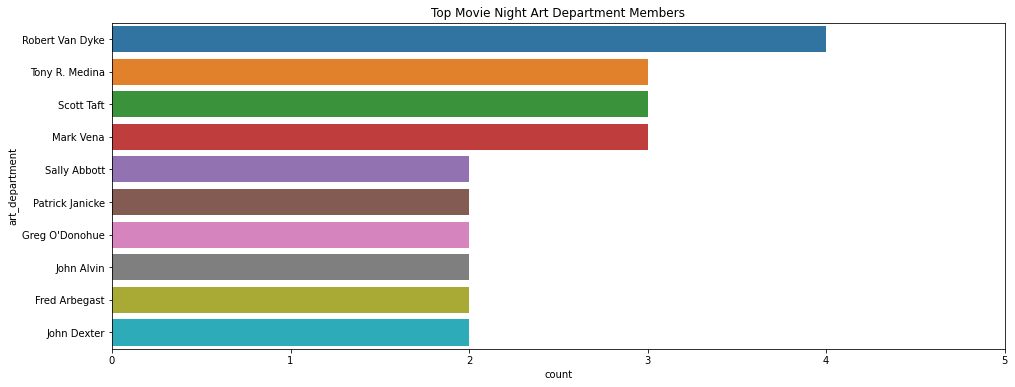

In [253]:
aggregate_countplot('art_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Art Department Members', 
                    figure_name=False)

In [536]:
print(movie_df[movie_df['art_department'].str.contains('Robert Van Dyke')]['original_title'].values)

['Waterworld (1995)' 'Starship Troopers (1997)'
 'The Last Airbender (2010)' 'Star Trek IV: The Voyage Home (1986)']


### Sound Department

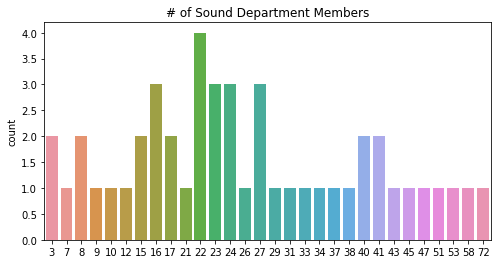

In [254]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['sound_department_count'].values)
plt.title('# of Sound Department Members')
plt.show()

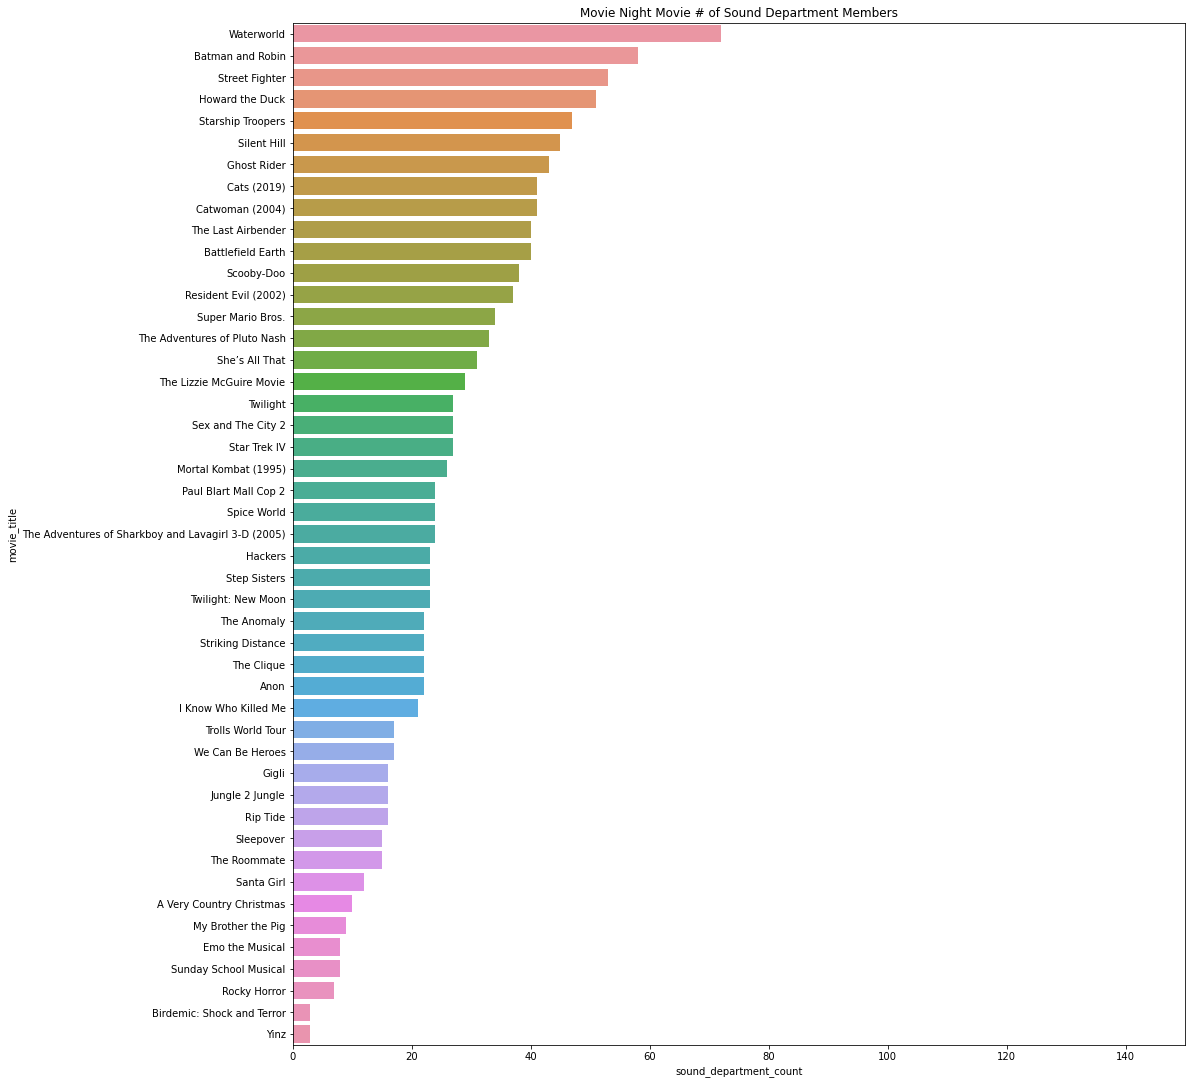

In [255]:
sorted_countplot('sound_department_count', 
                 movie_df, 
                 plot_range=[0,150], 
                 num_items=False, 
                 title='Movie Night Movie # of Sound Department Members', 
                 figure_name=False, 
                 ascending=False)

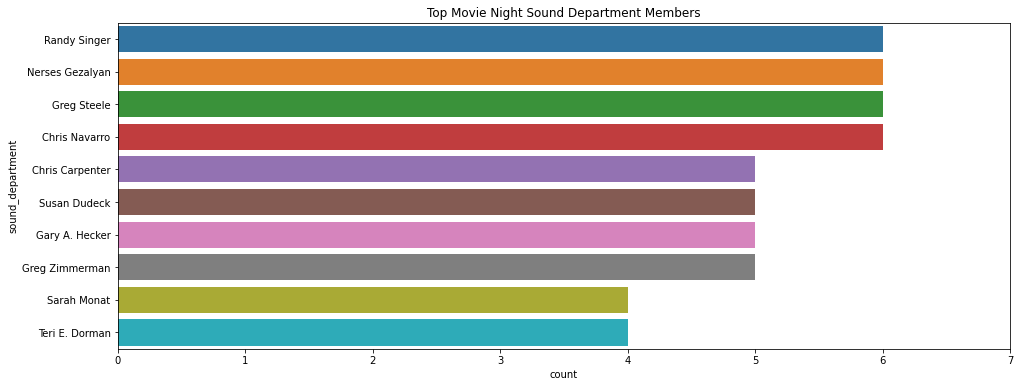

In [256]:
aggregate_countplot('sound_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,7],
                    title='Top Movie Night Sound Department Members', 
                    figure_name=False)

### Special Effects

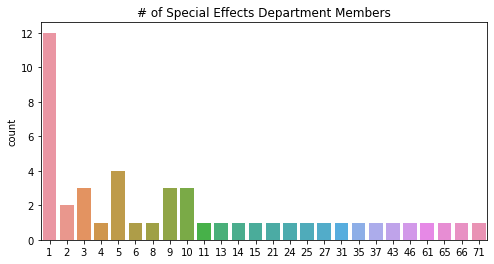

In [257]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['special_effects_count'].values)
plt.title('# of Special Effects Department Members')
plt.show()

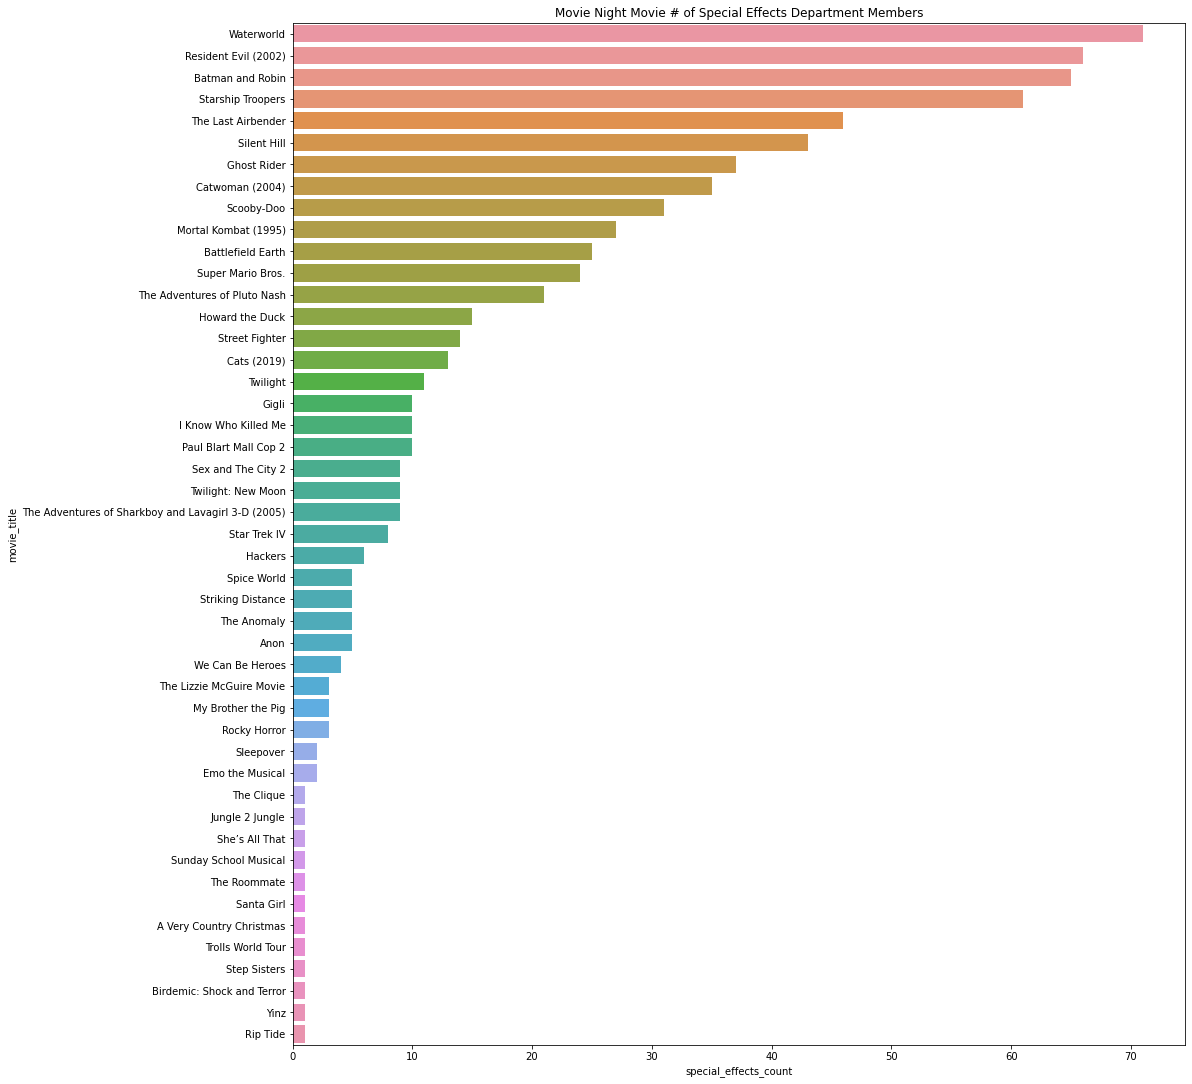

In [258]:
sorted_countplot('special_effects_count', 
                 movie_df,  
                 num_items=False, 
                 title='Movie Night Movie # of Special Effects Department Members', 
                 figure_name=False, 
                 ascending=False)

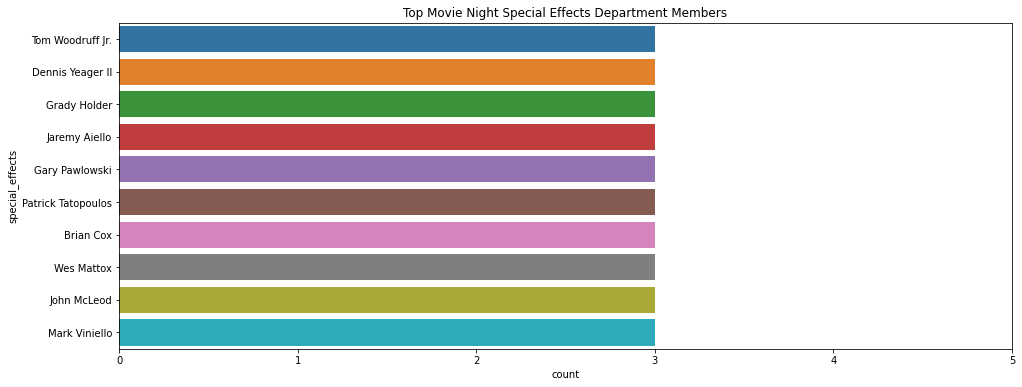

In [259]:
aggregate_countplot('special_effects',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Special Effects Department Members', 
                    figure_name=False)

### Visual Effects

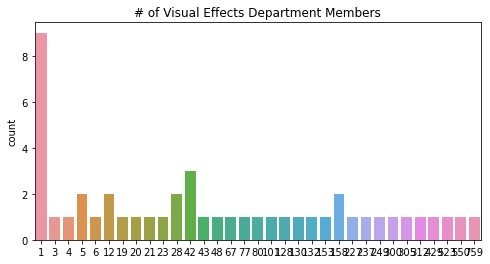

In [260]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['visual_effects_count'].values)
plt.title('# of Visual Effects Department Members')
plt.show()

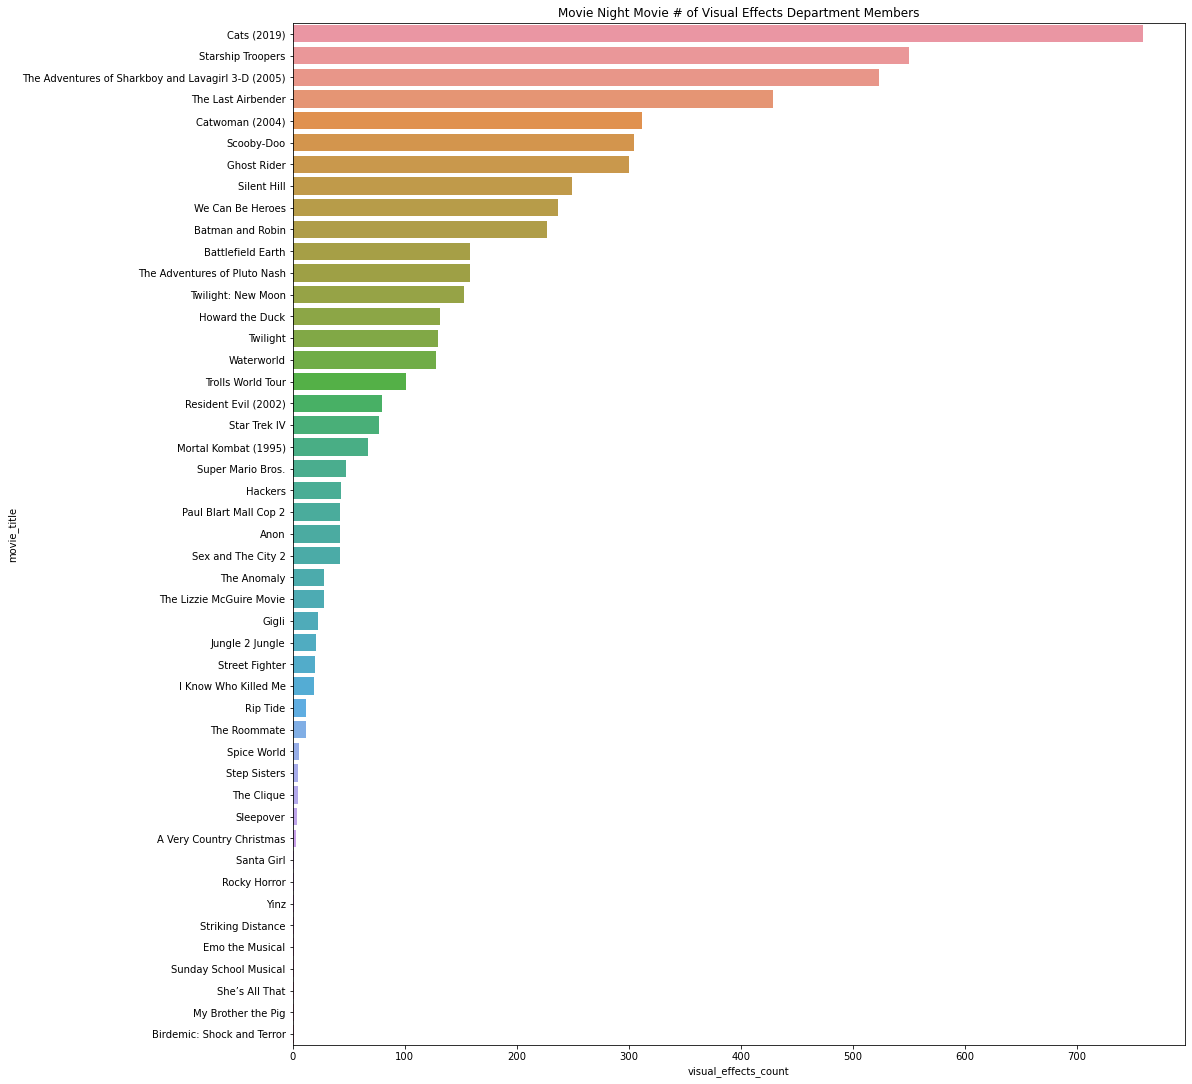

In [261]:
sorted_countplot('visual_effects_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Visual Effects Department Members', 
                 figure_name=False, 
                 ascending=False)

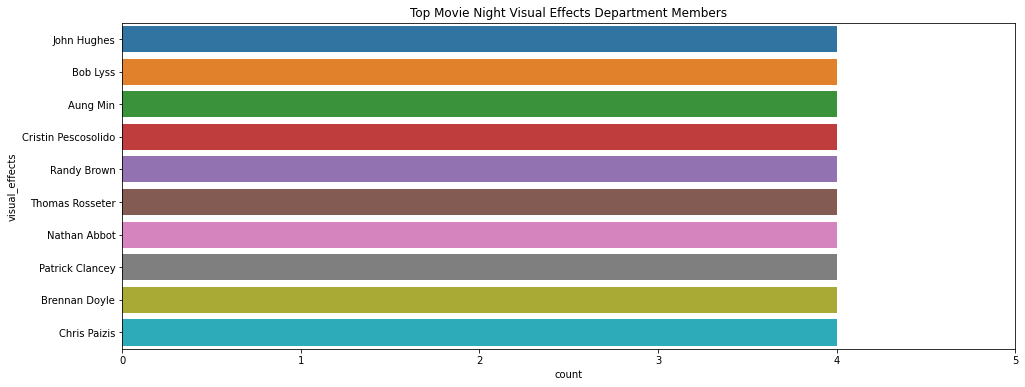

In [262]:
aggregate_countplot('visual_effects',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Visual Effects Department Members', 
                    figure_name=False)

### Stunts

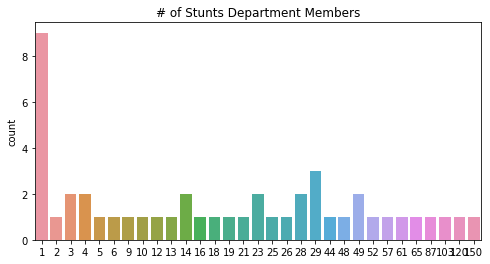

In [263]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['stunts_count'].values)
plt.title('# of Stunts Department Members')
plt.show()

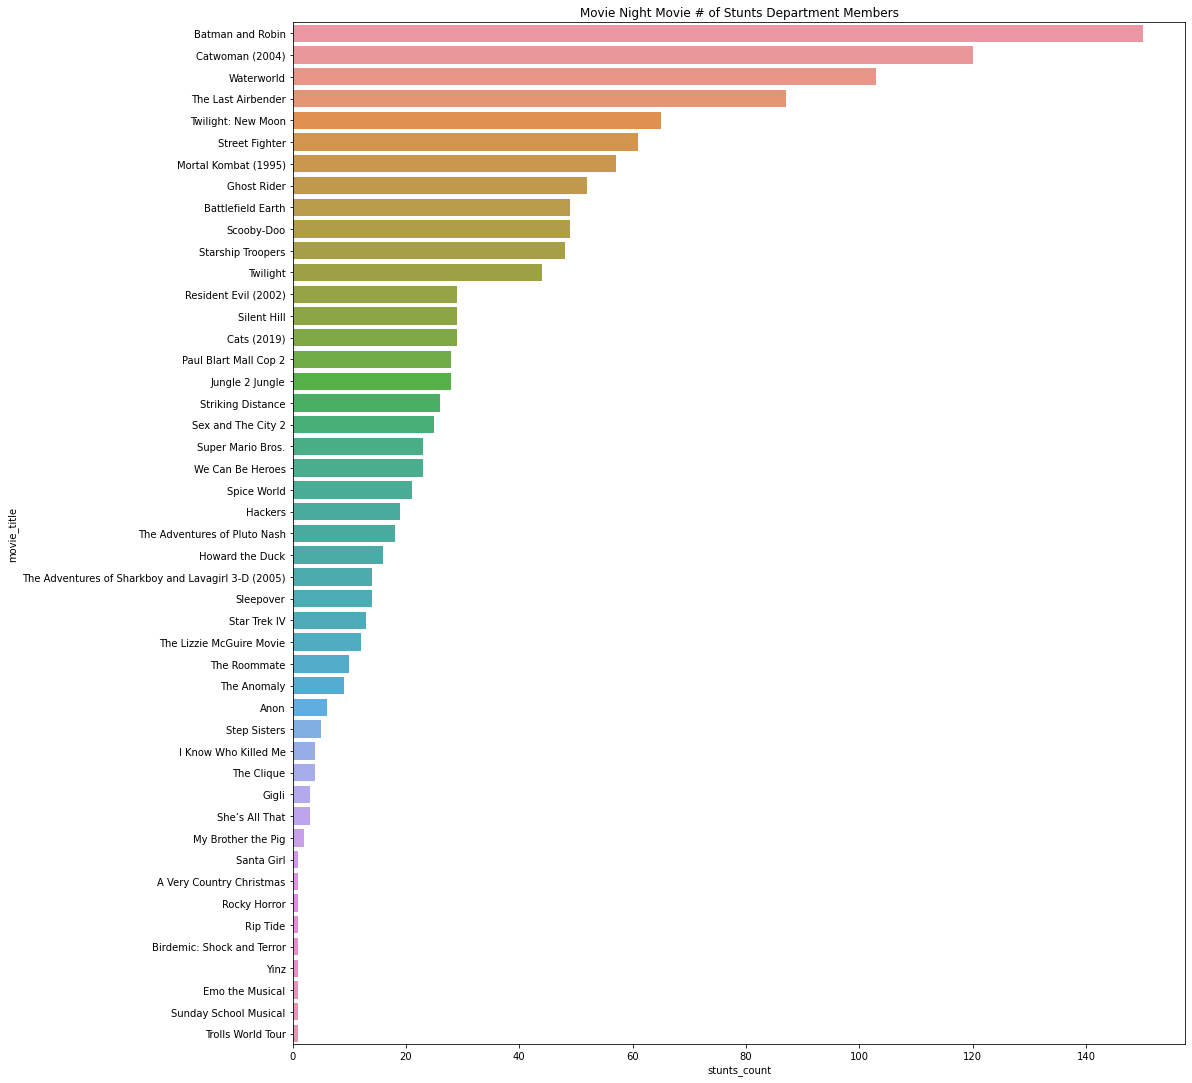

In [264]:
sorted_countplot('stunts_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Stunts Department Members', 
                 figure_name=False, 
                 ascending=False)

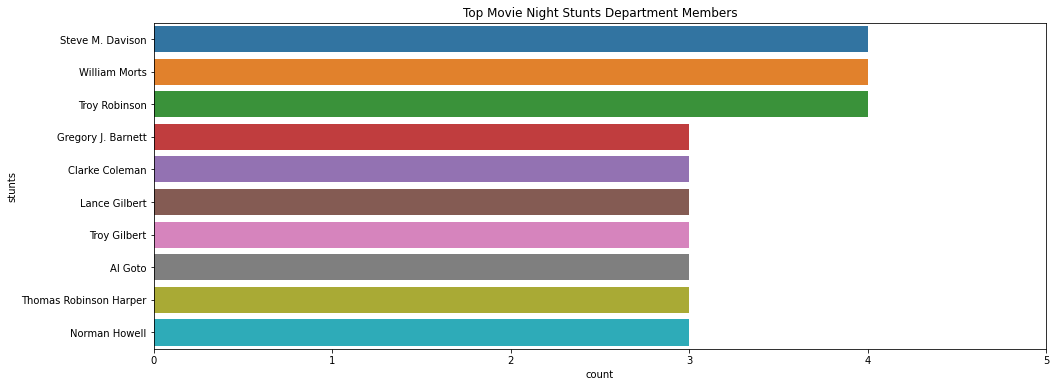

In [265]:
aggregate_countplot('stunts',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Stunts Department Members', 
                    figure_name=False)

### Camera Department

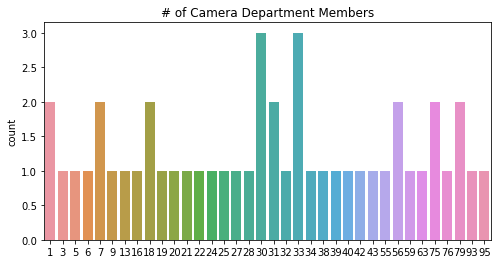

In [266]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['camera_department_count'].values)
plt.title('# of Camera Department Members')
plt.show()

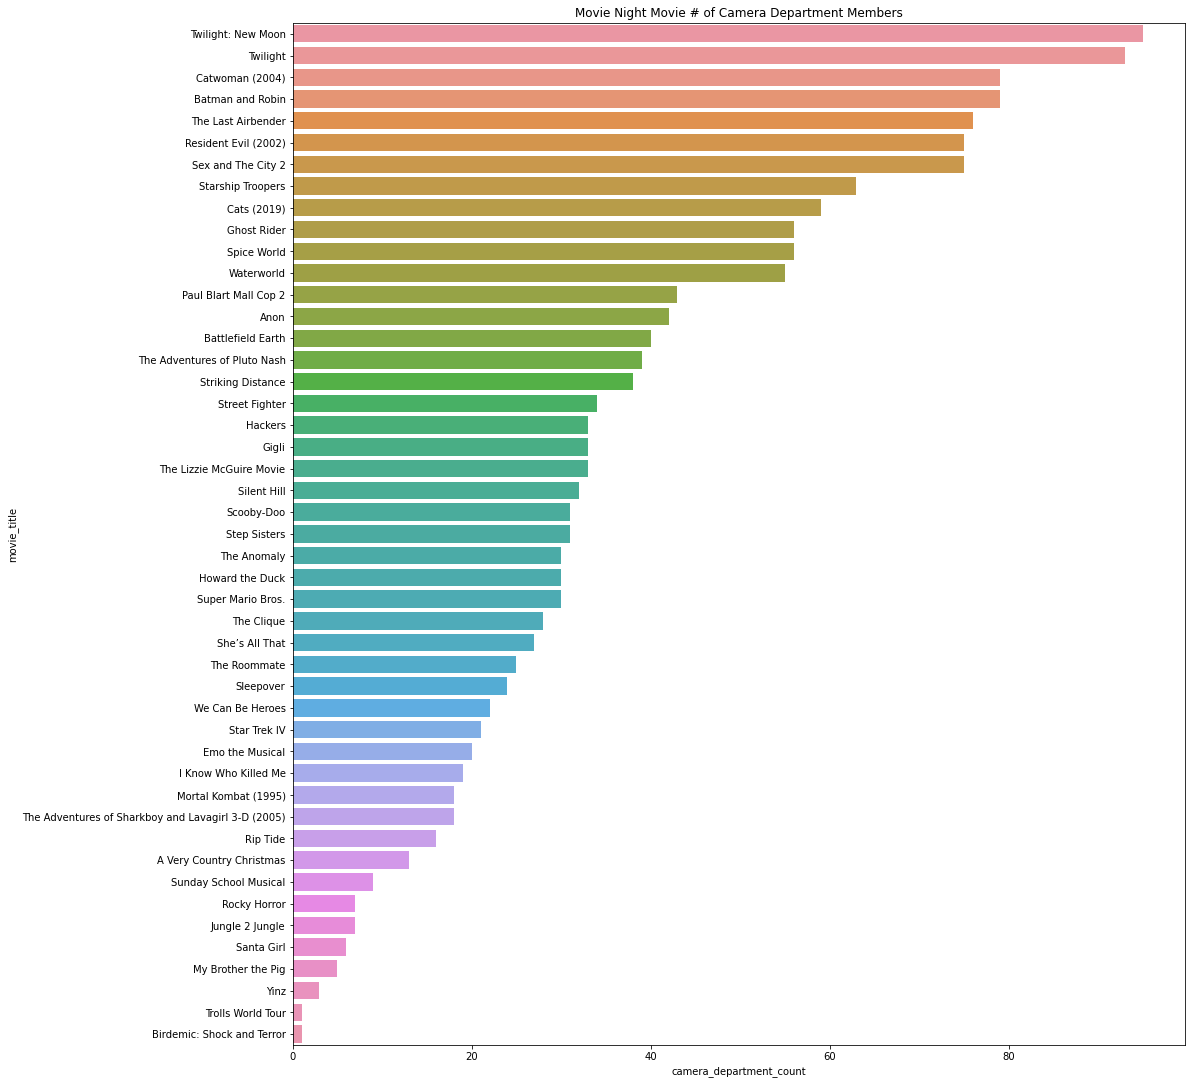

In [267]:
sorted_countplot('camera_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Camera Department Members', 
                 figure_name=False, 
                 ascending=False)

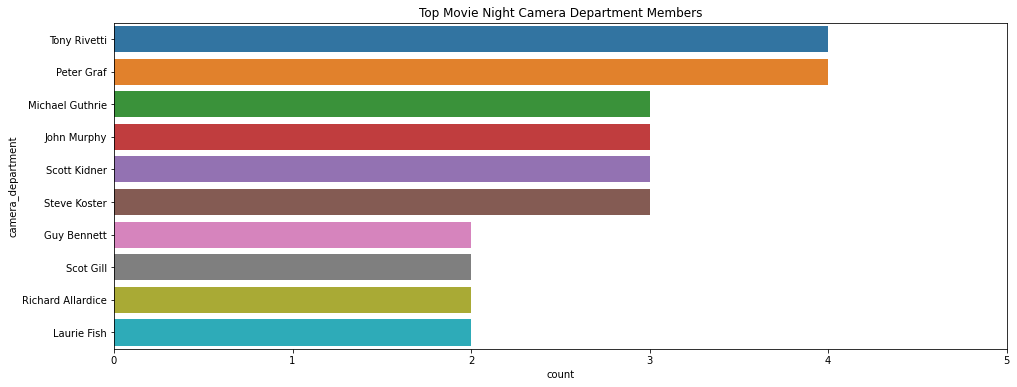

In [268]:
aggregate_countplot('camera_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Camera Department Members', 
                    figure_name=False)

### Animation Department 

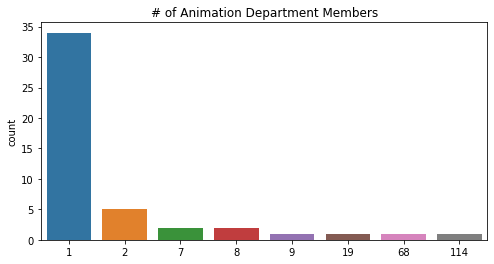

In [269]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['animation_department_count'].values)
plt.title('# of Animation Department Members')
plt.show()

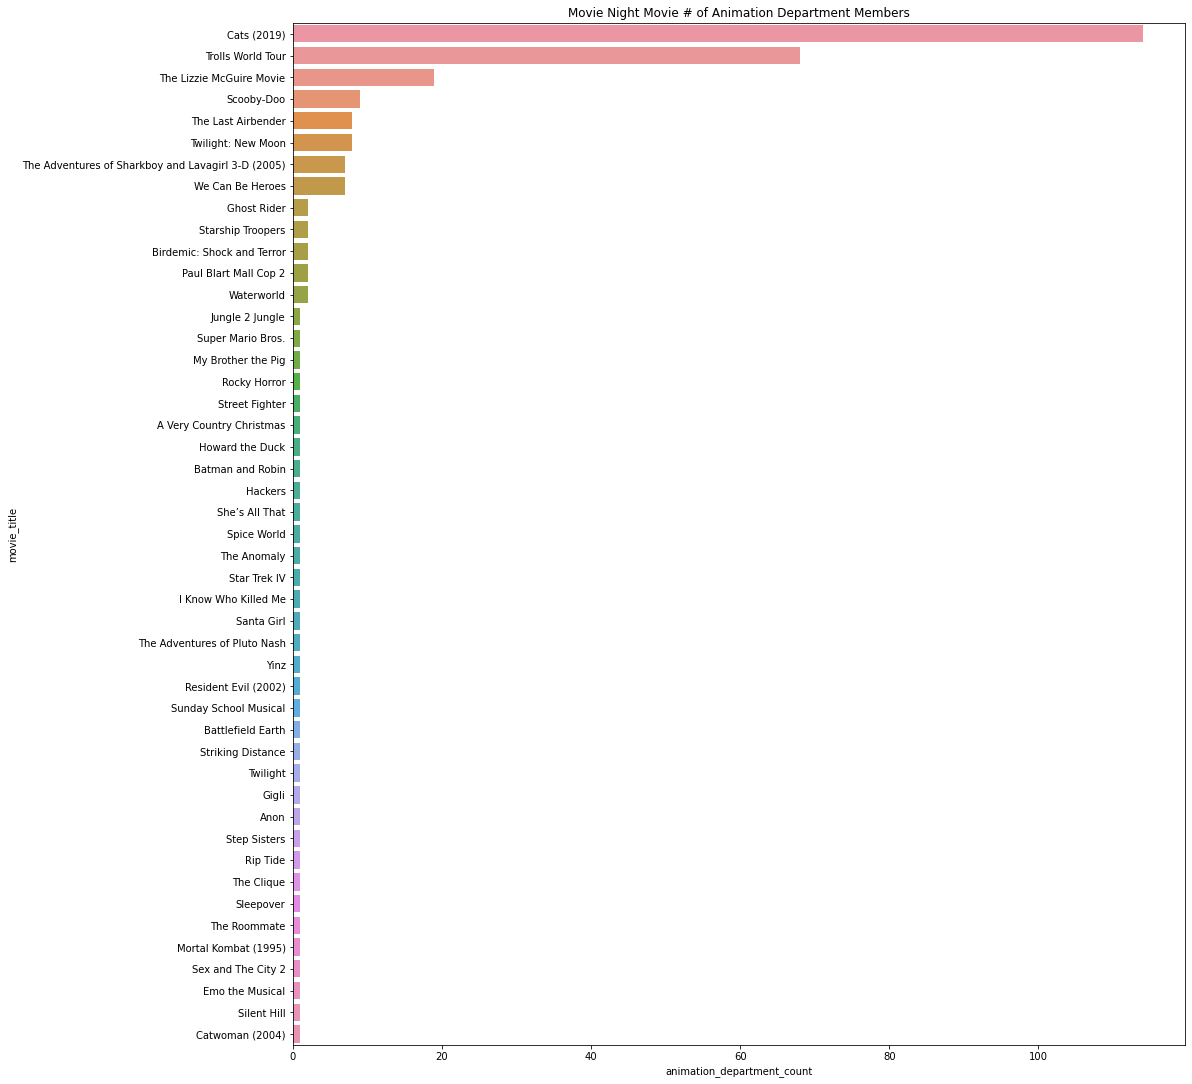

In [270]:
sorted_countplot('animation_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Animation Department Members', 
                 figure_name=False, 
                 ascending=False)

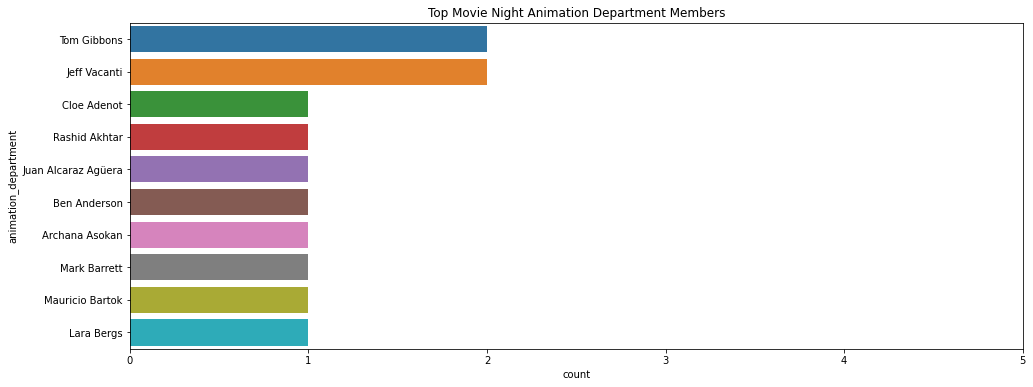

In [271]:
aggregate_countplot('animation_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Animation Department Members', 
                    figure_name=False)

### Casting Department

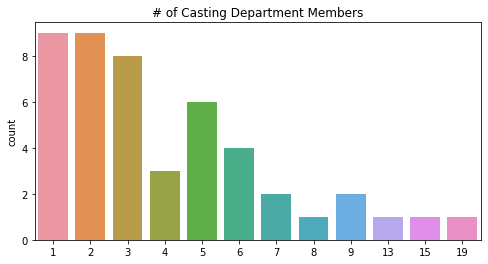

In [272]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['casting_department_count'].values)
plt.title('# of Casting Department Members')
plt.show()

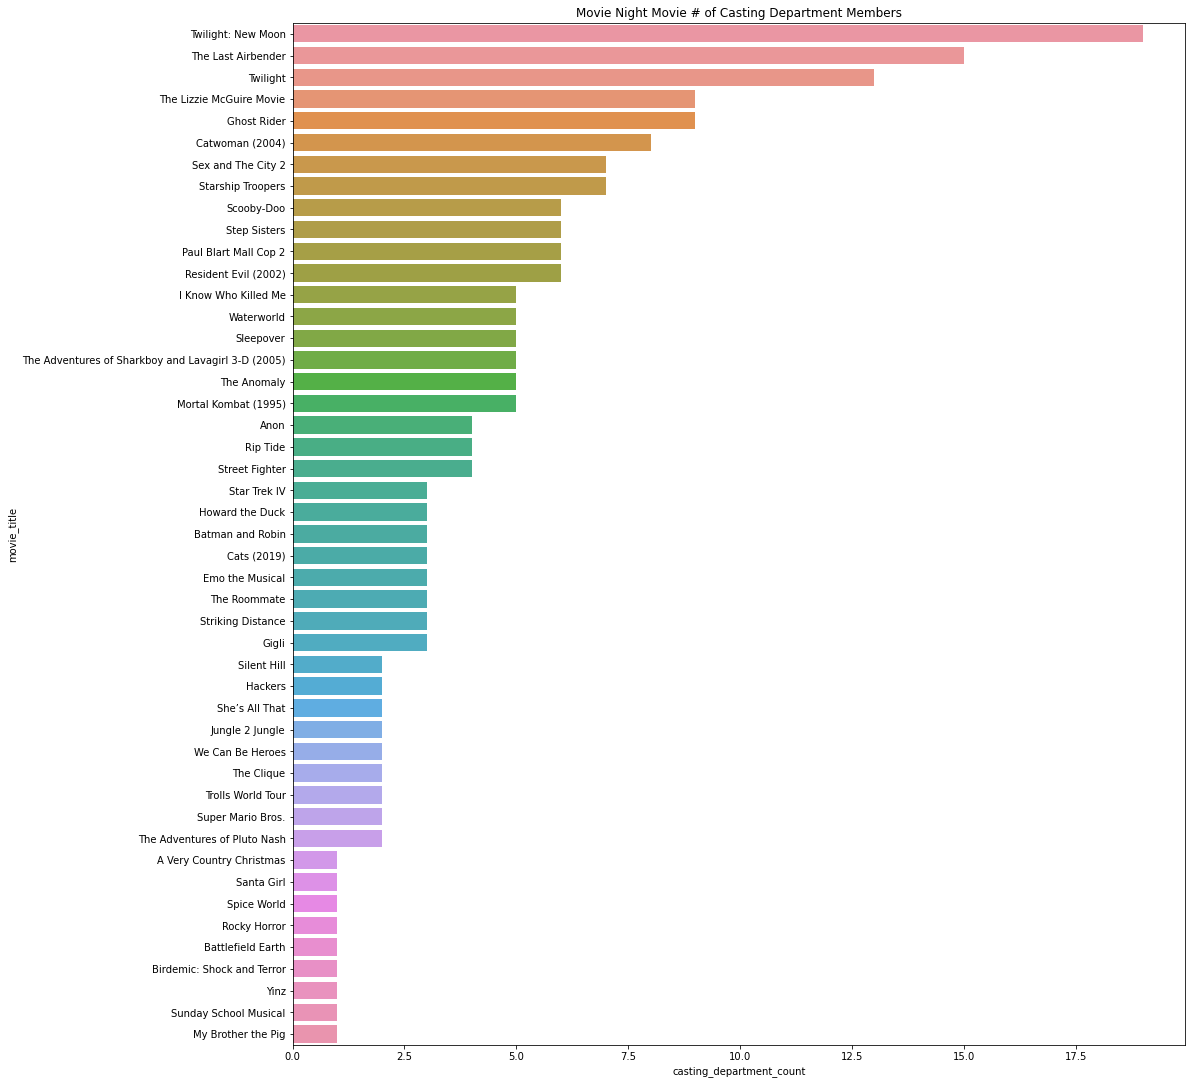

In [273]:
sorted_countplot('casting_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Casting Department Members', 
                 figure_name=False, 
                 ascending=False)

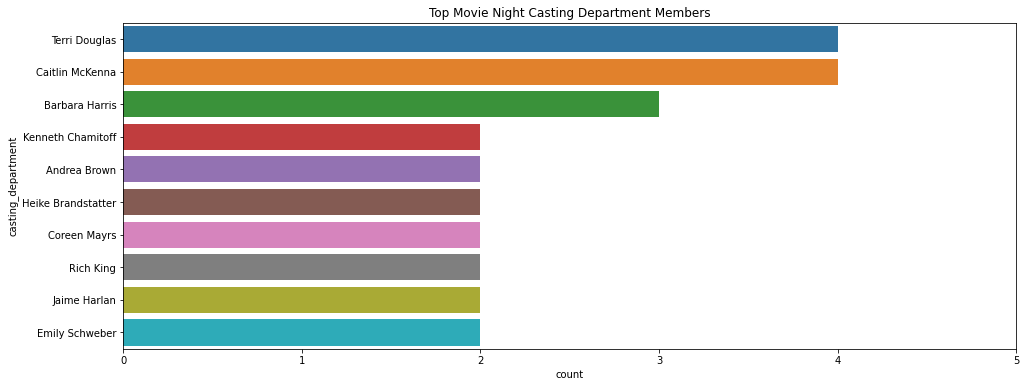

In [274]:
aggregate_countplot('casting_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Casting Department Members', 
                    figure_name=False)

### Costume Department

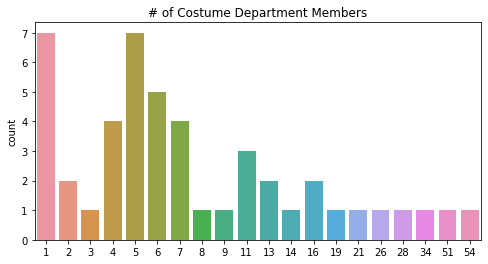

In [275]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['costume_departmen_count'].values)
plt.title('# of Costume Department Members')
plt.show()

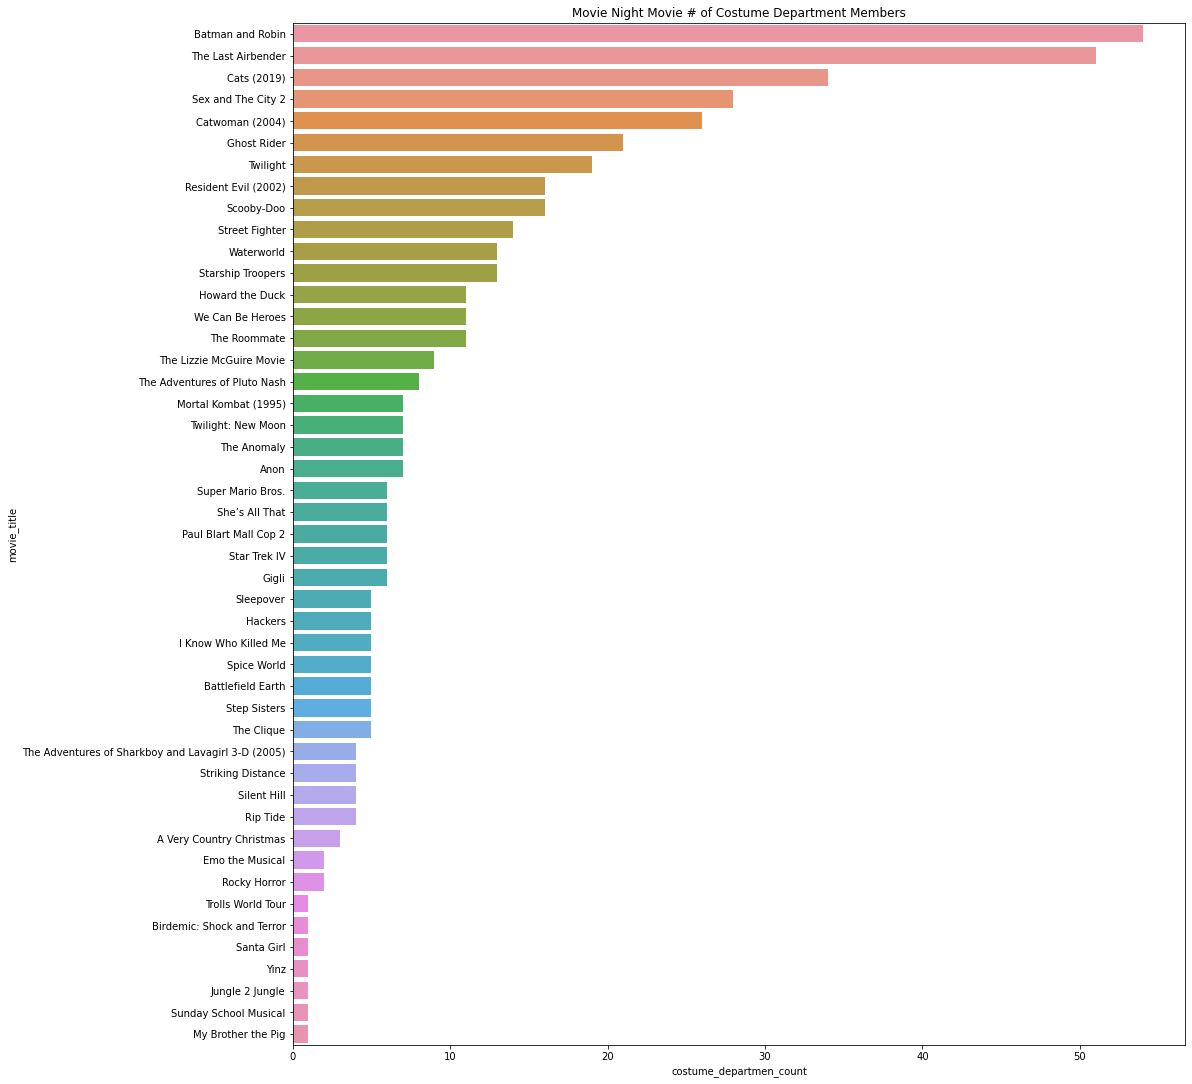

In [276]:
sorted_countplot('costume_departmen_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Costume Department Members', 
                 figure_name=False, 
                 ascending=False)

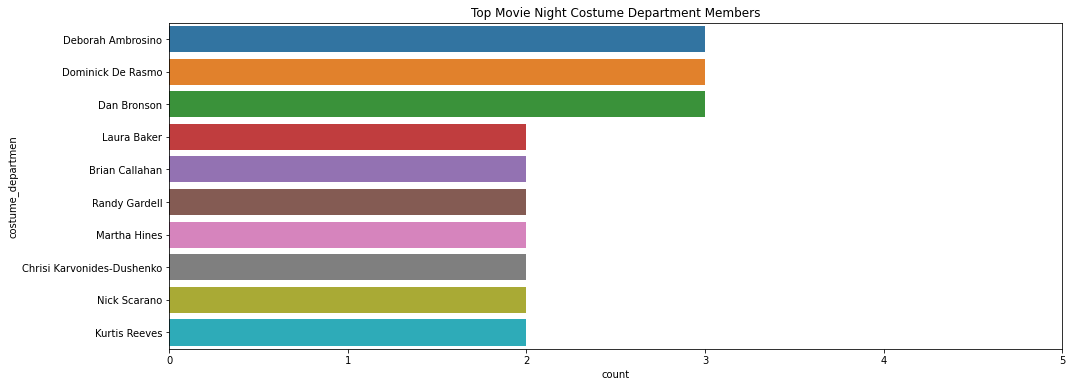

In [277]:
aggregate_countplot('costume_departmen',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Costume Department Members', 
                    figure_name=False)

### Location Management 

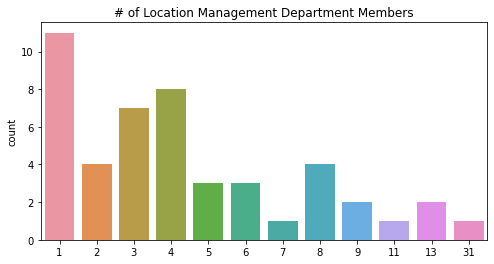

In [278]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['location_management_count'].values)
plt.title('# of Location Management Department Members')
plt.show()

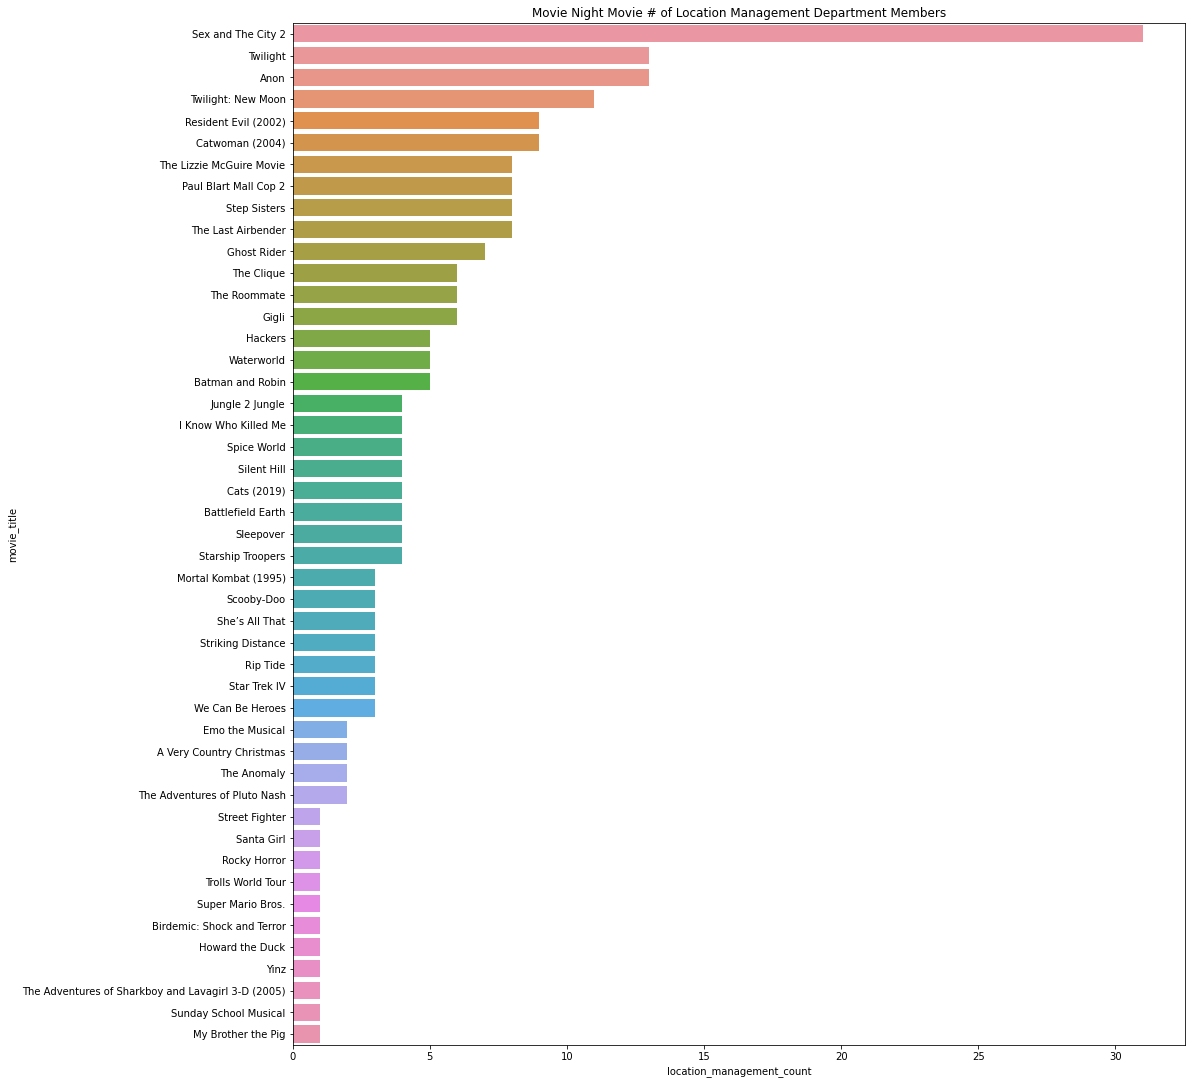

In [279]:
sorted_countplot('location_management_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Location Management Department Members', 
                 figure_name=False, 
                 ascending=False)

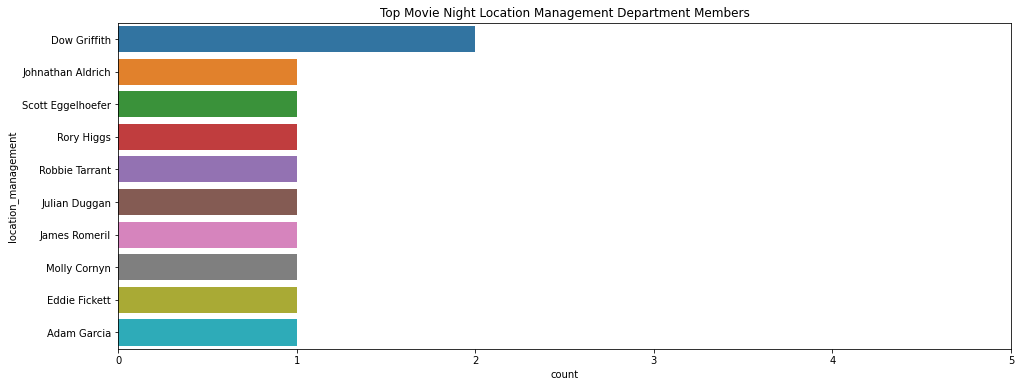

In [280]:
aggregate_countplot('location_management',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Location Management Department Members', 
                    figure_name=False)

### Music Department

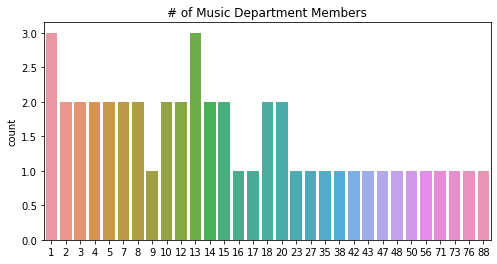

In [281]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['music_department_count'].values)
plt.title('# of Music Department Members')
plt.show()

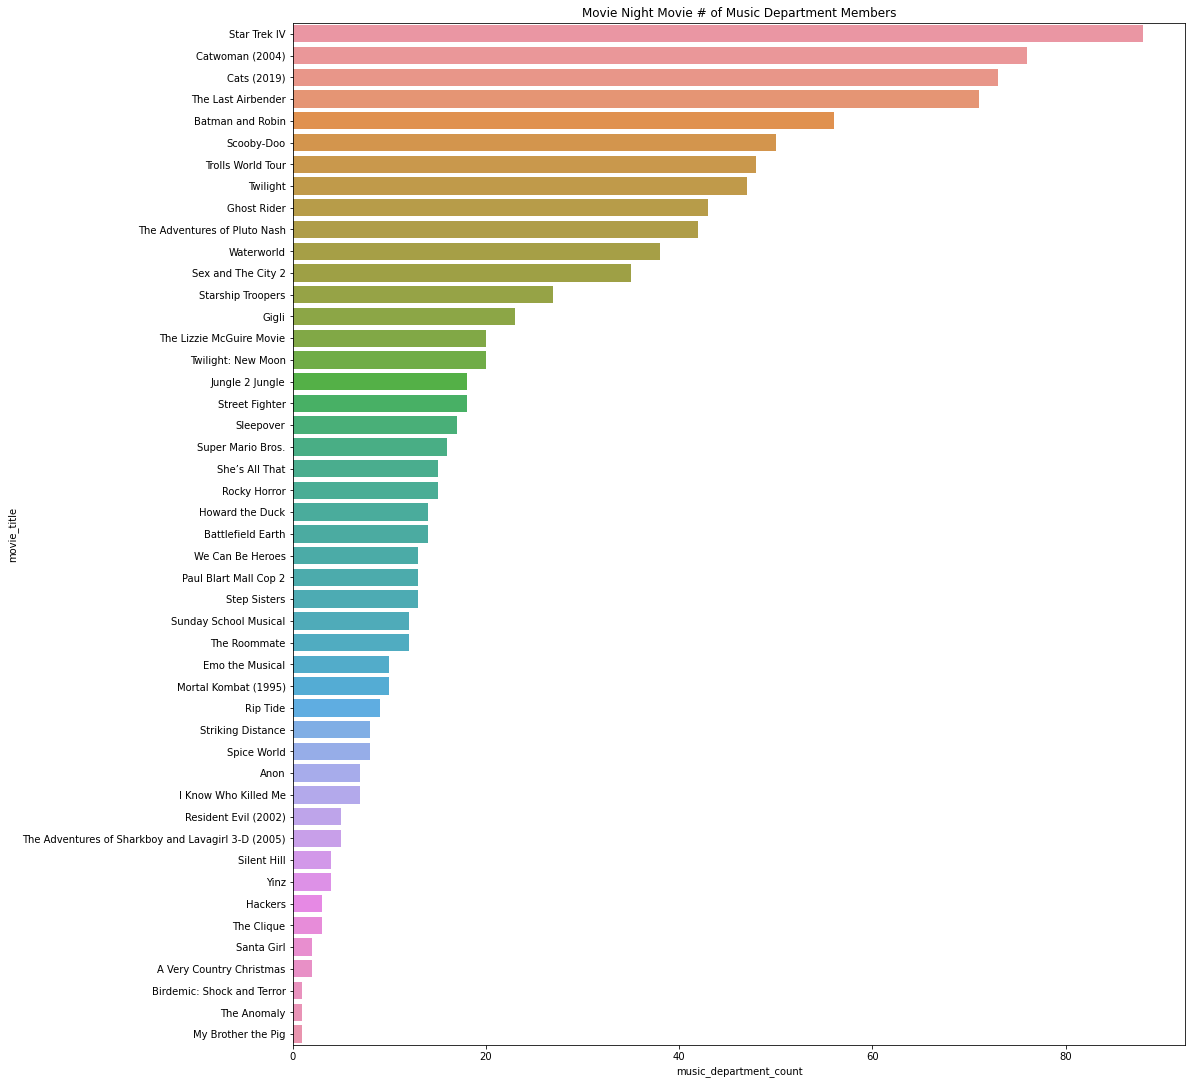

In [282]:
sorted_countplot('music_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Music Department Members', 
                 figure_name=False, 
                 ascending=False)

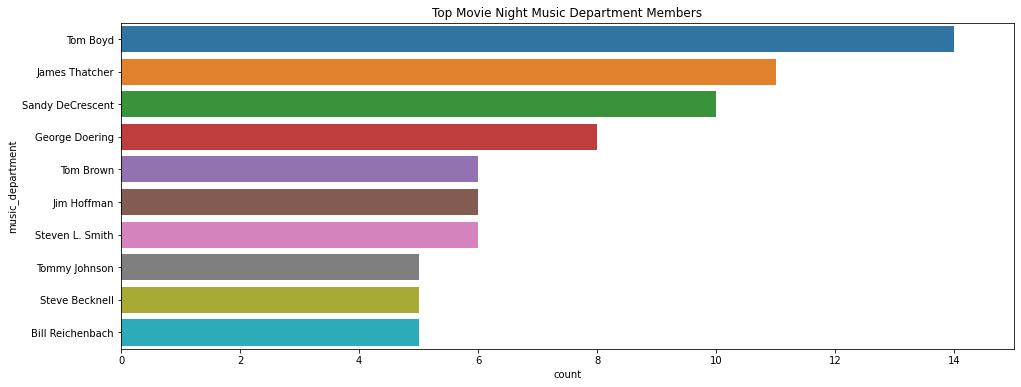

In [283]:
aggregate_countplot('music_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,15],
                    title='Top Movie Night Music Department Members', 
                    figure_name=False)

### Script Department

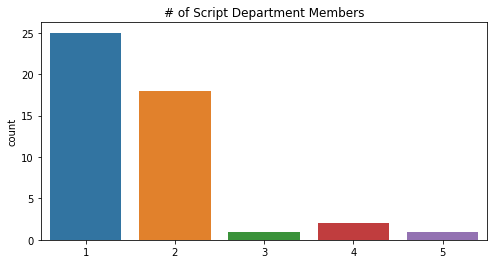

In [284]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['script_department_count'].values)
plt.title('# of Script Department Members')
plt.show()

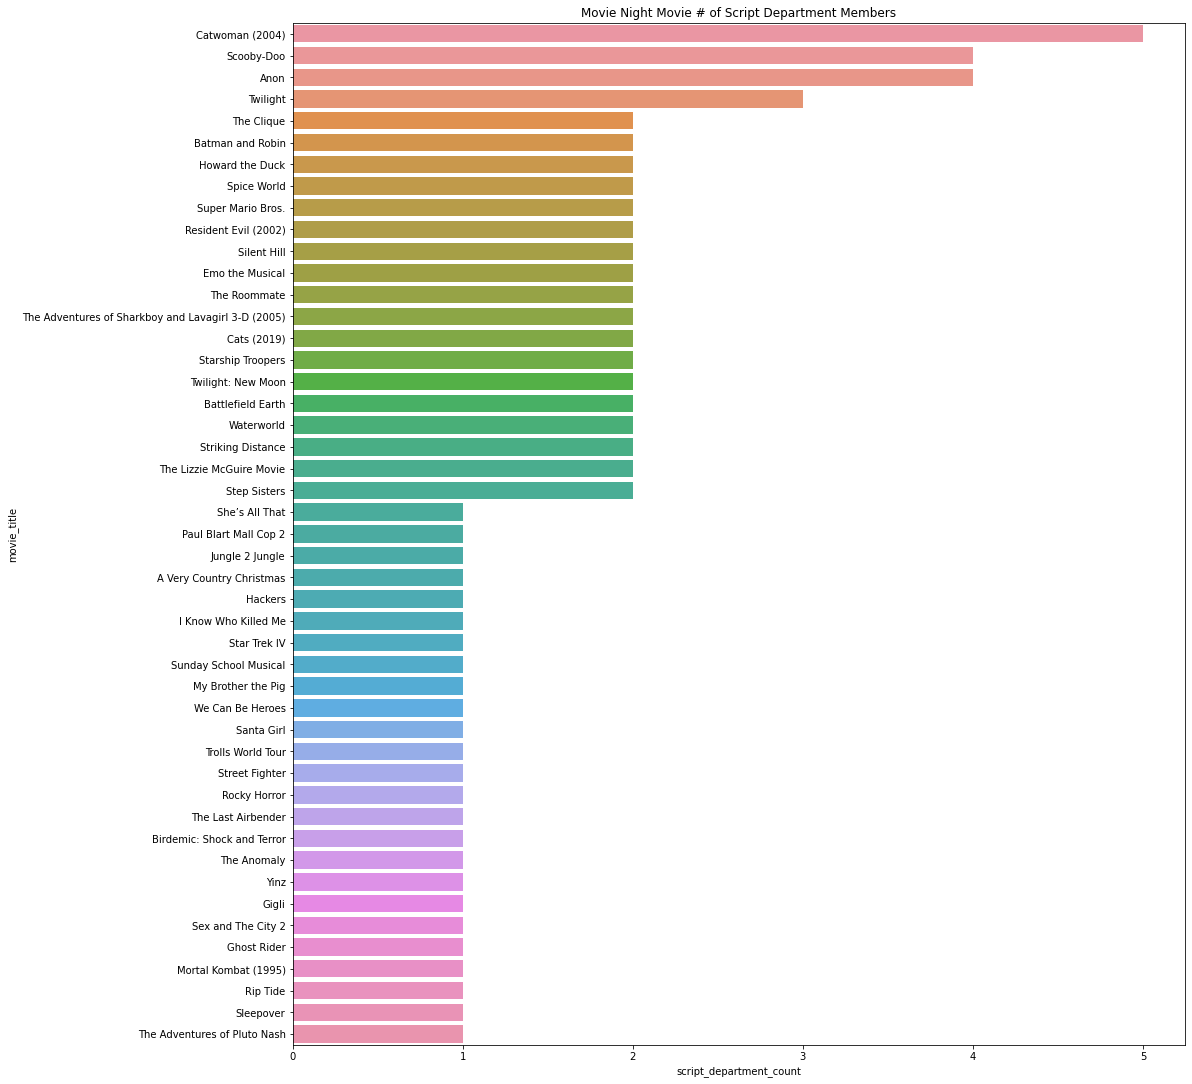

In [285]:
sorted_countplot('script_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Script Department Members', 
                 figure_name=False, 
                 ascending=False)

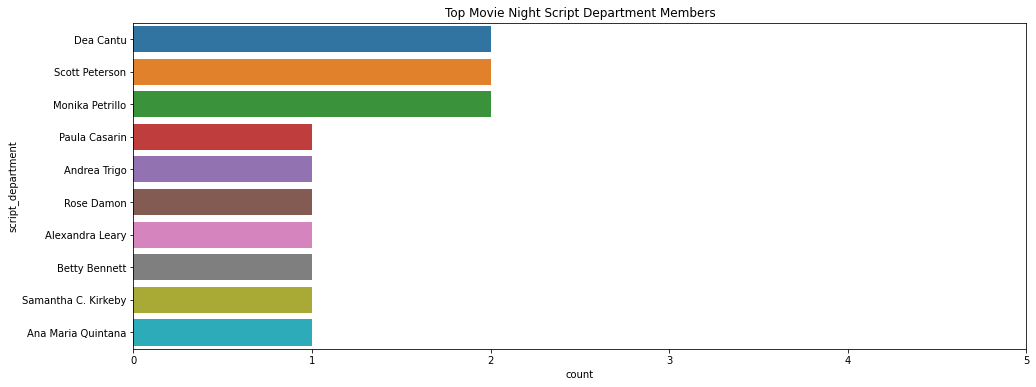

In [286]:
aggregate_countplot('script_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Script Department Members', 
                    figure_name=False)

### Transportation Department

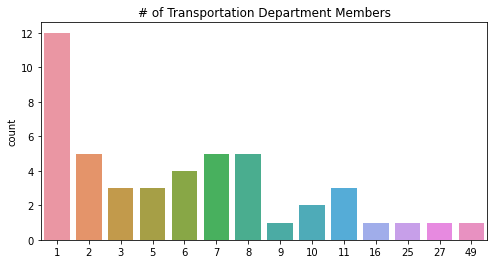

In [287]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['transportation_department_count'].values)
plt.title('# of Transportation Department Members')
plt.show()

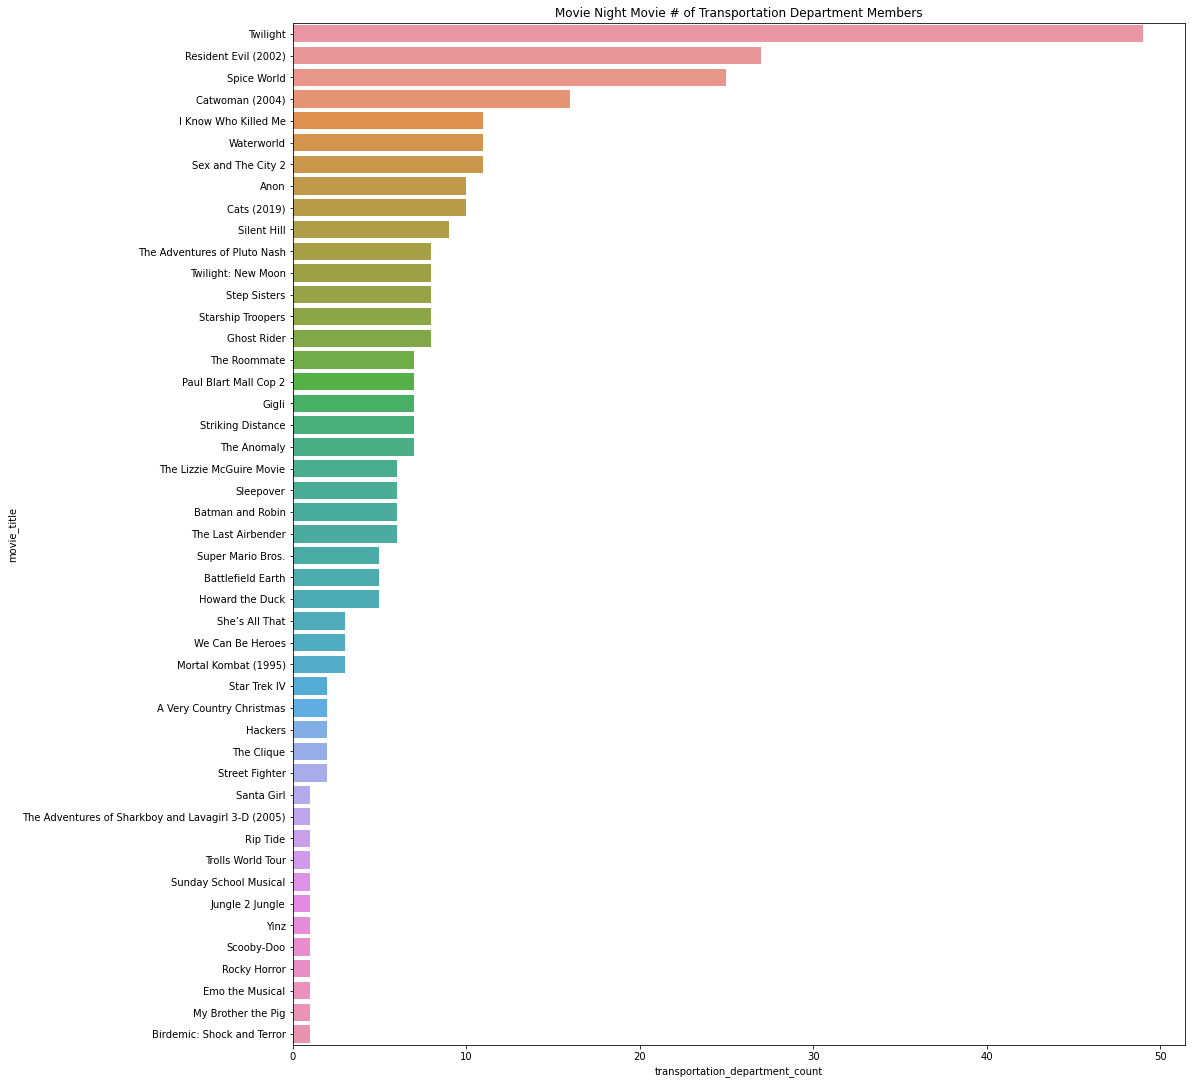

In [288]:
sorted_countplot('transportation_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Transportation Department Members', 
                 figure_name=False, 
                 ascending=False)

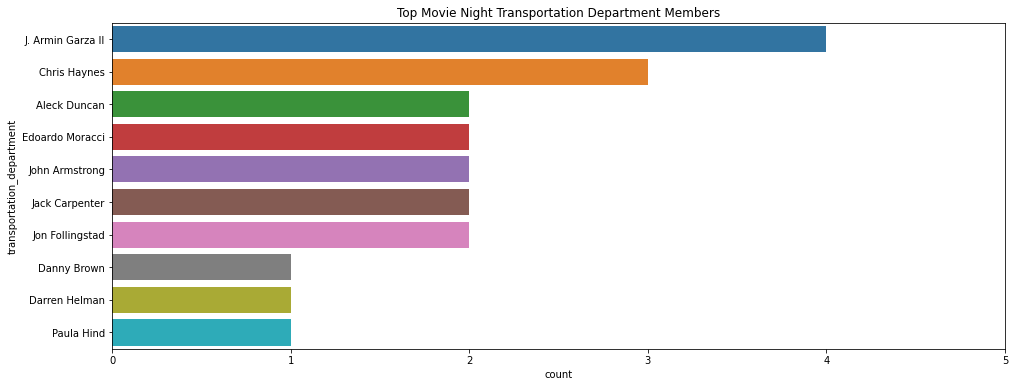

In [289]:
aggregate_countplot('transportation_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Transportation Department Members', 
                    figure_name=False)

### Miscellaneous

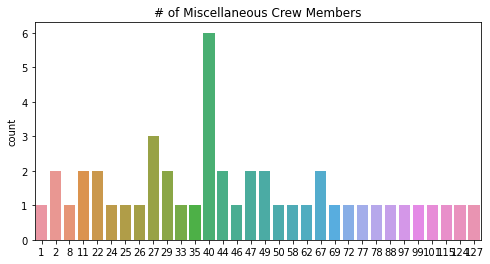

In [290]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['miscellaneous_count'].values)
plt.title('# of Miscellaneous Crew Members')
plt.show()

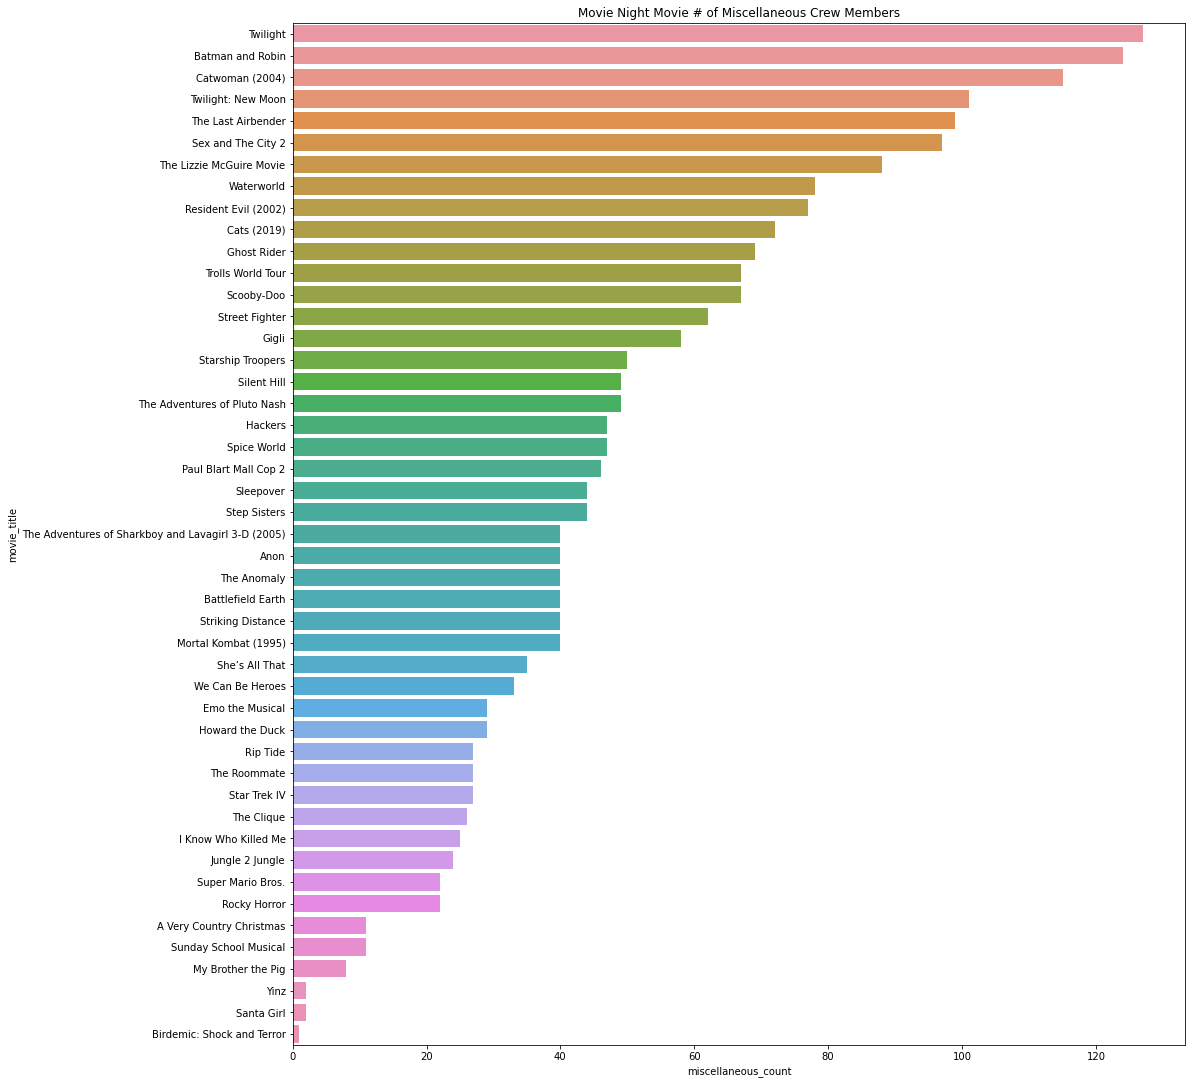

In [291]:
sorted_countplot('miscellaneous_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Miscellaneous Crew Members', 
                 figure_name=False, 
                 ascending=False)

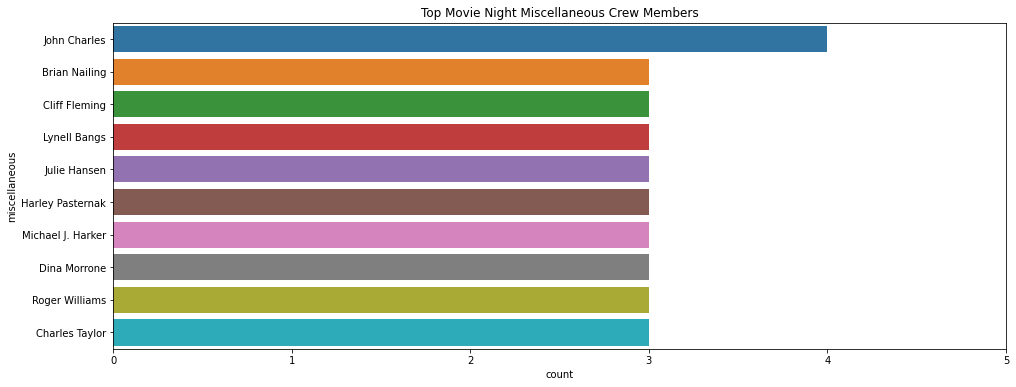

In [292]:
aggregate_countplot('miscellaneous',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Miscellaneous Crew Members', 
                    figure_name=False)

### Total Unique Movie People

In [401]:
people_flags = ['cast', 'producers', 'composers', 'cinematographers', 'editors', 'editorial department', 
                'casting directors', 'production designers', 'art directors', 'set decorators', 
                'costume designers', 'make up department', 'production managers', 'assistant directors', 
                'art department', 'sound department', 'special effects', 'visual effects', 'stunts', 
                'camera department', 'animation department', 'casting department', 'costume departmen', 
                'location management', 'music department', 'script department', 'transportation department', 
                'miscellaneous', 'writer', 'director']

closed_people_flags = [re.sub(' ', '_', x) for x in people_flags]

In [ ]:
# helper functions
def clean_names(names):
    name_list = [name.strip() for name in names.split(';')]
    filtered_list = [name for name in name_list if name != '']
    return '; '.join(filtered_list)

def filter_unique(names):
    name_list = [name.strip() for name in names.split(';')]
    return '; '.join(list(set(name_list)))

In [407]:
def add_all_names(df):
    df['all_names'] = ''
    for flag in closed_people_flags:
        if flag == closed_people_flags[0]:
            df['all_names'] += df[flag] 
        else:
            df['all_names'] += '; ' + df[flag]
    
    df['all_names'] = df['all_names'].apply(clean_names)
    df['unique_names'] = df['all_names'].apply(filter_unique)
    
    df['total_people_count'] = df['all_names'].apply(lambda x: len(x.split(';')))
    df['total_unique_people_count'] =df['unique_names'].apply(lambda x: len(x.split(';')))
    
    return df

In [408]:
movie_df = add_all_names(movie_df)
top100_df = add_all_names(top100_df)
bottom100_df = add_all_names(bottom100_df)

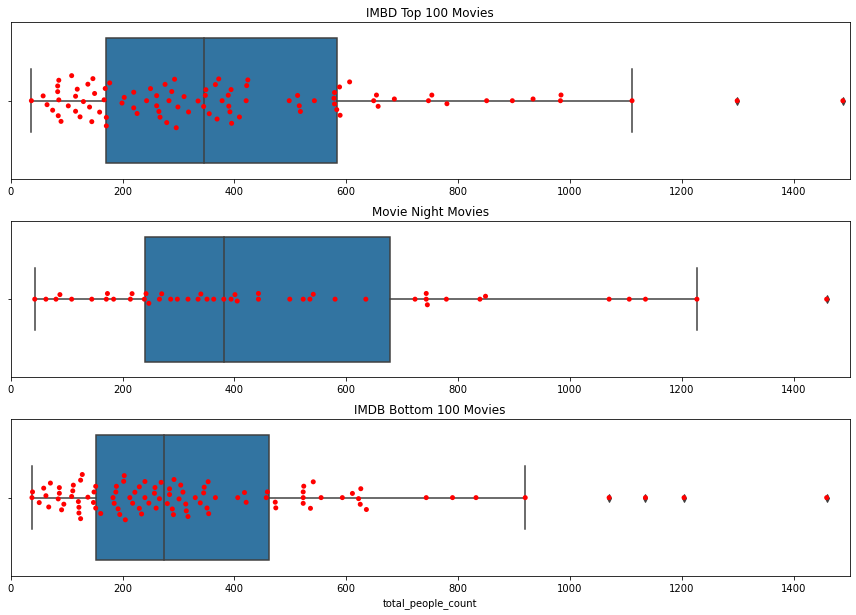

In [410]:
comparative_boxplot('total_people_count', top100_df, movie_df, bottom100_df, plot_range=[0,1500])

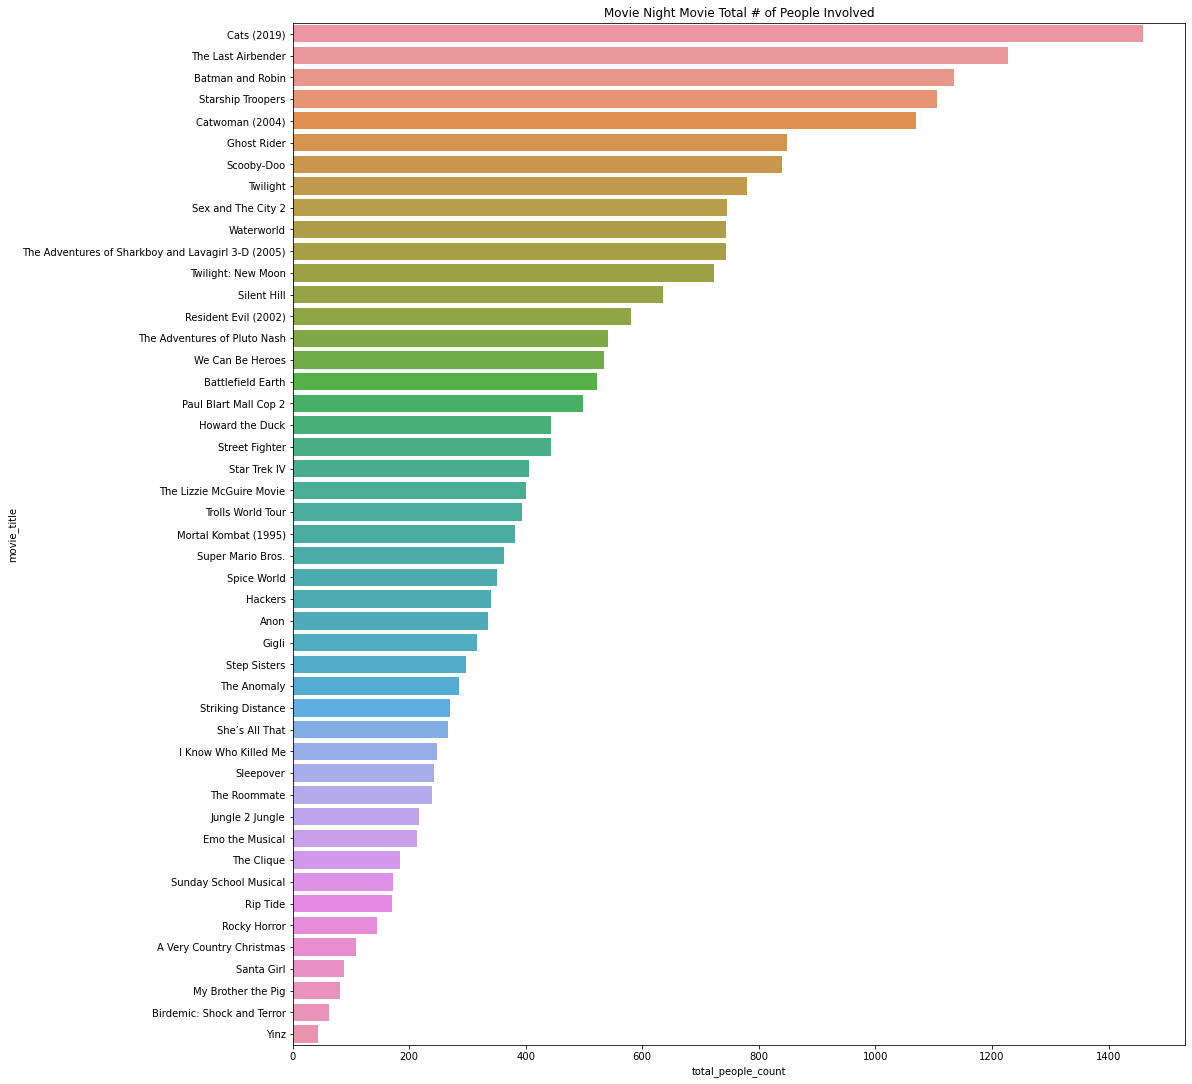

In [411]:
sorted_countplot('total_people_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie Total # of People Involved', 
                 figure_name=False, 
                 ascending=False)

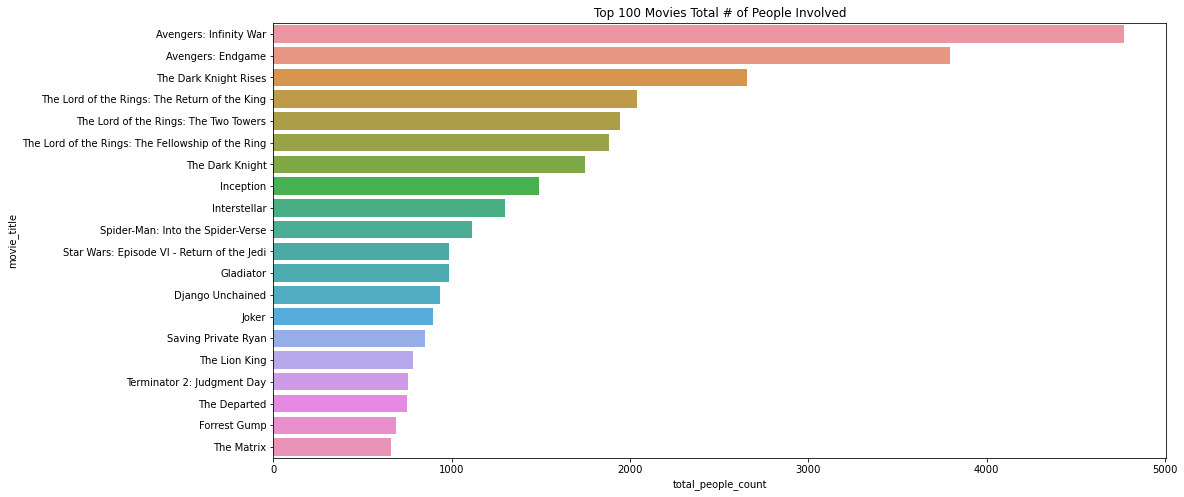

In [412]:
sorted_countplot('total_people_count', 
                 top100_df, 
                 num_items=20, 
                 title='Top 100 Movies Total # of People Involved', 
                 figure_name=False, 
                 ascending=False)

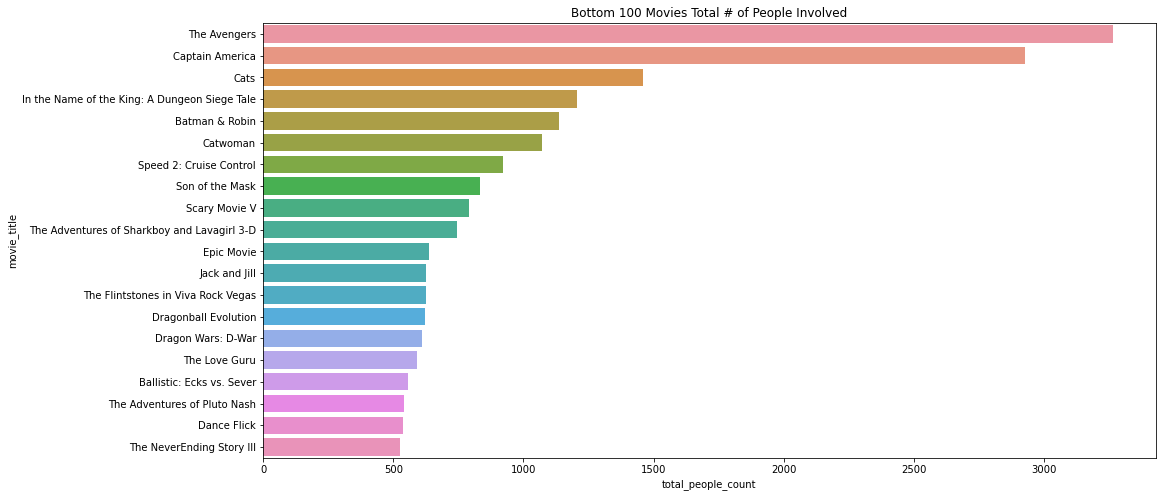

In [413]:
sorted_countplot('total_people_count', 
                 bottom100_df, 
                 num_items=20, 
                 title='Bottom 100 Movies Total # of People Involved', 
                 figure_name=False, 
                 ascending=False)

## Movie Companies

* Production Companies
* Distributors
* Special Effects Companies
* Other Companies

### Production Companies

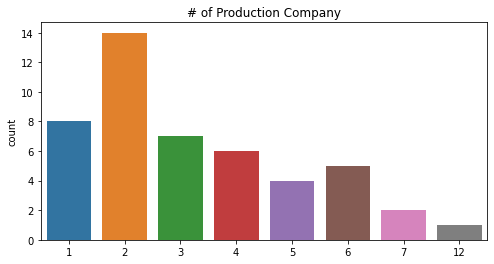

In [299]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['production_companies_count'].values)
plt.title('# of Production Company')
plt.show()

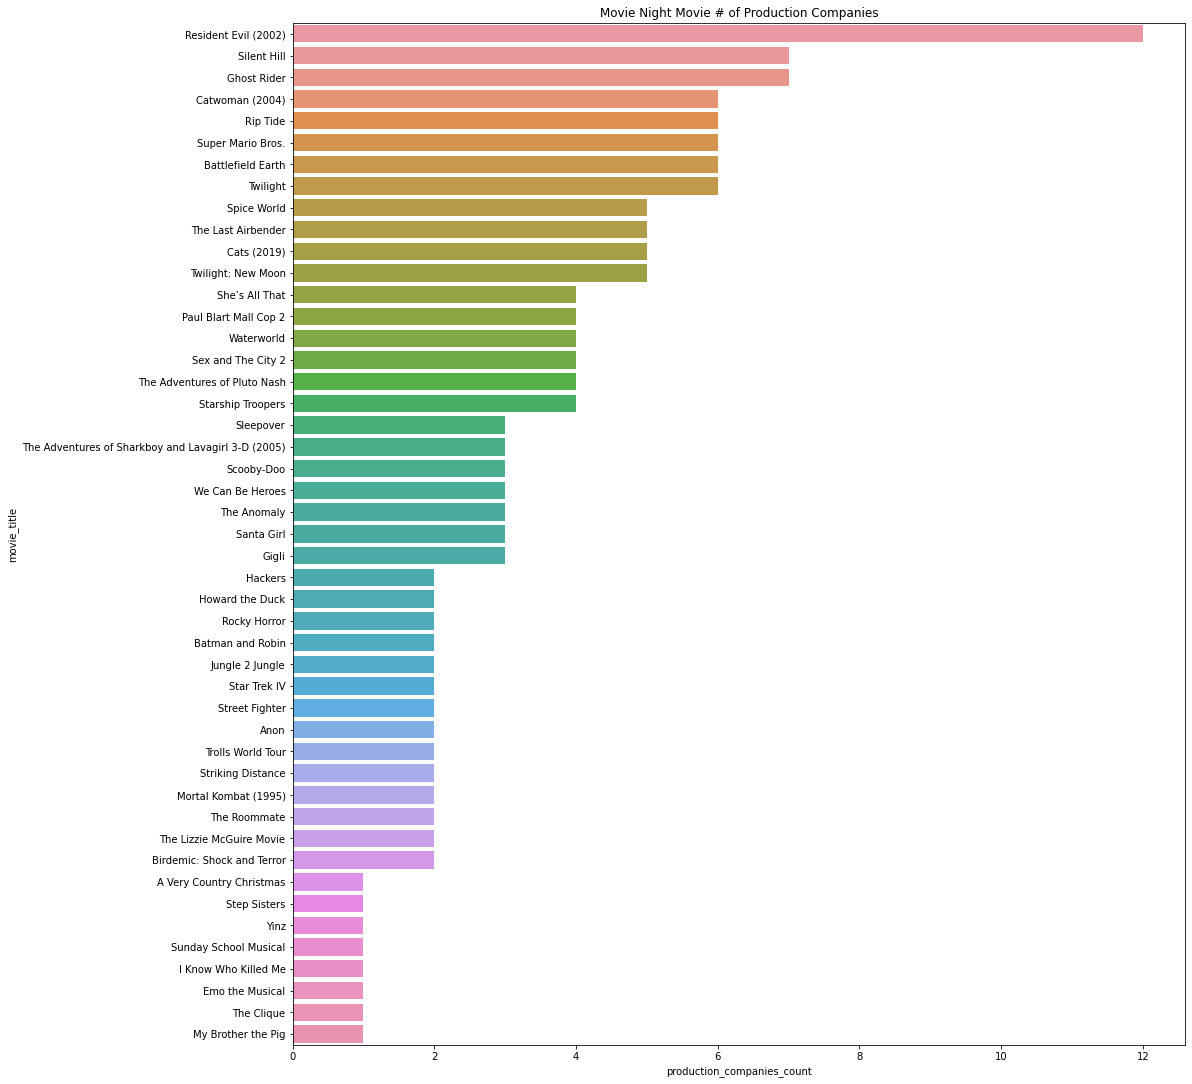

In [300]:
sorted_countplot('production_companies_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Production Companies', 
                 figure_name=False, 
                 ascending=False)

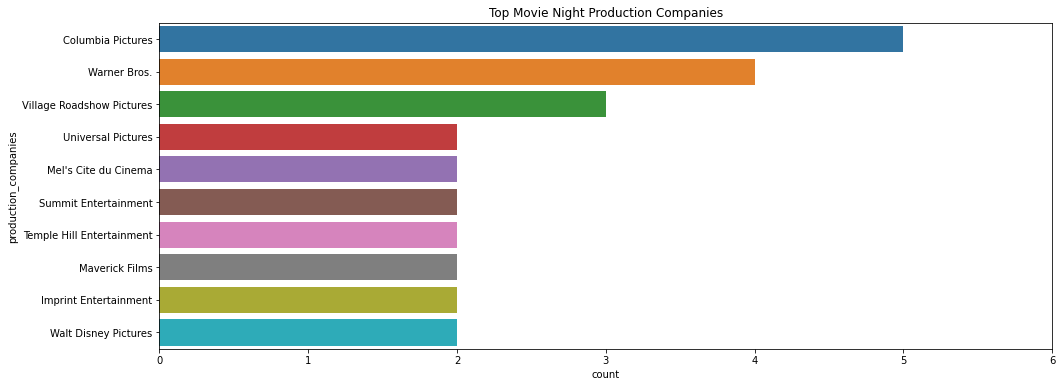

In [301]:
aggregate_countplot('production_companies',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,6],
                    title='Top Movie Night Production Companies', 
                    figure_name=False)

### Distributors

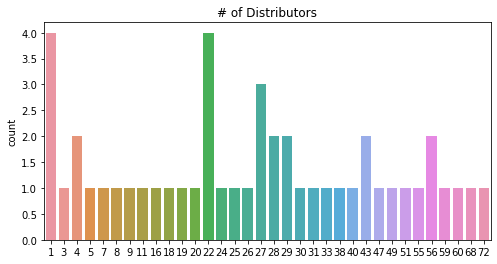

In [302]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['distributors_count'].values)
plt.title('# of Distributors')
plt.show()

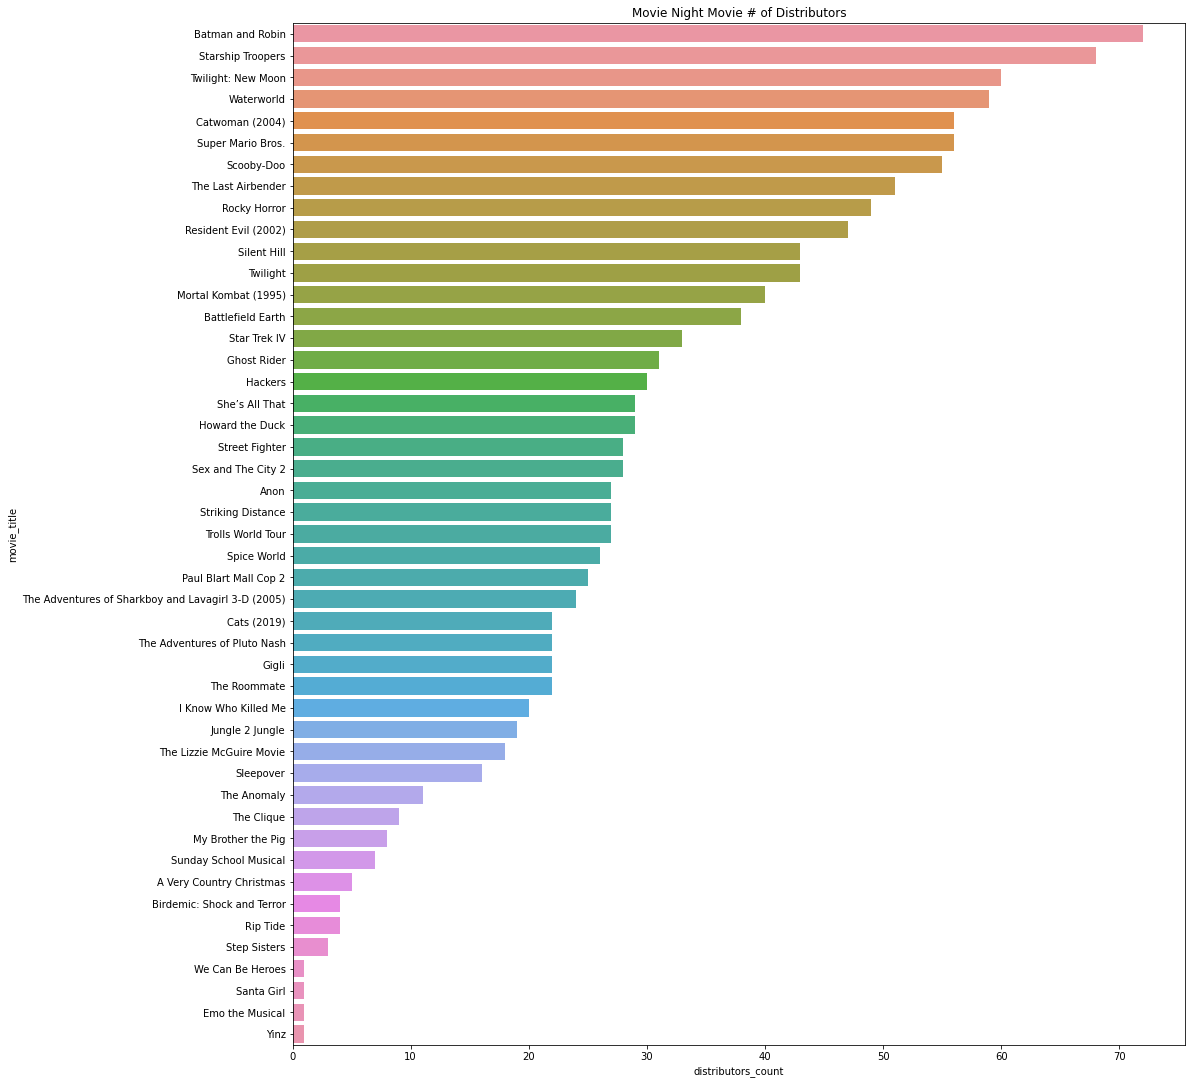

In [303]:
sorted_countplot('distributors_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Distributors', 
                 figure_name=False, 
                 ascending=False)

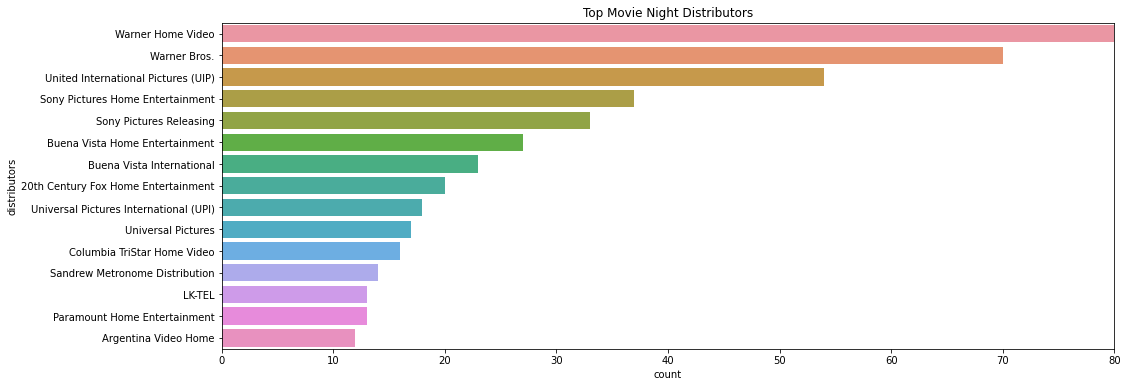

In [304]:
aggregate_countplot('distributors',
                    movie_df, 
                    num_items=15, 
                    plot_range=[0,80],
                    title='Top Movie Night Distributors', 
                    figure_name=False)

### Special Effects Companies

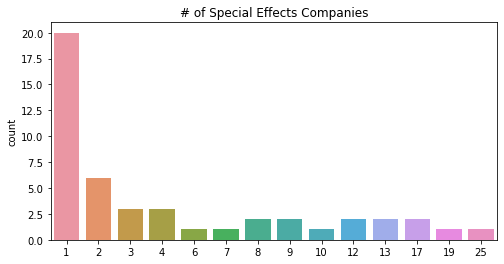

In [305]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['special_effects_companies_count'].values)
plt.title('# of Special Effects Companies')
plt.show()

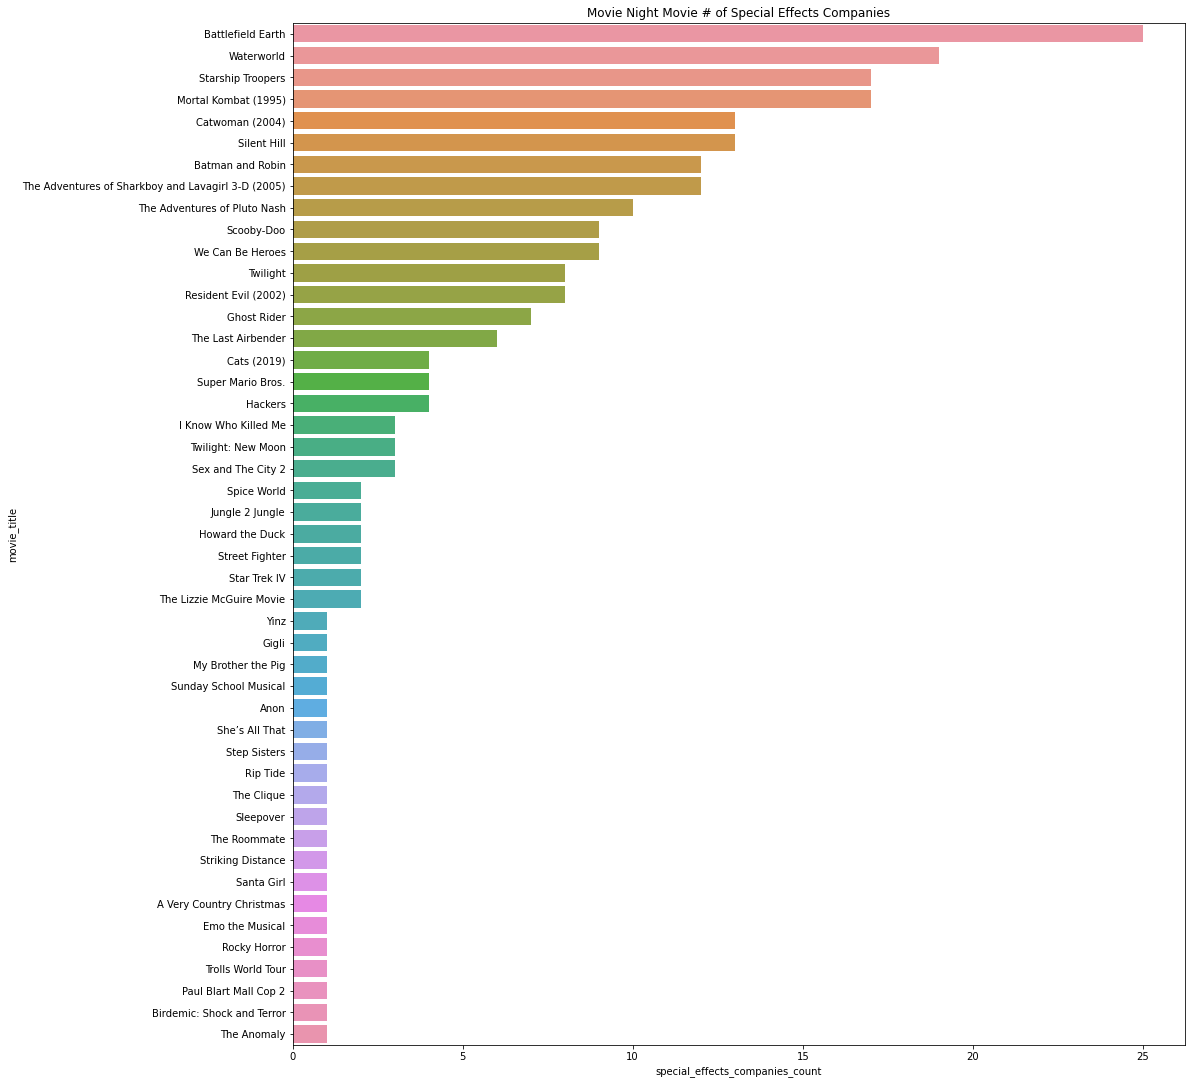

In [306]:
sorted_countplot('special_effects_companies_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Special Effects Companies', 
                 figure_name=False, 
                 ascending=False)

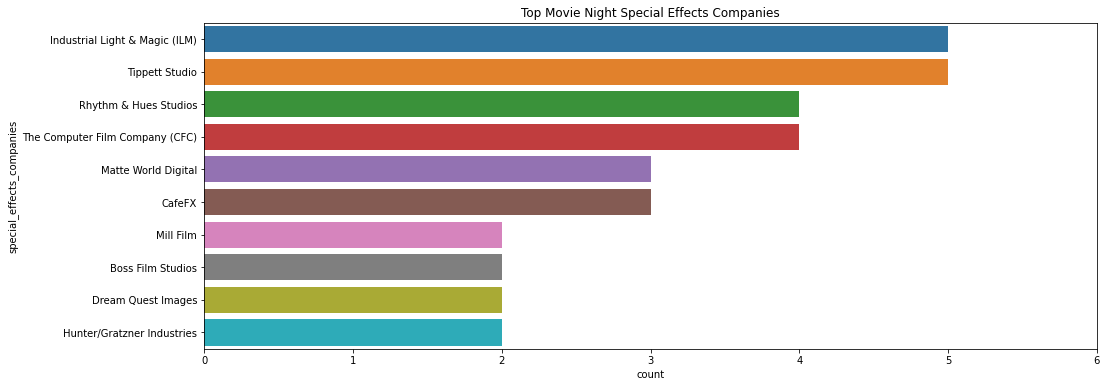

In [307]:
aggregate_countplot('special_effects_companies',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,6],
                    title='Top Movie Night Special Effects Companies', 
                    figure_name=False)

### Other Companies

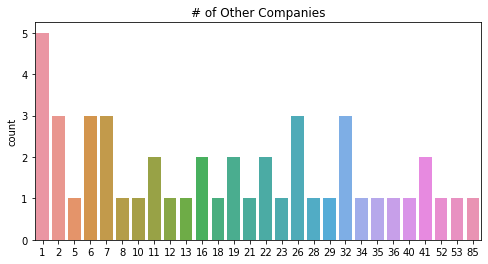

In [308]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['other_companies_count'].values)
plt.title('# of Other Companies')
plt.show()

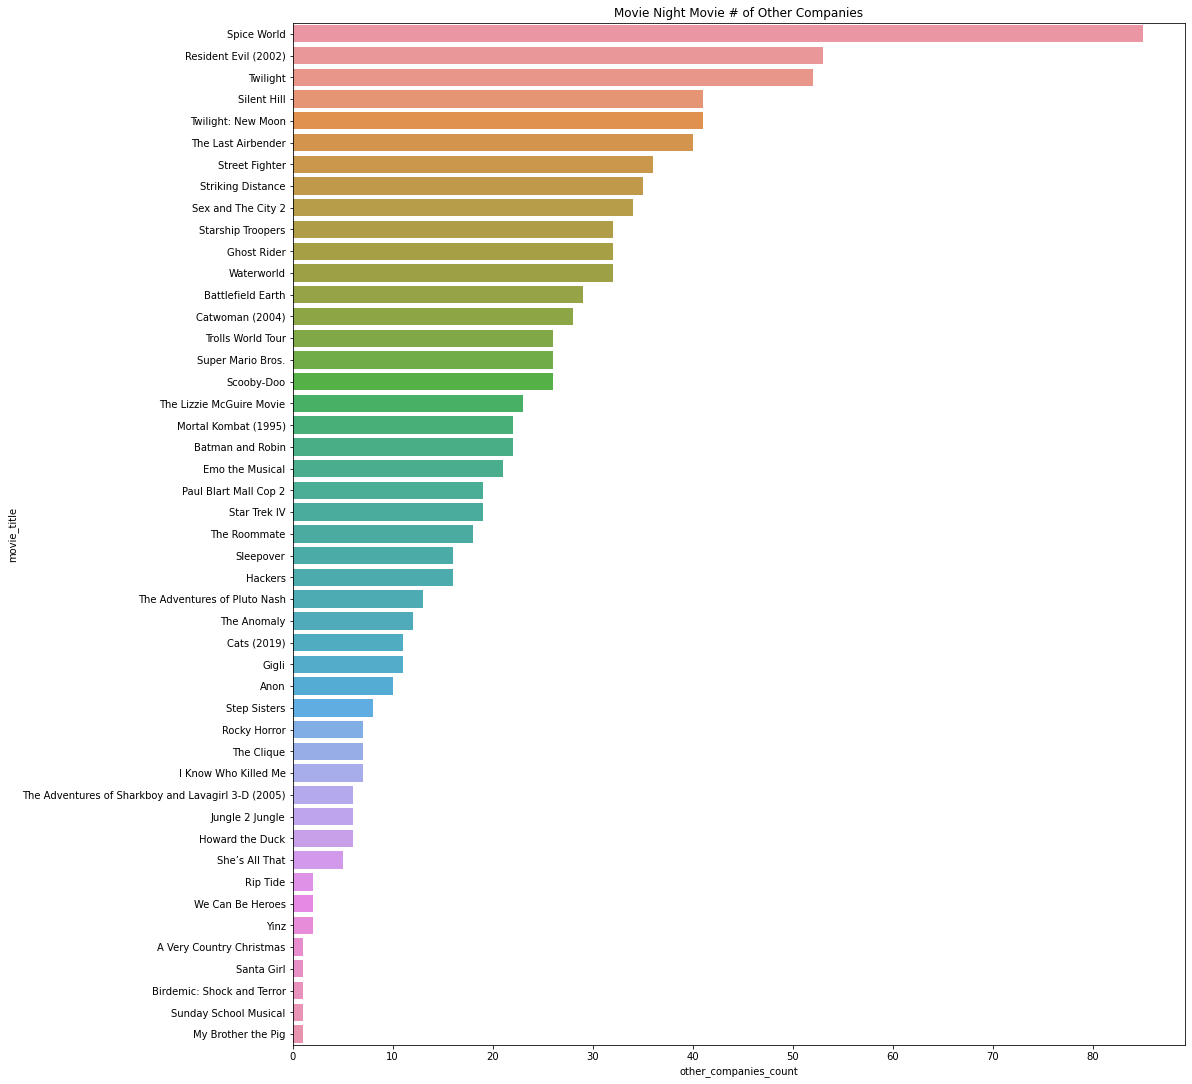

In [309]:
sorted_countplot('other_companies_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Other Companies', 
                 figure_name=False, 
                 ascending=False)

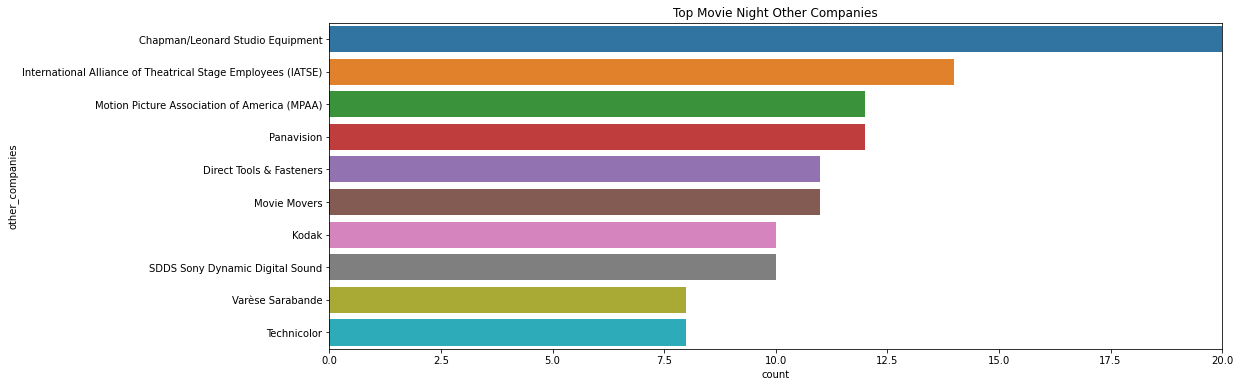

In [310]:
aggregate_countplot('other_companies',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,20],
                    title='Top Movie Night Other Companies', 
                    figure_name=False)

## Money Variables

NOTE:  Monetary values have been adjusted for inflation. 

* Budget
* Opening Weekend USA
* Gross USA
* Cumulative Worldwide Gross
* Profit 
* Profit Margin

### Budget (Inflation Adjusted)

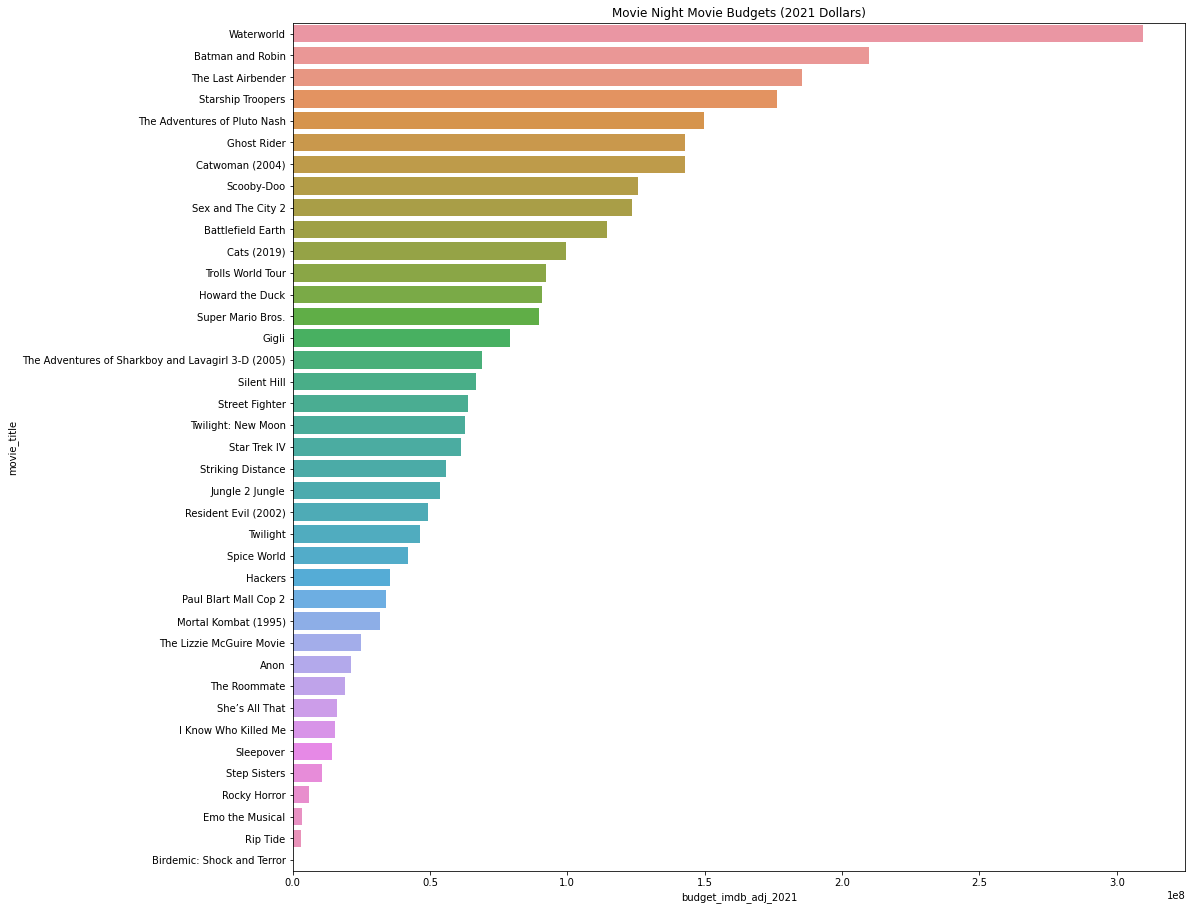

In [514]:
sorted_countplot('budget_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie Budgets (2021 Dollars)', 
                 figure_name='images/budget_bara', 
                 ascending=False)

In [556]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

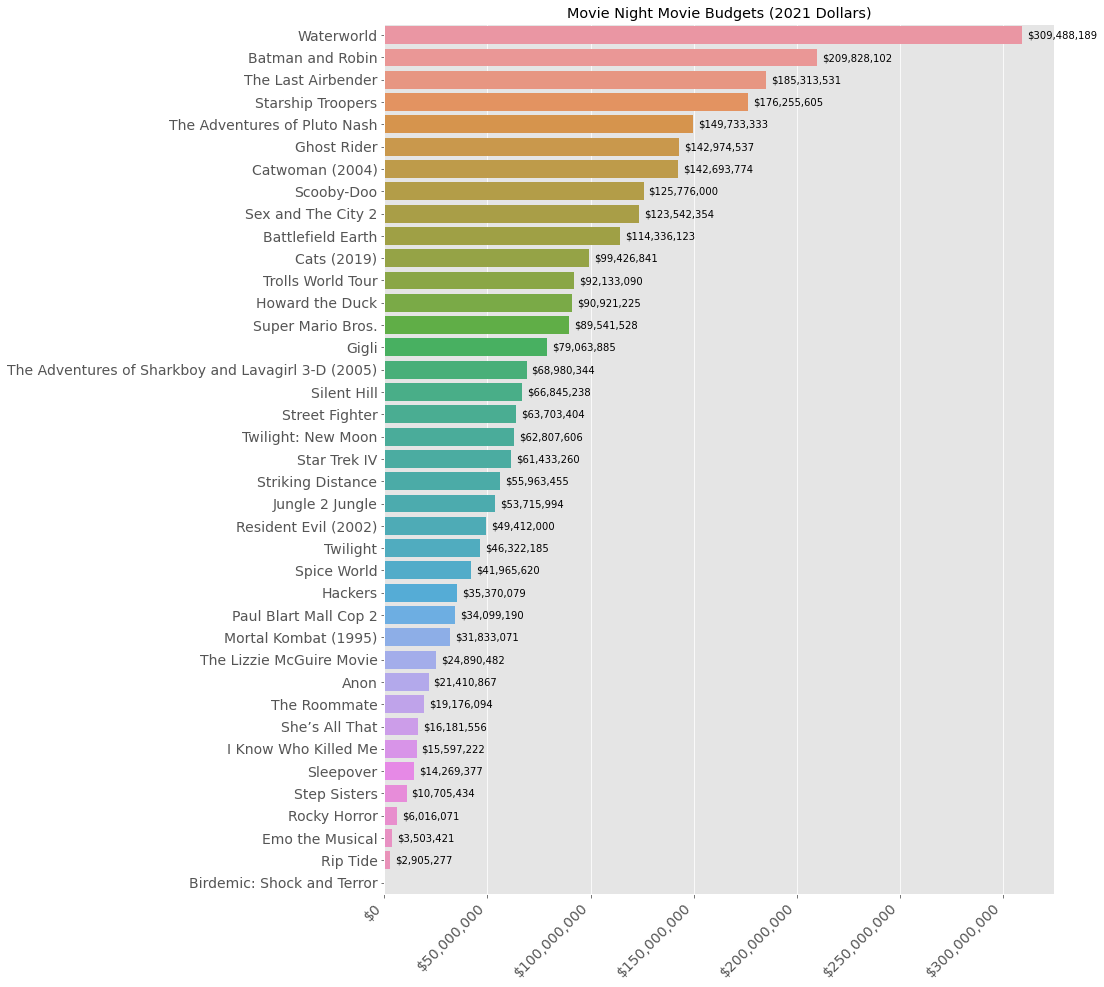

In [579]:
budget_sorted = movie_df.sort_values(by='budget_imdb_adj_2021', ascending=False).reset_index(drop=True)
budget_sorted = budget_sorted[(budget_sorted['budget_imdb_adj_2021'] != 0) & (budget_sorted['budget_imdb_adj_2021'] != 0.0)]

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=budget_sorted['budget_imdb_adj_2021'], y=budget_sorted['movie_title'])
plt.title('Movie Night Movie Budgets (2021 Dollars)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 1),
                xytext=(5, 10), textcoords='offset points')
plt.savefig('images/budget_clean.png', bbox_inches='tight')
plt.show()

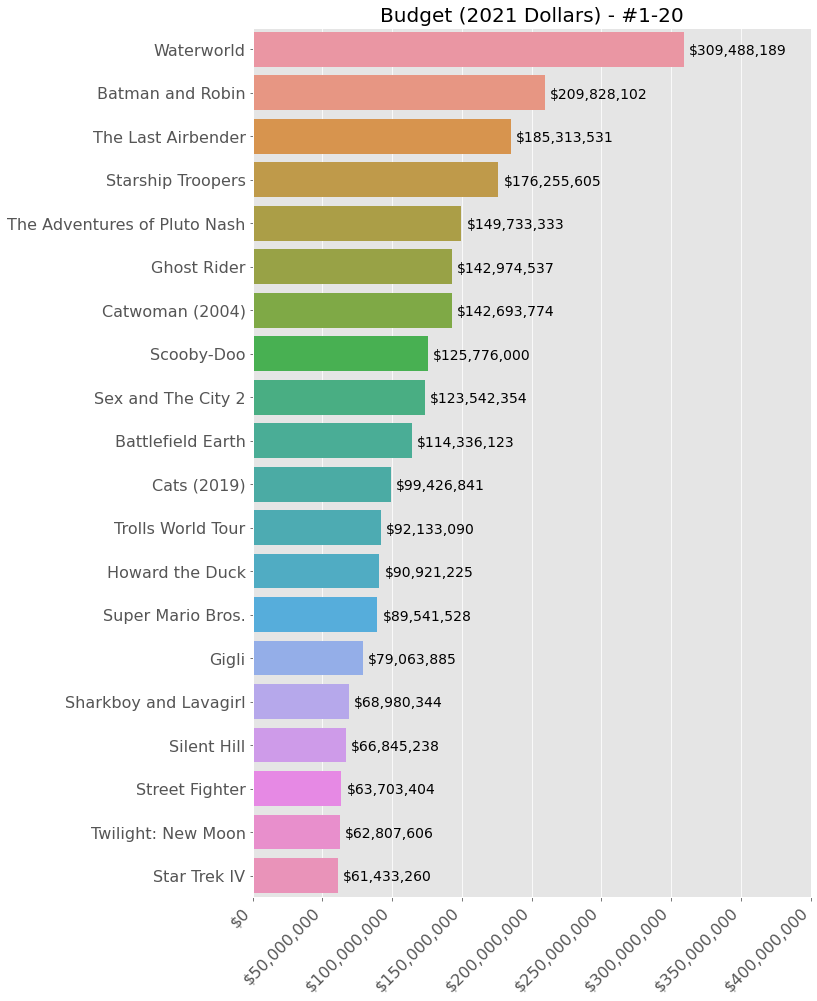

In [675]:
budget_sorted = movie_df.sort_values(by='budget_imdb_adj_2021', ascending=False).reset_index(drop=True)
budget_sorted = budget_sorted[(budget_sorted['budget_imdb_adj_2021'] != 0) & (budget_sorted['budget_imdb_adj_2021'] != 0.0)]
budget_sorted.loc[budget_sorted['movie_title'] == 'The Adventures of Sharkboy and Lavagirl 3-D (2005)', 'movie_title'] = 'Sharkboy and Lavagirl'

fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=budget_sorted['budget_imdb_adj_2021'][:20], y=budget_sorted['movie_title'][:20])
plt.title('Budget (2021 Dollars) - #1-20', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([0,400000000])


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/budget_clean_1.png', bbox_inches='tight')
plt.show() 

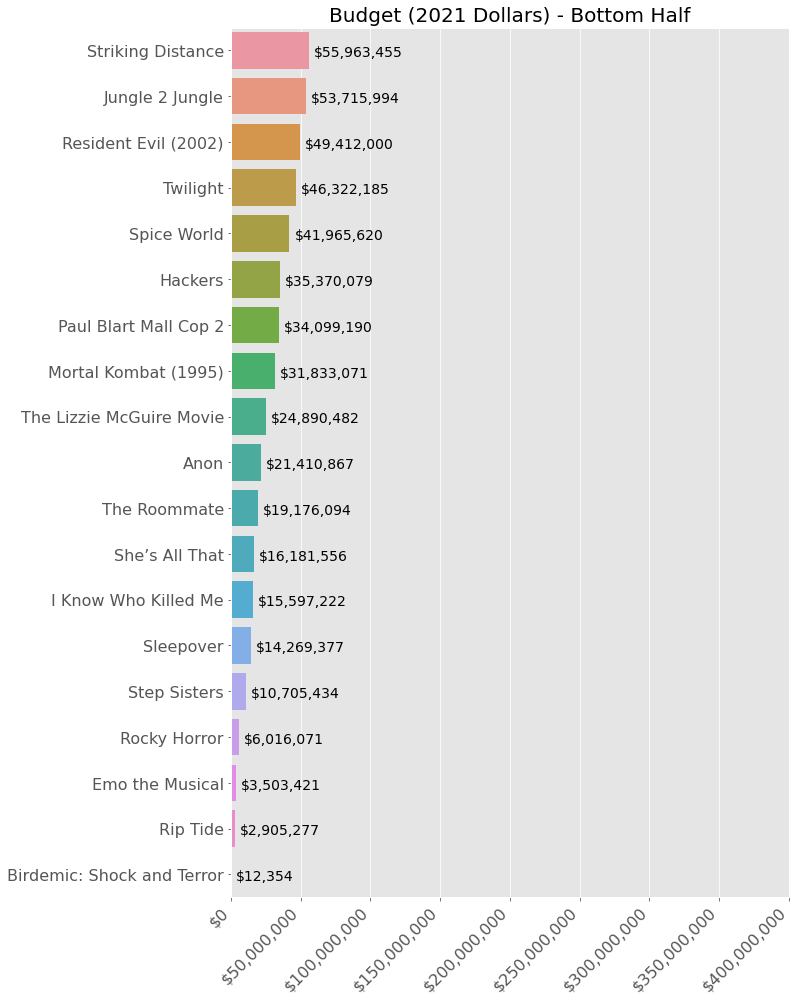

In [677]:
budget_sorted = movie_df.sort_values(by='budget_imdb_adj_2021', ascending=False).reset_index(drop=True)
budget_sorted = budget_sorted[(budget_sorted['budget_imdb_adj_2021'] != 0) & (budget_sorted['budget_imdb_adj_2021'] != 0.0)]

fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=budget_sorted['budget_imdb_adj_2021'][20:], y=budget_sorted['movie_title'][20:])
plt.title('Budget (2021 Dollars) - Bottom Half', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([0,400000000])

for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/budget_clean_2.png', bbox_inches='tight')
plt.show()

In [515]:
movie_df[movie_df['budget_imdb_adj_2021'] == 0]['original_title'].values

array(['Sunday School Musical (2008)', 'The Clique (2008)', 'Yinz (2018)',
       'The Anomaly (2014)', 'A Very Country Christmas (2017)',
       'Santa Girl (2019)', 'We Can Be Heroes (2020)',
       'My Brother the Pig (1999)'], dtype=object)

In [495]:
print('Inflation Adjusted Budget Stats')
print('\n')
print('Highest Budget:')
print(movie_df[movie_df['budget_imdb_adj_2021'] == max(movie_df['budget_imdb_adj_2021'])]['original_title'].values[0])
print('$' + str(round(movie_df[movie_df['budget_imdb_adj_2021'] == max(movie_df['budget_imdb_adj_2021'])]['budget_imdb_adj_2021'].values[0],-2)))
print('\n')

budget_filtered_df = movie_df.loc[movie_df['budget_imdb_adj_2021'] > 0, :]

print('Lowest Budget:')
print(budget_filtered_df[budget_filtered_df['budget_imdb_adj_2021'] == min(budget_filtered_df['budget_imdb_adj_2021'])]['original_title'].values[0])
print('$' + str(round(budget_filtered_df[budget_filtered_df['budget_imdb_adj_2021'] == min(budget_filtered_df['budget_imdb_adj_2021'])]['budget_imdb_adj_2021'].values[0],-2)))
print('\n')
print('Average Budget:')
print('$' + str(round(np.mean(budget_filtered_df['budget_imdb_adj_2021'].values), -2)))
print('\n')
print('Cumulative Budget:')
print('$' + str(round(sum(budget_filtered_df['budget_imdb_adj_2021'].values), -2)))

Inflation Adjusted Budget Stats


Highest Budget:
Waterworld (1995)
$309488200.0


Lowest Budget:
Birdemic: Shock and Terror (2010)
$12400.0


Average Budget:
$75337100.0


Cumulative Budget:
$2938147700.0


In [494]:
print('Raw Budget Stats')
print('\n')
print('Highest Budget:')
print(movie_df[movie_df['budget_imdb'] == max(movie_df['budget_imdb'])]['original_title'].values[0])
print('$' + str(round(movie_df[movie_df['budget_imdb'] == max(movie_df['budget_imdb'])]['budget_imdb'].values[0],-2)))
print('\n')

budget_filtered_df = movie_df.loc[movie_df['budget_imdb'] > 0, :]

print('Lowest Budget:')
print(budget_filtered_df[budget_filtered_df['budget_imdb'] == min(budget_filtered_df['budget_imdb'])]['original_title'].values[0])
print('$' + str(round(budget_filtered_df[budget_filtered_df['budget_imdb'] == min(budget_filtered_df['budget_imdb'])]['budget_imdb'].values[0],-2)))
print('\n')
print('Average Budget:')
print('$' + str(round(np.mean(budget_filtered_df['budget_imdb'].values), -2)))
print('\n')
print('Cumulative Budget:')
print('$' + str(round(sum(budget_filtered_df['budget_imdb'].values), -2)))

Raw Budget Stats


Highest Budget:
Waterworld (1995)
$175000000


Lowest Budget:
Birdemic: Shock and Terror (2010)
$10000


Average Budget:
$50845700.0


Cumulative Budget:
$1982981400


### Domestic Opening Weekend Earnings

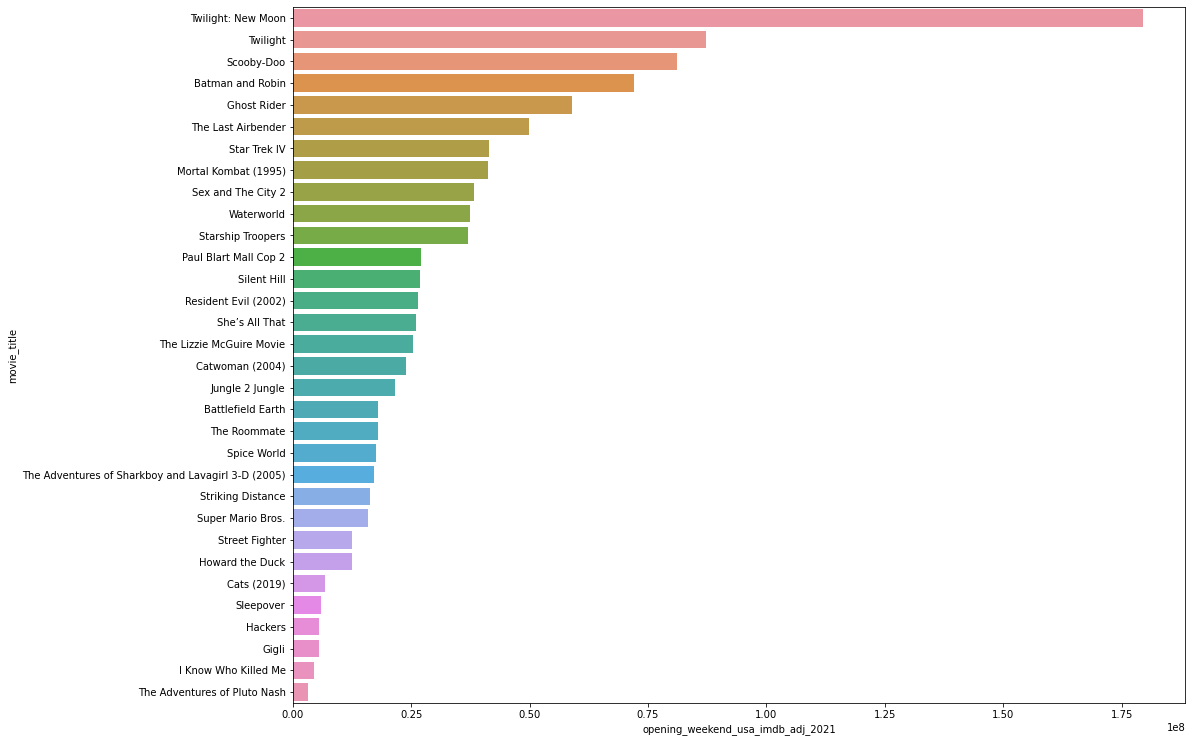

In [312]:
sorted_countplot('opening_weekend_usa_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Gross Domestic Earnings

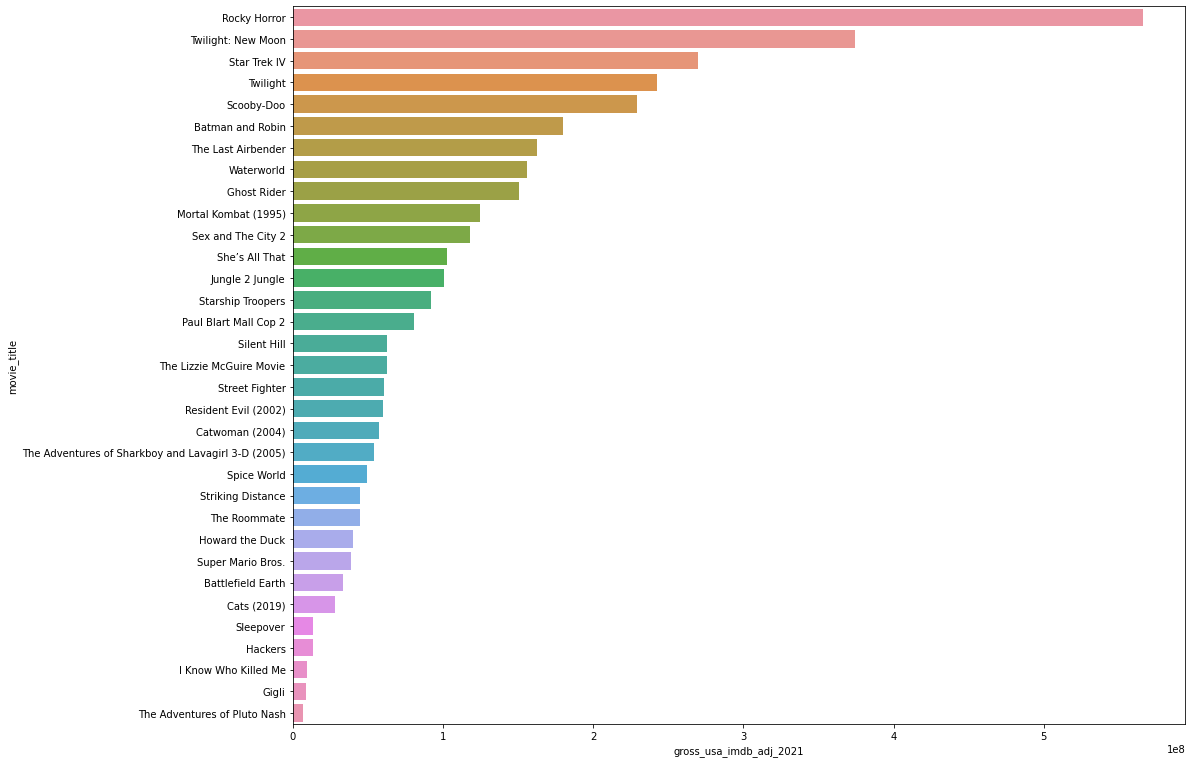

In [313]:
sorted_countplot('gross_usa_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Cumulative Worldwide Earnings

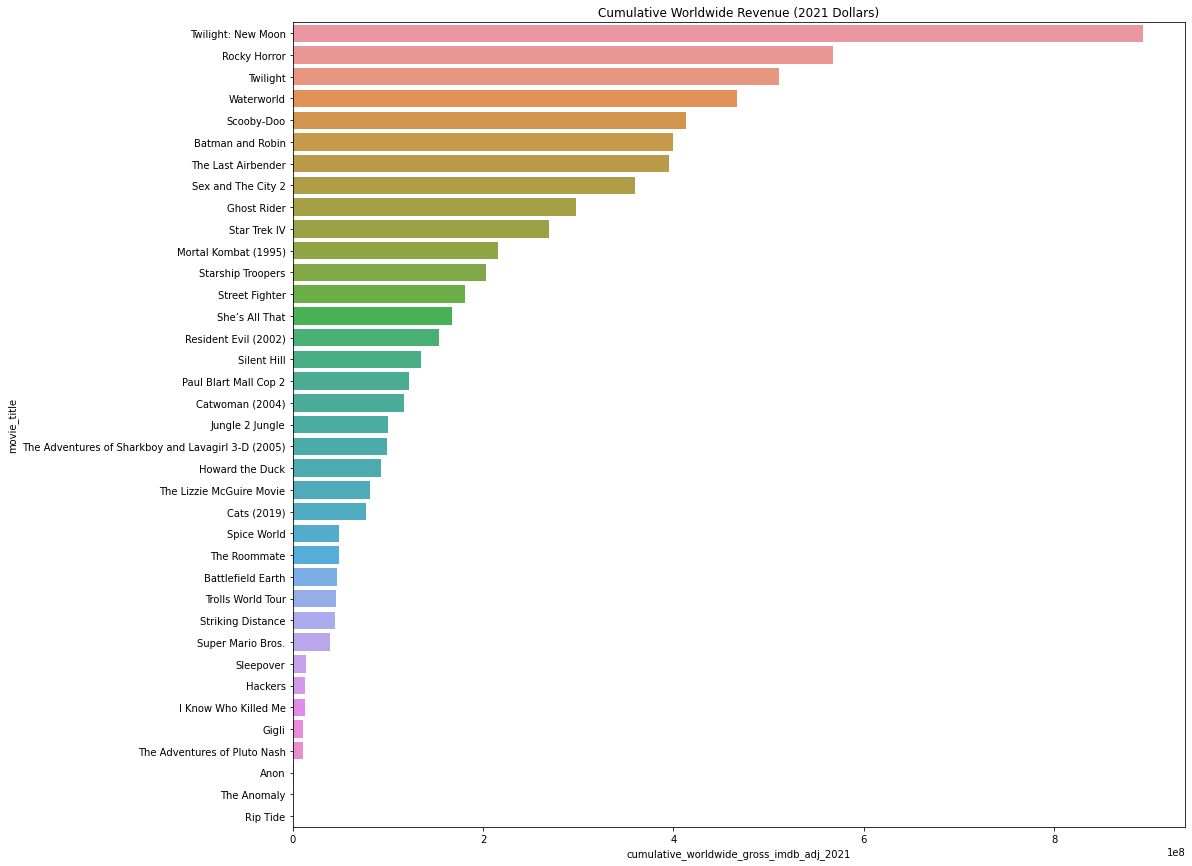

In [519]:
sorted_countplot('cumulative_worldwide_gross_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title='Cumulative Worldwide Revenue (2021 Dollars)', 
                 figure_name='images/cumulative_worldwide_revenue', 
                 ascending=False)

In [516]:
print('Inflation Adjusted Worldwide Revenue Stats')
print('\n')
print('Highest Worldwide Revenue:')
print(movie_df[movie_df['cumulative_worldwide_gross_imdb_adj_2021'] == max(movie_df['cumulative_worldwide_gross_imdb_adj_2021'])]['original_title'].values[0])
print('$' + str(round(movie_df[movie_df['cumulative_worldwide_gross_imdb_adj_2021'] == max(movie_df['cumulative_worldwide_gross_imdb_adj_2021'])]['cumulative_worldwide_gross_imdb_adj_2021'].values[0],-2)))
print('\n')

revenue_filtered_df = movie_df.loc[movie_df['cumulative_worldwide_gross_imdb_adj_2021'] > 0, :]

print('Lowest Worldwide Revenue:')
print(revenue_filtered_df[revenue_filtered_df['cumulative_worldwide_gross_imdb_adj_2021'] == min(revenue_filtered_df['cumulative_worldwide_gross_imdb_adj_2021'])]['original_title'].values[0])
print('$' + str(round(revenue_filtered_df[revenue_filtered_df['cumulative_worldwide_gross_imdb_adj_2021'] == min(revenue_filtered_df['cumulative_worldwide_gross_imdb_adj_2021'])]['cumulative_worldwide_gross_imdb_adj_2021'].values[0],-2)))
print('\n')
print('Average Worldwide Revenue:')
print('$' + str(round(np.mean(revenue_filtered_df['cumulative_worldwide_gross_imdb_adj_2021'].values), -2)))
print('\n')
print('Total Worldwide Revenue:')
print('$' + str(round(sum(revenue_filtered_df['cumulative_worldwide_gross_imdb_adj_2021'].values), -2)))

Inflation Adjusted Worldwide Revenue Stats


Highest Worldwide Revenue:
The Twilight Saga: New Moon (2009)
$893156200.0


Lowest Worldwide Revenue:
Rip Tide (2017)
$215200.0


Average Worldwide Revenue:
$179956500.0


Total Worldwide Revenue:
$6658391500.0


In [517]:
print('Raw Worldwide Revenue Stats')
print('\n')
print('Highest Worldwide Revenue:')
print(movie_df[movie_df['cumulative_worldwide_gross_imdb'] == max(movie_df['cumulative_worldwide_gross_imdb'])]['original_title'].values[0])
print('$' + str(round(movie_df[movie_df['cumulative_worldwide_gross_imdb'] == max(movie_df['cumulative_worldwide_gross_imdb'])]['cumulative_worldwide_gross_imdb'].values[0],-2)))
print('\n')

revenue_filtered_df = movie_df.loc[movie_df['cumulative_worldwide_gross_imdb'] > 0, :]

print('Lowest Worldwide Revenue:')
print(revenue_filtered_df[revenue_filtered_df['cumulative_worldwide_gross_imdb'] == min(revenue_filtered_df['cumulative_worldwide_gross_imdb'])]['original_title'].values[0])
print('$' + str(round(revenue_filtered_df[revenue_filtered_df['cumulative_worldwide_gross_imdb'] == min(revenue_filtered_df['cumulative_worldwide_gross_imdb'])]['cumulative_worldwide_gross_imdb'].values[0],-2)))
print('\n')
print('Average Worldwide Revenue:')
print('$' + str(round(np.mean(revenue_filtered_df['cumulative_worldwide_gross_imdb'].values), -2)))
print('\n')
print('Total Worldwide Revenue:')
print('$' + str(round(sum(revenue_filtered_df['cumulative_worldwide_gross_imdb'].values), -2)))

Raw Worldwide Revenue Stats


Highest Worldwide Revenue:
The Twilight Saga: New Moon (2009)
$711025500


Lowest Worldwide Revenue:
Rip Tide (2017)
$196500


Average Worldwide Revenue:
$117055300.0


Total Worldwide Revenue:
$4331044700


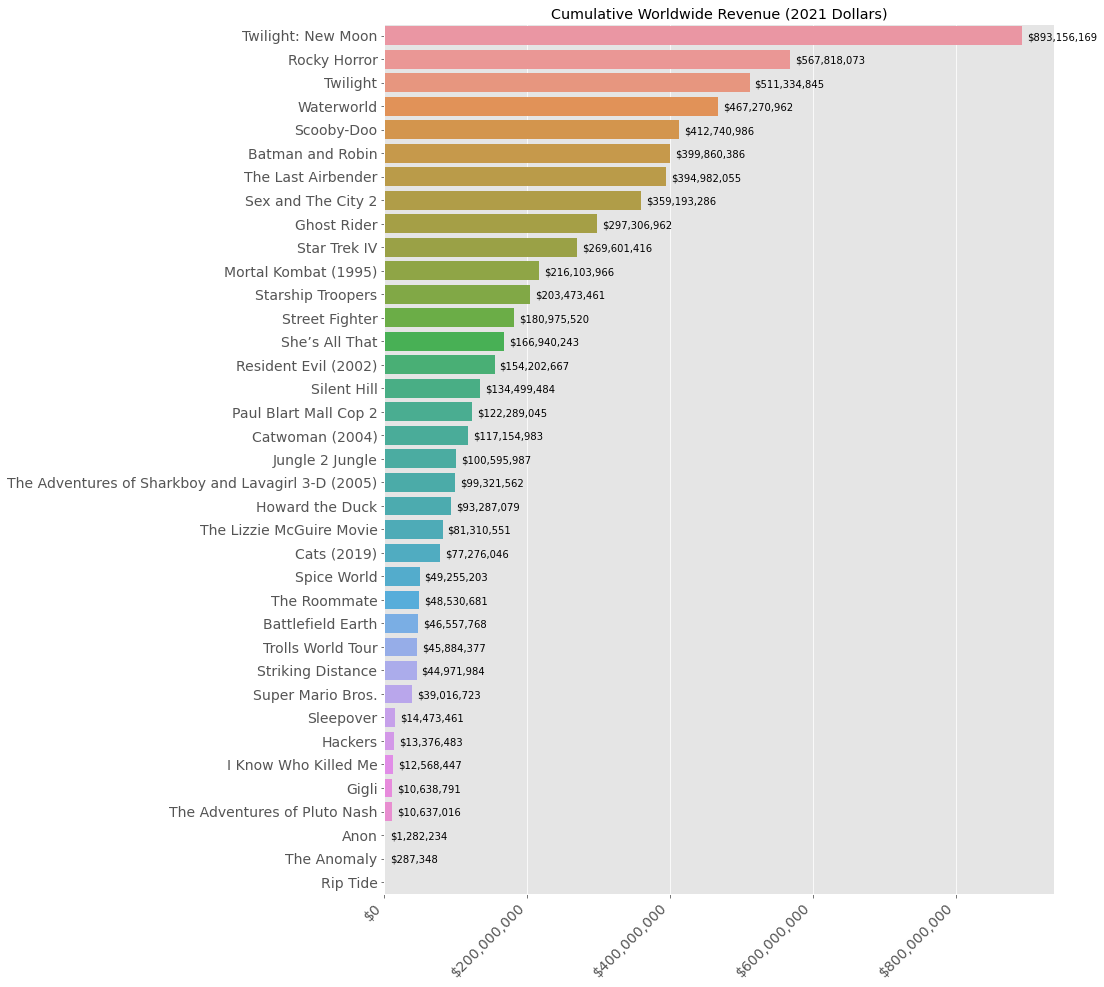

In [580]:
gross_worldwide_sorted = movie_df.sort_values(by='cumulative_worldwide_gross_imdb_adj_2021', ascending=False).reset_index(drop=True)
gross_worldwide_sorted = gross_worldwide_sorted[(gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'] != 0) & (gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'] != 0.0)]

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'], y=gross_worldwide_sorted['movie_title'])
plt.title('Cumulative Worldwide Revenue (2021 Dollars)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 1),
                xytext=(5, 10), textcoords='offset points')
plt.savefig('images/worldwide_revenue_clean.png', bbox_inches='tight')
plt.show()

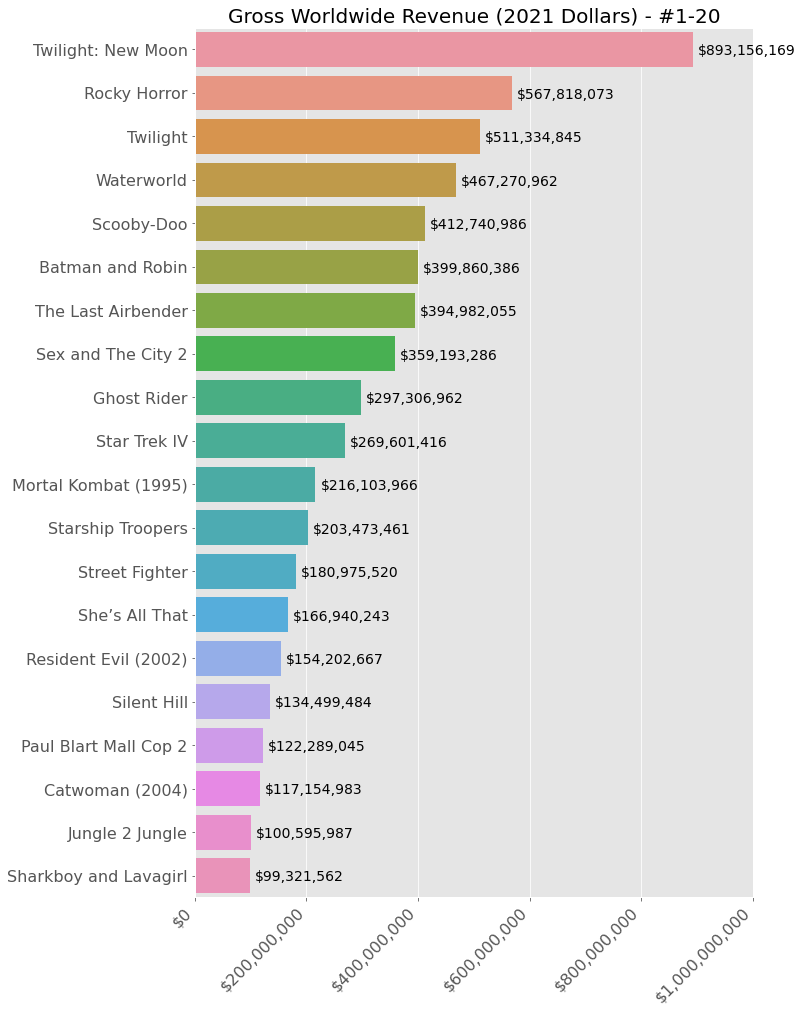

In [683]:
gross_worldwide_sorted = movie_df.sort_values(by='cumulative_worldwide_gross_imdb_adj_2021', ascending=False).reset_index(drop=True)
gross_worldwide_sorted = gross_worldwide_sorted[(gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'] != 0) & (gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'] != 0.0)]
gross_worldwide_sorted.loc[gross_worldwide_sorted['movie_title'] == 'The Adventures of Sharkboy and Lavagirl 3-D (2005)', 'movie_title'] = 'Sharkboy and Lavagirl'

fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'][:20], y=gross_worldwide_sorted['movie_title'][:20])
plt.title('Gross Worldwide Revenue (2021 Dollars) - #1-20', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([0,1000000000])


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/gross_worldwide_clean_1.png', bbox_inches='tight')
plt.show() 

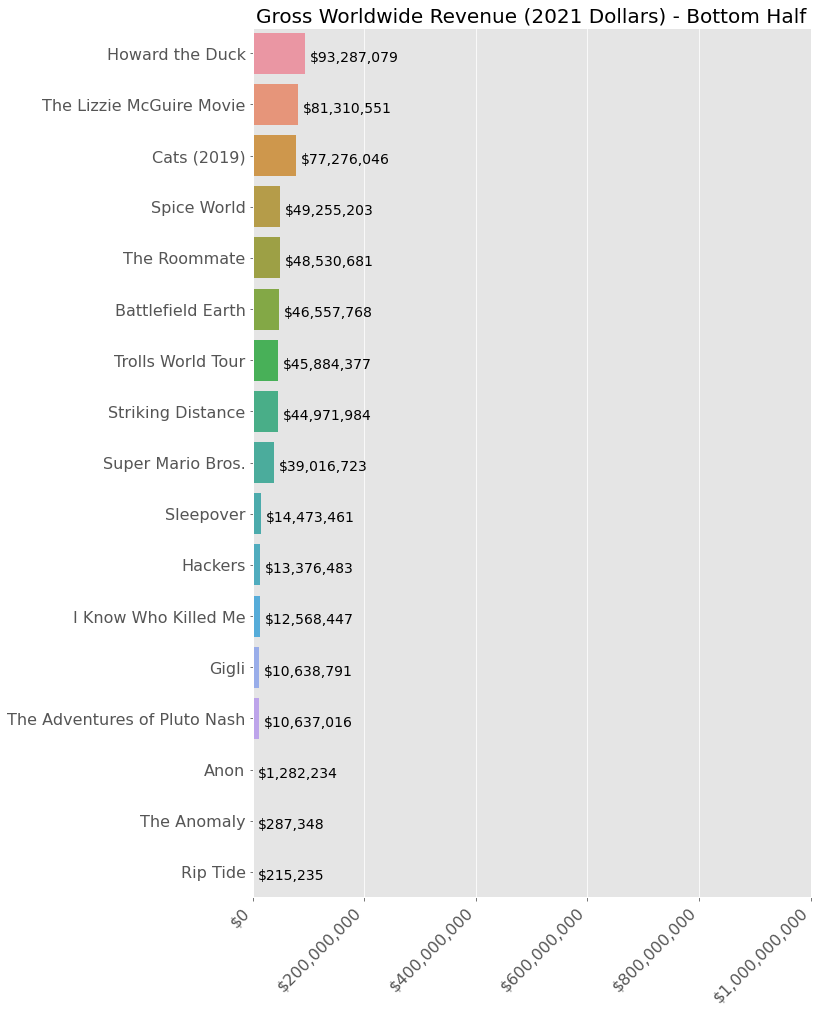

In [684]:
gross_worldwide_sorted = movie_df.sort_values(by='cumulative_worldwide_gross_imdb_adj_2021', ascending=False).reset_index(drop=True)
gross_worldwide_sorted = gross_worldwide_sorted[(gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'] != 0) & (gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'] != 0.0)]
gross_worldwide_sorted.loc[gross_worldwide_sorted['movie_title'] == 'The Adventures of Sharkboy and Lavagirl 3-D (2005)', 'movie_title'] = 'Sharkboy and Lavagirl'

fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=gross_worldwide_sorted['cumulative_worldwide_gross_imdb_adj_2021'][20:], y=gross_worldwide_sorted['movie_title'][20:])
plt.title('Gross Worldwide Revenue (2021 Dollars) - Bottom Half', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([0,1000000000])


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/gross_worldwide_clean_2.png', bbox_inches='tight')
plt.show() 

In [520]:
movie_df[(movie_df['cumulative_worldwide_gross_imdb'] == 0) | (movie_df['budget_imdb'] == 0)]['original_title'].values

array(['Emo the Musical (2016)', 'Sunday School Musical (2008)',
       'Step Sisters (2018)', 'The Clique (2008)', 'Yinz (2018)',
       'The Anomaly (2014)', 'Birdemic: Shock and Terror (2010)',
       'A Very Country Christmas (2017)', 'Santa Girl (2019)',
       'We Can Be Heroes (2020)', 'My Brother the Pig (1999)'],
      dtype=object)

### Gross Profit (Cumulative Worldwise Earnings - Budget)

In [315]:
filtered_movie_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb_adj_2021'] > 0) & (movie_df['budget_imdb_adj_2021'] > 0), :]
filtered_top100_df = top100_df.loc[(top100_df['cumulative_worldwide_gross_imdb_adj_2021'] > 0) & (top100_df['budget_imdb_adj_2021'] > 0), :]
filtered_bottom100_df = bottom100_df.loc[(bottom100_df['cumulative_worldwide_gross_imdb_adj_2021'] > 0) & (bottom100_df['budget_imdb_adj_2021'] > 0), :]

In [316]:
print('Movies with sufficient data to calculate profit and profit margin:')
print(str(round(len(filtered_movie_df) / len(movie_df),2)*100) + '%')

Movies with sufficient data to calculate profit and profit margin:
77.0%


In [522]:
movie_df['profit_adj_2021'] = movie_df['cumulative_worldwide_gross_imdb_adj_2021'] - movie_df['budget_imdb_adj_2021']
top100_df['profit_adj_2021'] = top100_df['cumulative_worldwide_gross_imdb_adj_2021'] - top100_df['budget_imdb_adj_2021']
bottom100_df['profit_adj_2021'] = bottom100_df['cumulative_worldwide_gross_imdb_adj_2021'] - bottom100_df['budget_imdb_adj_2021']

filtered_movie_df['profit_adj_2021'] = filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_movie_df['budget_imdb_adj_2021']
filtered_top100_df['profit_adj_2021'] = filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_top100_df['budget_imdb_adj_2021']
filtered_bottom100_df['profit_adj_2021'] = filtered_bottom100_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_bottom100_df['budget_imdb_adj_2021']

movie_df['profit'] = movie_df['cumulative_worldwide_gross_imdb'] - movie_df['budget_imdb']
top100_df['profit'] = top100_df['cumulative_worldwide_gross_imdb'] - top100_df['budget_imdb']
bottom100_df['profit'] = bottom100_df['cumulative_worldwide_gross_imdb'] - bottom100_df['budget_imdb']

filtered_movie_df['profit'] = filtered_movie_df['cumulative_worldwide_gross_imdb'] - filtered_movie_df['budget_imdb']
filtered_top100_df['profit'] = filtered_top100_df['cumulative_worldwide_gross_imdb'] - filtered_top100_df['budget_imdb']
filtered_bottom100_df['profit'] = filtered_bottom100_df['cumulative_worldwide_gross_imdb'] - filtered_bottom100_df['budget_imdb']

<ipython-input-522-4f99049cc9c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movie_df['profit_adj_2021'] = filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_movie_df['budget_imdb_adj_2021']
<ipython-input-522-4f99049cc9c7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_top100_df['profit_adj_2021'] = filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_top100_df['budget_imdb_adj_2021']
<ipython-input-522-4f99049cc9c7>:7: SettingWithCopyWarn

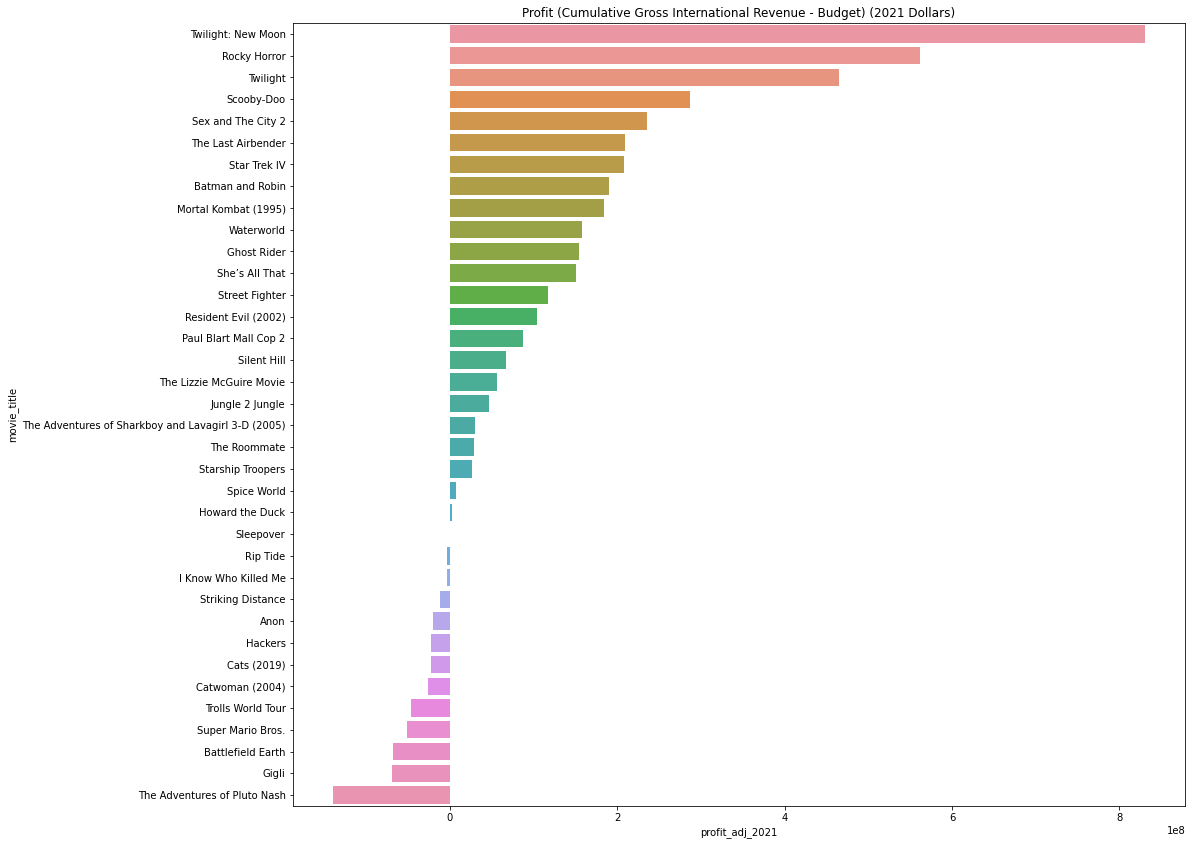

In [524]:
sorted_countplot('profit_adj_2021', 
                 filtered_movie_df, 
                 num_items=False, 
                 title='Profit (Cumulative Gross International Revenue - Budget) (2021 Dollars)', 
                 figure_name='images/profit_bar', 
                 ascending=False)

In [521]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]


print('Inflation Adjusted Profit Stats')
print('\n')
print('Highest Profit:')
print(profit_filtered_df[profit_filtered_df['profit_adj_2021'] == max(profit_filtered_df['profit_adj_2021'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit_adj_2021'] == max(profit_filtered_df['profit_adj_2021'])]['profit_adj_2021'].values[0],-2)))
print('\n')


print('Lowest Profit:')
print(profit_filtered_df[profit_filtered_df['profit_adj_2021'] == min(profit_filtered_df['profit_adj_2021'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit_adj_2021'] == min(profit_filtered_df['profit_adj_2021'])]['profit_adj_2021'].values[0],-2)))
print('\n')
print('Average Profit:')
print('$' + str(round(np.mean(profit_filtered_df['profit_adj_2021'].values), -2)))
print('\n')
print('Total Profit:')
print('$' + str(round(sum(profit_filtered_df['profit_adj_2021'].values), -2)))

Inflation Adjusted Profit Stats


Highest Profit:
The Twilight Saga: New Moon (2009)
$830348600.0


Lowest Profit:
The Adventures of Pluto Nash (2002)
$-139096300.0


Average Profit:
$103727200.0


Total Profit:
$3734177600.0


In [523]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]


print('Raw Profit Stats')
print('\n')
print('Highest Profit:')
print(profit_filtered_df[profit_filtered_df['profit'] == max(profit_filtered_df['profit'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit'] == max(profit_filtered_df['profit'])]['profit'].values[0],-2)))
print('\n')


print('Lowest Profit:')
print(profit_filtered_df[profit_filtered_df['profit'] == min(profit_filtered_df['profit'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit'] == min(profit_filtered_df['profit'])]['profit'].values[0],-2)))
print('\n')
print('Average Profit:')
print('$' + str(round(np.mean(profit_filtered_df['profit'].values), -2)))
print('\n')
print('Total Profit:')
print('$' + str(round(sum(profit_filtered_df['profit'].values), -2)))

Raw Profit Stats


Highest Profit:
The Twilight Saga: New Moon (2009)
$661025500


Lowest Profit:
The Adventures of Pluto Nash (2002)
$-92896000


Average Profit:
$65581700.0


Total Profit:
$2360940700


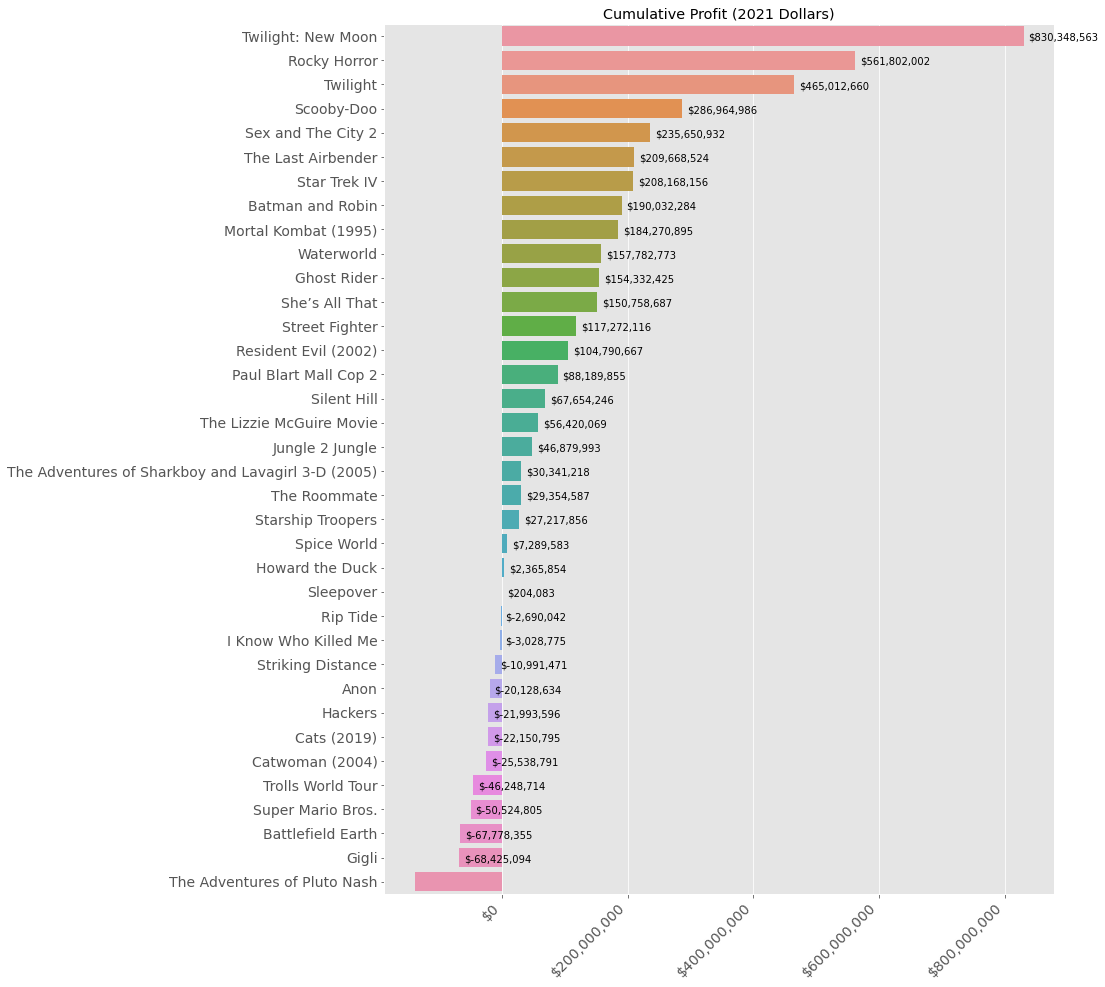

In [583]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]

profit_sorted = profit_filtered_df.sort_values(by='profit_adj_2021', ascending=False).reset_index(drop=True)
profit_sorted = profit_sorted[(profit_sorted['profit_adj_2021'] != 0) & (profit_sorted['profit_adj_2021'] != 0.0)]

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x=profit_sorted['profit_adj_2021'], y=profit_sorted['movie_title'])
plt.title('Cumulative Profit (2021 Dollars)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 1),
                xytext=(5, 10), textcoords='offset points')
plt.savefig('images/profit_clean.png', bbox_inches='tight')
plt.show()

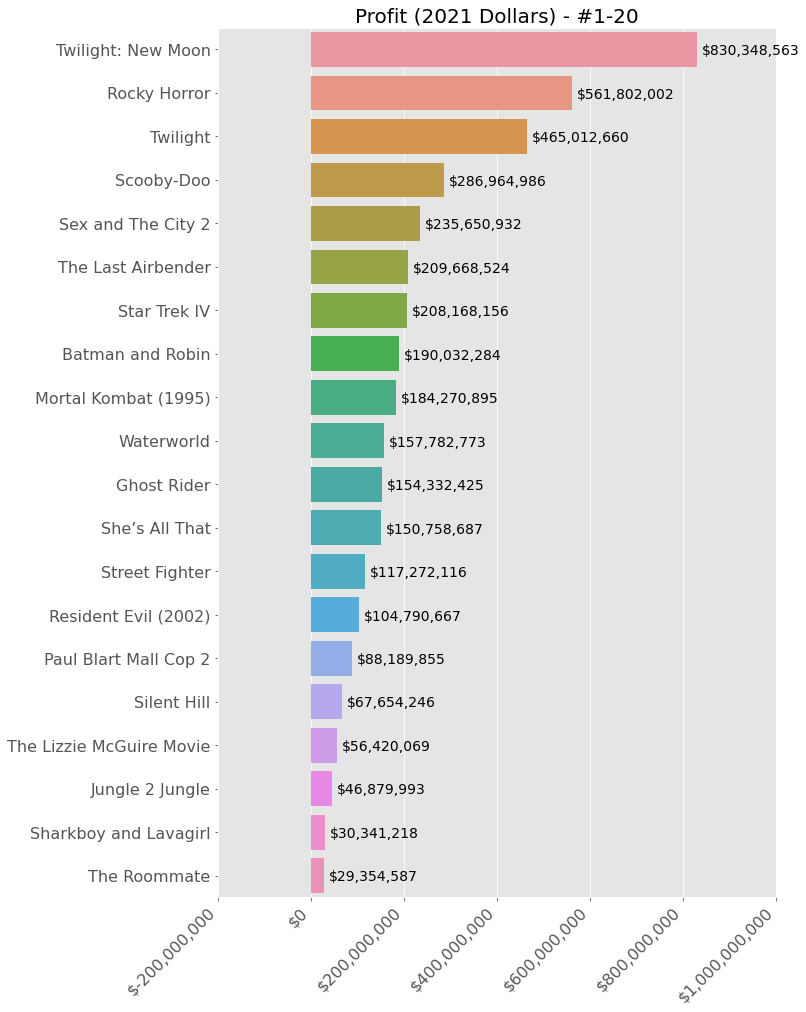

In [694]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]

profit_sorted = profit_filtered_df.sort_values(by='profit_adj_2021', ascending=False).reset_index(drop=True)
profit_sorted = profit_sorted[(profit_sorted['profit_adj_2021'] != 0) & (profit_sorted['profit_adj_2021'] != 0.0)]
profit_sorted.loc[profit_sorted['movie_title'] == 'The Adventures of Sharkboy and Lavagirl 3-D (2005)', 'movie_title'] = 'Sharkboy and Lavagirl'


fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=profit_sorted['profit_adj_2021'][:20], y=profit_sorted['movie_title'][:20])
plt.title('Profit (2021 Dollars) - #1-20', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([-200000000,1000000000])


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/profit_clean_1.png', bbox_inches='tight')
plt.show() 

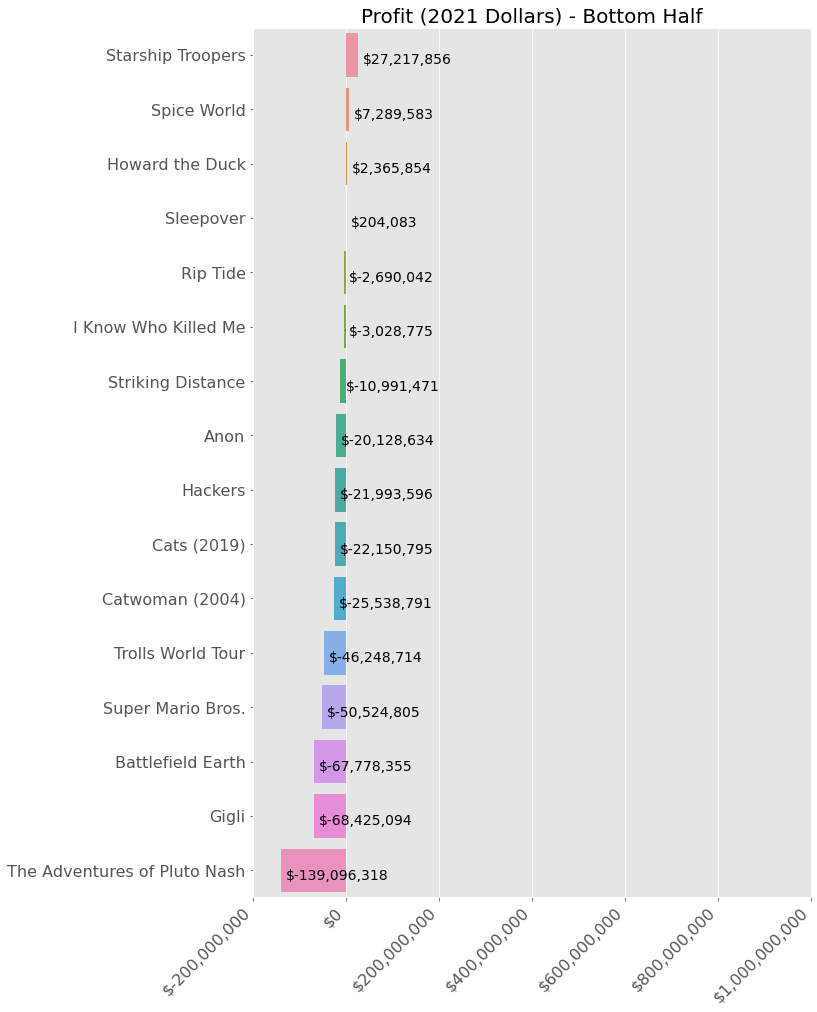

In [695]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]

profit_sorted = profit_filtered_df.sort_values(by='profit_adj_2021', ascending=False).reset_index(drop=True)
profit_sorted = profit_sorted[(profit_sorted['profit_adj_2021'] != 0) & (profit_sorted['profit_adj_2021'] != 0.0)]
profit_sorted.loc[profit_sorted['movie_title'] == 'The Adventures of Sharkboy and Lavagirl 3-D (2005)', 'movie_title'] = 'Sharkboy and Lavagirl'


fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=profit_sorted['profit_adj_2021'][20:], y=profit_sorted['movie_title'][20:])
plt.title('Profit (2021 Dollars) - Bottom Half', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '${x:,.0f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([-200000000,1000000000])


for p in ax.patches:
    ax.annotate("${:,.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/profit_clean_2.png', bbox_inches='tight')
plt.show() 

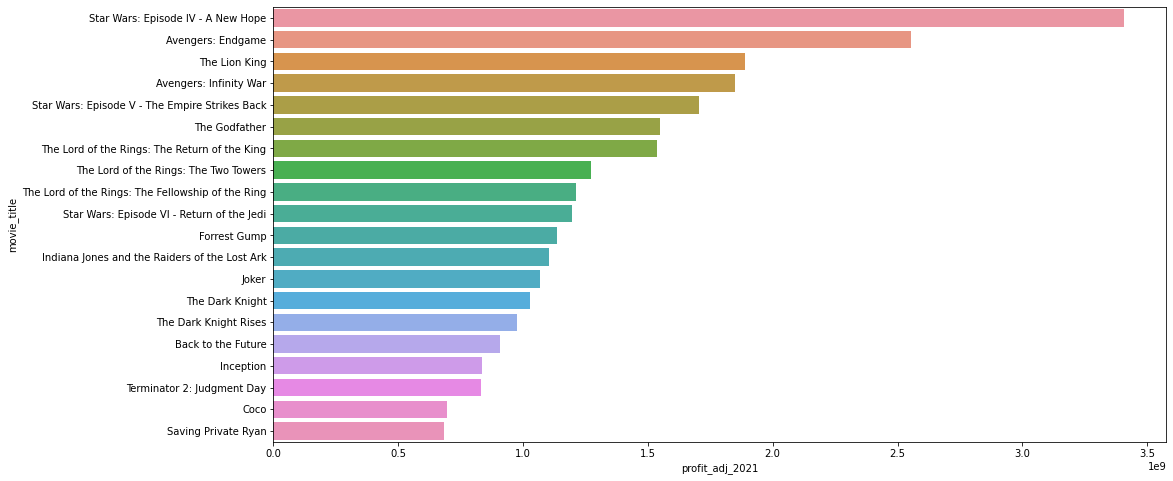

In [319]:
sorted_countplot('profit_adj_2021', 
                 filtered_top100_df, 
                 num_items=20, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Profit Margin (Gross Profit / Revenue)

In [716]:
movie_df['profit_margin_adj_2021'] = movie_df['profit_adj_2021'] / movie_df['cumulative_worldwide_gross_imdb_adj_2021']
top100_df['profit_margin_adj_2021'] = top100_df['profit_adj_2021'] / top100_df['cumulative_worldwide_gross_imdb_adj_2021']
bottom100_df['profit_margin_adj_2021'] = bottom100_df['profit_adj_2021'] / bottom100_df['cumulative_worldwide_gross_imdb_adj_2021']

filtered_movie_df['profit_margin_adj_2021'] = filtered_movie_df['profit_adj_2021'] / filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021']
filtered_top100_df['profit_margin_adj_2021'] = filtered_top100_df['profit_adj_2021'] / filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021']
filtered_bottom100_df['profit_margin_adj_2021'] = filtered_bottom100_df['profit_adj_2021'] / filtered_bottom100_df['cumulative_worldwide_gross_imdb_adj_2021']


movie_df['profit_margin'] = movie_df['profit'] / movie_df['cumulative_worldwide_gross_imdb']
top100_df['profit_margin'] = top100_df['profit'] / top100_df['cumulative_worldwide_gross_imdb']
bottom100_df['profit_margin'] = bottom100_df['profit'] / bottom100_df['cumulative_worldwide_gross_imdb']

filtered_movie_df['profit_margin'] = filtered_movie_df['profit'] / filtered_movie_df['cumulative_worldwide_gross_imdb']
filtered_top100_df['profit_margin'] = filtered_top100_df['profit'] / filtered_top100_df['cumulative_worldwide_gross_imdb']
filtered_bottom100_df['profit_margin'] = filtered_bottom100_df['profit'] / filtered_bottom100_df['cumulative_worldwide_gross_imdb']

<ipython-input-716-9292f2a45059>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movie_df['profit_margin_adj_2021'] = filtered_movie_df['profit_adj_2021'] / filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021']
<ipython-input-716-9292f2a45059>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_top100_df['profit_margin_adj_2021'] = filtered_top100_df['profit_adj_2021'] / filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021']
<ipython-input-716-9292f2a45059>:7: SettingWithCopy

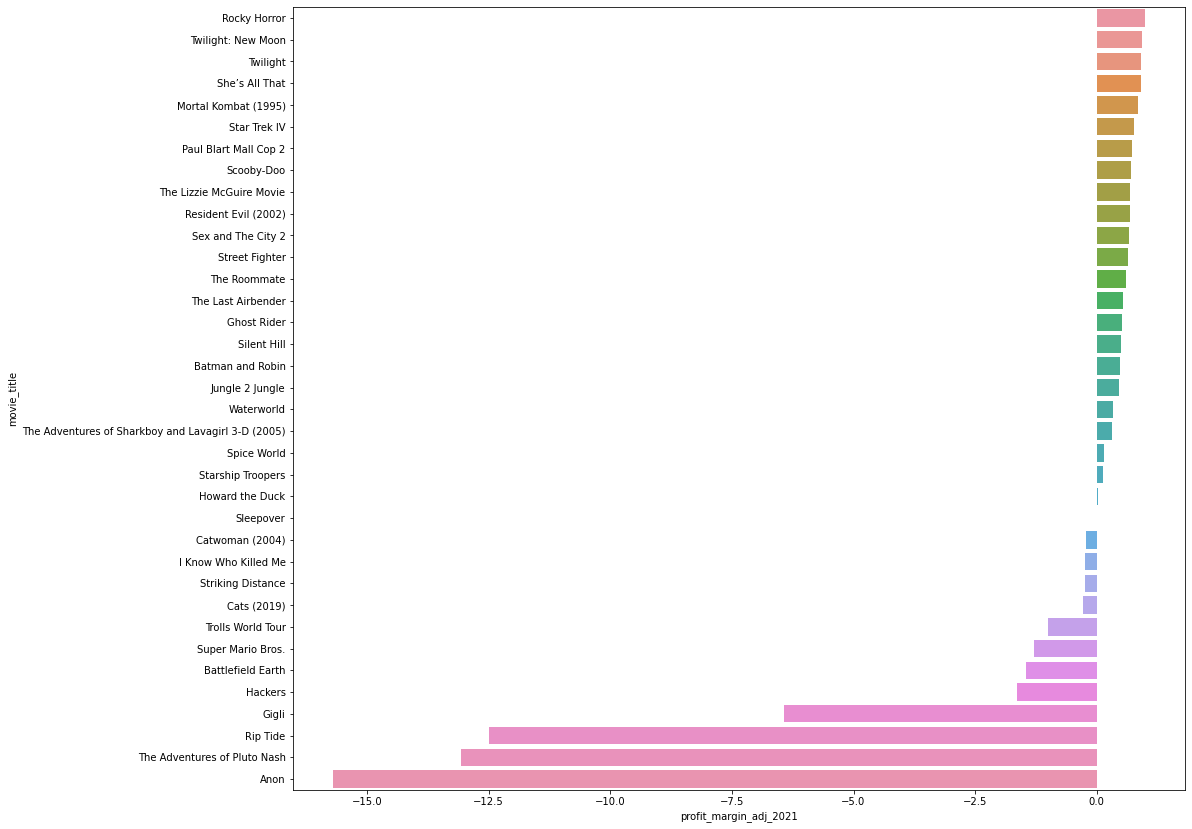

In [321]:
sorted_countplot('profit_margin_adj_2021', 
                 filtered_movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

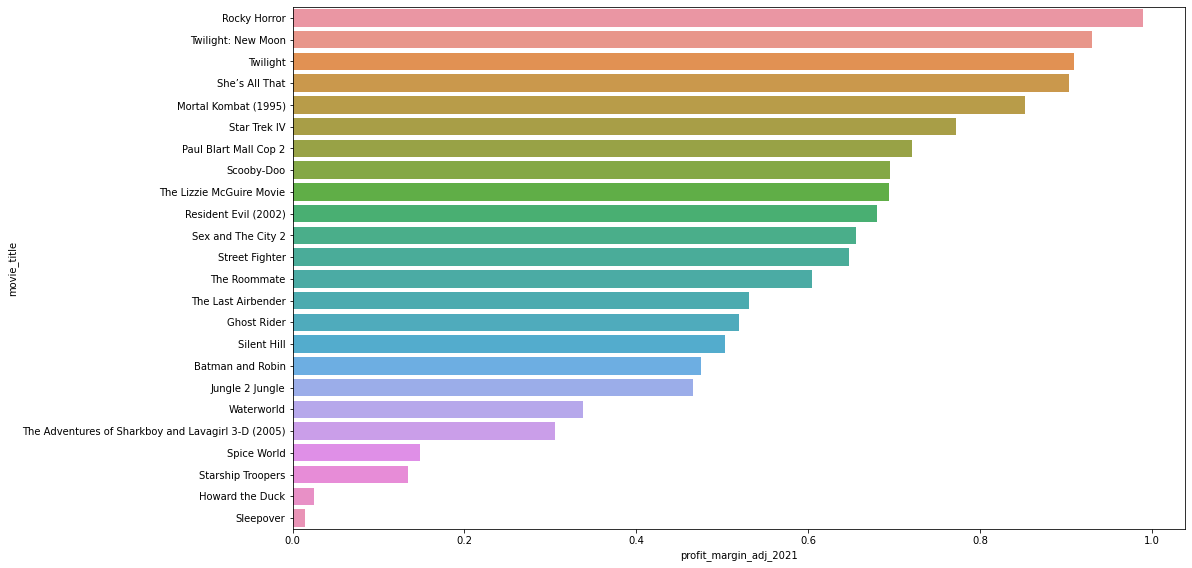

In [322]:
sorted_countplot('profit_margin_adj_2021', 
                 filtered_movie_df[filtered_movie_df['profit_margin_adj_2021'] > 0], 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

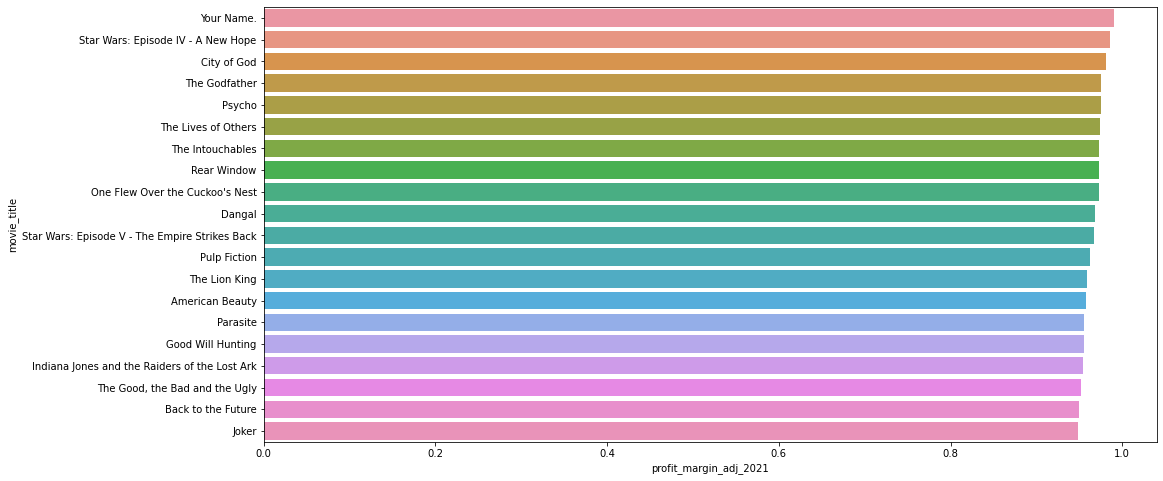

In [323]:
sorted_countplot('profit_margin_adj_2021', 
                 filtered_top100_df, 
                 num_items=20, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

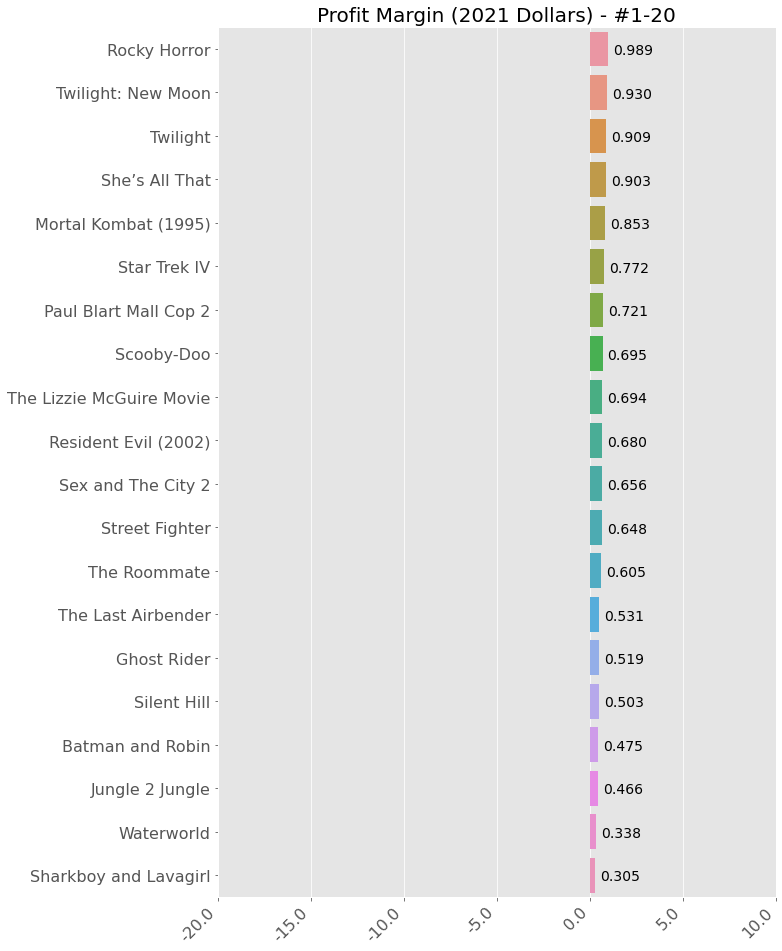

In [721]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]

profit_sorted = profit_filtered_df.sort_values(by='profit_margin_adj_2021', ascending=False).reset_index(drop=True)
profit_sorted = profit_sorted[(profit_sorted['profit_margin_adj_2021'] != 0) & (profit_sorted['profit_margin_adj_2021'] != 0.0)]
profit_sorted.loc[profit_sorted['movie_title'] == 'The Adventures of Sharkboy and Lavagirl 3-D (2005)', 'movie_title'] = 'Sharkboy and Lavagirl'


fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=profit_sorted['profit_margin_adj_2021'][:20], y=profit_sorted['movie_title'][:20])
plt.title('Profit Margin (2021 Dollars) - #1-20', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '{x:,.1f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([-20,10])


for p in ax.patches:
    ax.annotate("{:,.3f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/profit_margin_clean_1.png', bbox_inches='tight')
plt.show() 

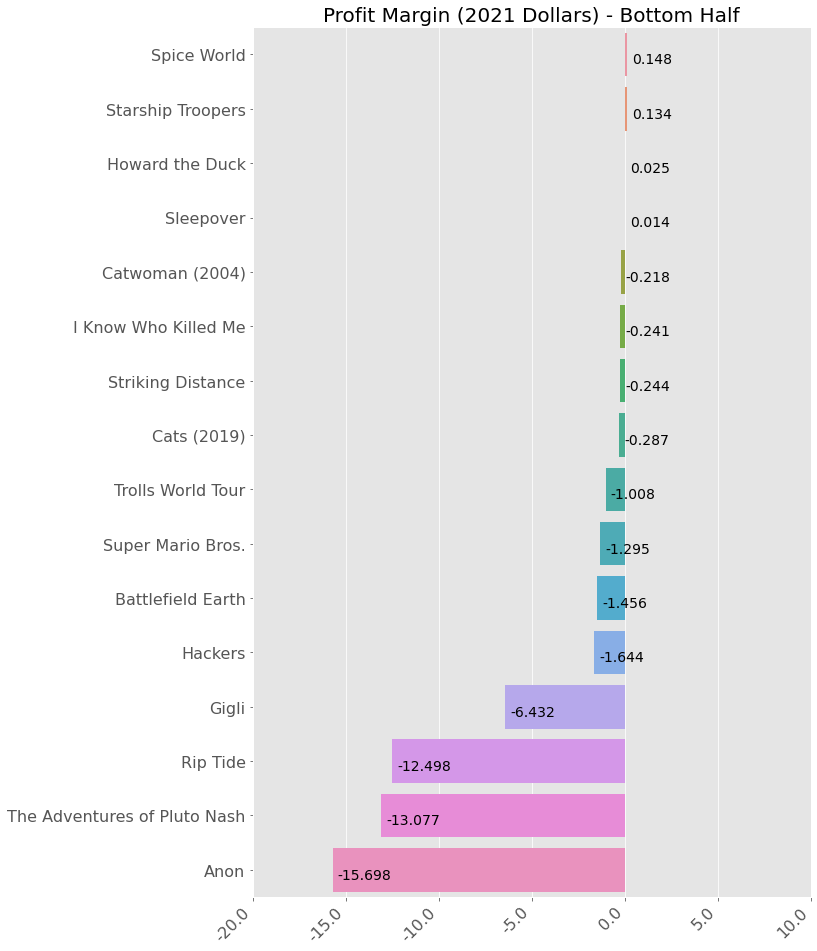

In [722]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]

profit_sorted = profit_filtered_df.sort_values(by='profit_margin_adj_2021', ascending=False).reset_index(drop=True)
profit_sorted = profit_sorted[(profit_sorted['profit_margin_adj_2021'] != 0) & (profit_sorted['profit_margin_adj_2021'] != 0.0)]
profit_sorted.loc[profit_sorted['movie_title'] == 'The Adventures of Sharkboy and Lavagirl 3-D (2005)', 'movie_title'] = 'Sharkboy and Lavagirl'


fig, ax = plt.subplots(figsize=(10,16))
sns.barplot(x=profit_sorted['profit_margin_adj_2021'][20:], y=profit_sorted['movie_title'][20:])
plt.title('Profit Margin (2021 Dollars) - Bottom Half', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation=45, ha='right')
fmt = '{x:,.1f}'
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
plt.xlabel('')
plt.ylabel('')
plt.xlim([-20,10])


for p in ax.patches:
    ax.annotate("{:,.3f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + 0.75),
                xytext=(5, 10), textcoords='offset points', fontsize=14)
plt.savefig('images/profit_margin_clean_2.png', bbox_inches='tight')
plt.show() 

In [715]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]


print('Inflation Adjusted Profit Margin Stats')
print('\n')
print('Highest Profit Margin:')
print(profit_filtered_df[profit_filtered_df['profit_margin_adj_2021'] == max(profit_filtered_df['profit_margin_adj_2021'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit_margin_adj_2021'] == max(profit_filtered_df['profit_margin_adj_2021'])]['profit_margin_adj_2021'].values[0],3)))
print('\n')


print('Lowest Profit Margin:')
print(profit_filtered_df[profit_filtered_df['profit_margin_adj_2021'] == min(profit_filtered_df['profit_margin_adj_2021'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit_margin_adj_2021'] == min(profit_filtered_df['profit_margin_adj_2021'])]['profit_margin_adj_2021'].values[0],3)))
print('\n')
print('Average Profit Margin:')
print('$' + str(round(np.mean(profit_filtered_df['profit_margin_adj_2021'].values), 3)))


Inflation Adjusted Profit Margin Stats


Highest Profit Margin:
The Rocky Horror Picture Show (1975)
$0.989


Lowest Profit Margin:
Anon (2018)
$-15.698


Average Profit Margin:
$-1.127


In [718]:
profit_filtered_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb'] > 0) & (movie_df['budget_imdb'] > 0), :]


print('Raw Profit Margin Stats')
print('\n')
print('Highest Profit Margin:')
print(profit_filtered_df[profit_filtered_df['profit_margin'] == max(profit_filtered_df['profit_margin'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit_margin'] == max(profit_filtered_df['profit_margin'])]['profit_margin'].values[0],3)))
print('\n')


print('Lowest Profit Margin:')
print(profit_filtered_df[profit_filtered_df['profit_margin'] == min(profit_filtered_df['profit_margin'])]['original_title'].values[0])
print('$' + str(round(profit_filtered_df[profit_filtered_df['profit_margin'] == min(profit_filtered_df['profit_margin'])]['profit_margin'].values[0],3)))
print('\n')
print('Average Profit Margin:')
print('$' + str(round(np.mean(profit_filtered_df['profit_margin'].values), 3)))


Raw Profit Margin Stats


Highest Profit Margin:
The Rocky Horror Picture Show (1975)
$0.989


Lowest Profit Margin:
Anon (2018)
$-15.698


Average Profit Margin:
$-1.127


# Save Dataframes 

In [324]:
movie_df.to_csv('data/movie_df.csv', index=False)
top100_df.to_csv('data/top100_df.csv', index=False)
bottom100_df.to_csv('data/bottom100_df.csv', index=False)

filtered_movie_df.to_csv('data/filtered_movie_df.csv', index=False)
filtered_top100_df.to_csv('data/filtered_top100_df.csv', index=False)
filtered_bottom100_df.to_csv('data/filtered_bottom100_df.csv', index=False)

In [325]:
# movie_df[movie_df['cast'].str.contains('Matthew Lillard')]

# Separate into Tables for Tableau

In [414]:
movie_counts_df = movie_df[['original_title'] + count_name_flags + ['total_people']]
movie_counts_df.to_csv('data/movie_count_df.csv', index=False)

In [464]:
general_flags = ['original title', 'plot', 'runtimes', 'countries', 'country codes', 'language codes', 
                 'color info', 'aspect ratio', 'sound mix', 'certificates', 'original air date', 'rating',
                 'votes', 'cover url', 'imdbID', 'languages', 'title', 'year', 'kind']


general_flags = [re.sub(' ', '_', x) for x in general_flags]

In [465]:
movie_general_df = movie_df[general_flags]
movie_general_df.to_csv('data/movie_general_df.csv', index=False)

In [466]:
money_flags = ['profit_adj_2021', 'profit_margin_adj_2021', 'budget_imdb_adj_2021',
               'opening_weekend_usa_imdb_adj_2021', 'gross_usa_imdb_adj_2021', 
               'cumulative_worldwide_gross_imdb_adj_2021']

new_cols = ['original_title', 'profit', 'profit_margin', 'budget', 'domestic_opening_weekend_revenue',
            'domestic_gross_revenue', 'worldwide_gross_revenue']

In [467]:
movie_money_df = movie_df[['original_title'] + money_flags]
movie_money_df.columns = new_cols
movie_money_df.to_csv('data/movie_money_df.csv', index=False)

In [468]:
title_list = []
role_list = []
name_list = []

for flag in closed_people_flags:
    for title in movie_df['original_title'].values:
        name_string = movie_df[(movie_df['original_title'] == title)][flag].values[0]
        if name_string != '':
            for name in name_string.split(';'):
                title_list.append(title)
                role_list.append(flag)
                name_list.append(name.strip())
                
movie_people_df = pd.DataFrame(list(zip(title_list, role_list, name_list)), columns=['original_title', 'role', 'name'])
movie_people_df.to_csv('data/movie_people_df.csv', index=False)

In [469]:
company_flags = ['production_companies', 'distributors', 'special_effects_companies', 'other_companies']

In [470]:
title_list = []
company_category_list = []
company_name_list = []

for flag in company_flags:
    for title in movie_df['original_title'].values:
        company_name_string = movie_df[(movie_df['original_title'] == title)][flag].values[0]
        if company_name_string != '':
            for name in company_name_string.split(';'):
                title_list.append(title)
                company_category_list.append(flag)
                company_name_list.append(name.strip())
                
movie_company_df = pd.DataFrame(list(zip(title_list, company_category_list, company_name_list)), columns=['original_title', 'company_category', 'company_name'])
movie_company_df.to_csv('data/movie_company_df.csv', index=False)

In [471]:
title_list = []
genre_list = []

for title in movie_df['original_title'].values:
    genre_string = movie_df[(movie_df['original_title'] == title)]['genres'].values[0]
    if genre_string != '':
        for genre in genre_string.split(';'):
            title_list.append(title)
            genre_list.append(genre)

movie_genre_df = pd.DataFrame(list(zip(title_list, genre_list)), columns=['original_title', 'genre'])
movie_genre_df.to_csv('data/movie_genre_df.csv', index=False)

In [525]:
movie_df

movie_title  \
0                                         Cats (2019)   
1                                     Emo the Musical   
2                               Sunday School Musical   
3                               Paul Blart Mall Cop 2   
4                                          Waterworld   
5                                   Battlefield Earth   
6                                   Striking Distance   
7                                            Twilight   
8                                  Twilight: New Moon   
9                            The Lizzie McGuire Movie   
10                                              Gigli   
11                                               Anon   
12                                       Step Sisters   
13                                           Rip Tide   
14                                  Starship Troopers   
15                                         The Clique   
16                                 The Last Airbender   
17                                          Sleepover   
18  The Adventures of Sharkboy and Lavagirl 3-D (2...   
19                                       The Roommate   
20                               Mortal Kombat (1995)   
21                                        Ghost Rider   
22                                 Sex and The City 2   
23                       The Adventures of Pluto Nash   
24                                         Scooby-Doo   
25                                        Silent Hill   
26                               Resident Evil (2002)   
27                                               Yinz   
28                                        The Anomaly   
29                         Birdemic: Shock and Terror   
30                                  Super Mario Bros.   
31                                  Trolls World Tour   
32                                       Rocky Horror   
33                                     Street Fighter   
34                           A Very Country Christmas   
35                                         Santa Girl   
36                                   We Can Be Heroes   
37                                        Spice World   
38                                       Star Trek IV   
39                               I Know Who Killed Me   
40                                    Jungle 2 Jungle   
41                                    Howard the Duck   
42                                     She’s All That   
43                                            Hackers   
44                                   Batman and Robin   
45                                 My Brother the Pig   
46                                    Catwoman (2004)   

                                                 plot  \
0   A tribe of cats called the Jellicles must deci...   
1   Ethan, a sullen high-school student whose life...   
2   When financial woes threaten their church's fu...   
3   After six years of keeping our malls safe, Pau...   
4   In a future where the polar ice-caps have melt...   
5   It's the year 3000 A.D., and the Earth is lost...   
6   Coming from a police family, Tom Hardy ends up...   
7   When Bella Swan moves to a small town in the P...   
8   Edward leaves Bella after an attack that nearl...   
9   Lizzie McGuire has graduated from middle schoo...   
10  Larry Gigli is assigned by a crime boss to kid...   
11  In a world without anonymity or crime, a detec...   
12  To get the college dean's backing for Harvard,...   
13  Following an embarrassing viral video, a New Y...   
14  Humans in a fascist, militaristic future wage ...   
15  A young girl tries to fit in with a clique of ...   
16  Follows the adventures of Aang, a young succes...   
17  Desperate to improve their social status, four...   
18  A young boy is recruited by his imaginary frie...   
19  When college freshman Sara arrives on campus f...   
20  Three unknowing martial artists are summoned t...   
21  When motorcycle rider Johnny Blaze sells his s.